In [1]:
# Import necessary librarie

import warnings

warnings.filterwarnings('ignore')

import datetime

import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import seaborn as sns
import functools

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix

import pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

## Data Wrangling

In [2]:
# Download the data for the stocks
data = pd.ExcelFile('stock_prices.xlsx')

In [3]:
# Get the sheet names to download the sotck prices in different data frames
data.sheet_names

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

In [4]:
# Define a function to read the stock information, get the price column and rename to the stock + Price name

def read_stock(n, col_name):
    df = pd.DataFrame(data.parse(data.sheet_names[n])[['Date','Price']]).rename(columns = {'Price': col_name})
    df = df.iloc[:-1, :]
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='ignore')
    df = df.set_index('Date')
    return df

In [5]:
# Use the function for the different stock prices

S_stock = read_stock(n = 0, col_name = 'S_Price')
KCHOL_stock = read_stock(n = 1, col_name = 'KCHOL_Price')
M_stock = read_stock(n = 2, col_name = 'M_Price')
BEEF_stock = read_stock(n = 3, col_name = 'BEEF_Price')
P_stock = read_stock(n = 4, col_name = 'P_Price')
C_stock = read_stock(n = 5, col_name = 'C_Price')
IP_stock = read_stock(n = 6, col_name = 'IP_Price')
DS_stock = read_stock(n = 7, col_name = 'DS_Price')

In [6]:
# Define a function to merge the different data frames

def merge_df(df1, df2, df3, df4, df5, df6, df7, df8):
    df = [df1, df2, df3, df4, df5, df6, df7, df8]
    return functools.reduce(lambda left, right : pd.merge(left, right, how = 'left', on = 'Date'), df)

In [7]:
# Merge he data frames

stock_prices = merge_df(df1 = S_stock, df2 = KCHOL_stock, df3 = M_stock, df4 = BEEF_stock, df5 = P_stock, 
                        df6 = C_stock, df7 = IP_stock, df8 = DS_stock)

In [8]:
# Sort the index to have the dates in ascending order

stock_prices = stock_prices.sort_index()

In [9]:
# Check out the NaN Values

for col in stock_prices:
    print(col)
    print(stock_prices[col].isna().sum())

S_Price
0
KCHOL_Price
9
M_Price
77
BEEF_Price
13
P_Price
22
C_Price
20
IP_Price
10
DS_Price
14


In [10]:
# Fill the NaN values with forward filling

stock_prices_daily = stock_prices.fillna(method = 'ffill')

stock_prices_daily['M_Price'] = stock_prices['M_Price'].fillna(method = 'bfill')

# Normalize the data to have prices between 0-1 (different currencies)

stock_prices_daily_normalized = stock_prices_daily.div(stock_prices_daily.max())

In [11]:
# Resample the data weekly and monthly and do the same for the normalized data

stock_prices_weekly = stock_prices_daily.resample('W').mean()
stock_prices_weekly_normalized = stock_prices_daily_normalized.resample('W').mean()

stock_prices_monthly = stock_prices_daily.resample('M').mean()
stock_prices_monthly_normalized = stock_prices_daily_normalized.resample('M').mean()

In [12]:
# Calculate the returns for daily, weekly and monthly 

stock_returns_daily = stock_prices_daily.pct_change().dropna()

stock_returns_weekly = stock_prices_weekly.pct_change().dropna()

stock_returns_monthly = stock_prices_monthly.pct_change().dropna()

In [13]:
# Multi Period Return

def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

stock_returns_daily_pr = stock_returns_daily.rolling('360D').apply(multi_period_return)

In [14]:
# See the first rows for stock returns daily

stock_returns_daily.head()

S_Price  KCHOL_Price   M_Price  BEEF_Price   P_Price   C_Price  \
Date                                                                          
2020-01-06 -0.004314    -0.010837  0.000000   -0.000775 -0.006148  0.000000   
2020-01-08  0.020677    -0.006972  0.030374    0.057409 -0.041237 -0.017143   
2020-01-09 -0.004476     0.024072  0.047619   -0.015407  0.036559 -0.010174   
2020-01-10  0.000775     0.005877  0.025974   -0.004471 -0.002075 -0.005874   
2020-01-13  0.016306     0.012658  0.000000    0.089820 -0.010395 -0.016248   

            IP_Price  DS_Price  
Date                            
2020-01-06 -0.015024 -0.028814  
2020-01-08  0.045828 -0.052356  
2020-01-09 -0.016939  0.011050  
2020-01-10 -0.007784  0.001821  
2020-01-13 -0.010862  0.003636

In [15]:
# See the first rows for stock returns weekly

stock_returns_weekly.head()

S_Price  KCHOL_Price   M_Price  BEEF_Price   P_Price   C_Price  \
Date                                                                          
2020-01-12  0.009049    -0.002709  0.054322    0.032946 -0.019980 -0.019286   
2020-01-19  0.008731     0.030575  0.064598    0.099437 -0.016414 -0.035397   
2020-01-26  0.024912     0.015146 -0.028310   -0.023754  0.002976  0.000604   
2020-02-02 -0.035809    -0.054958  0.000857   -0.168508 -0.035184 -0.016601   
2020-02-09 -0.008944    -0.005995  0.006421    0.001009  0.032293 -0.010129   

            IP_Price  DS_Price  
Date                            
2020-01-12  0.008135 -0.061441  
2020-01-19 -0.007922 -0.003521  
2020-01-26 -0.024533 -0.009786  
2020-02-02 -0.046765 -0.071925  
2020-02-09  0.064895  0.004536

In [16]:
# See the first rows for stock returns monthly

stock_returns_monthly.head()

S_Price  KCHOL_Price   M_Price  BEEF_Price   P_Price   C_Price  \
Date                                                                          
2020-02-29 -0.035158    -0.052227 -0.018411   -0.115723 -0.065941 -0.093874   
2020-03-31 -0.208611    -0.233035 -0.288244   -0.272670 -0.125974 -0.364742   
2020-04-30 -0.029628    -0.017621 -0.087966    0.116947  0.102754  0.001470   
2020-05-31  0.002142     0.036267 -0.113204    0.373662  0.225149 -0.074671   
2020-06-30  0.087484     0.143947  0.019610   -0.020883 -0.053766  0.007810   

            IP_Price  DS_Price  
Date                            
2020-02-29  0.051736 -0.052666  
2020-03-31 -0.395876 -0.262213  
2020-04-30  0.105588  0.040225  
2020-05-31  0.098673  0.034586  
2020-06-30  0.076068  0.473359

## Data Visualization

In [17]:
# Plot how the prices have been moving during time

def plot_prices(df):
    df.plot()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc = (1.02,0))
    return plt.show()

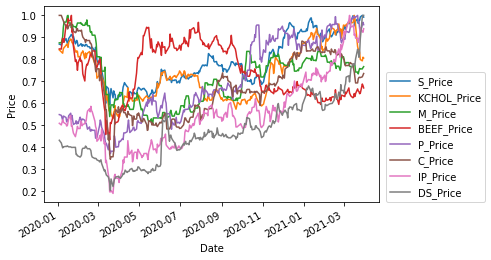

In [18]:
# Plot daily prices

plot_prices(df = stock_prices_daily_normalized)

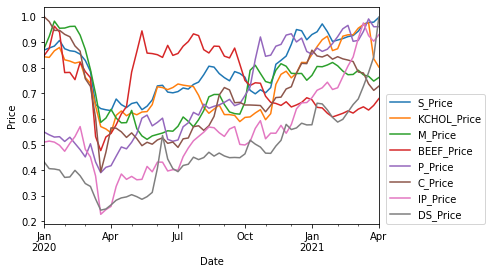

In [19]:
# Plot weekly prices

plot_prices(df = stock_prices_weekly_normalized)

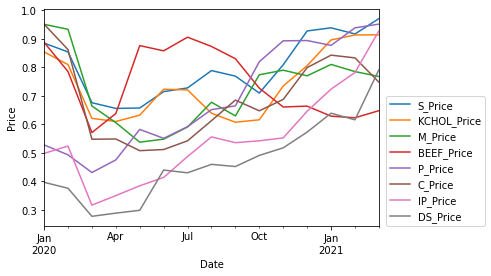

In [20]:
# Plot monthly prices

plot_prices(df = stock_prices_monthly_normalized)

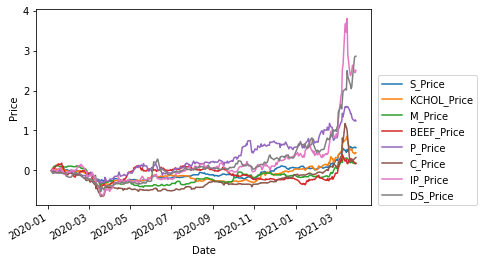

In [21]:
# Plot multiperiod return

plot_prices(df = stock_returns_daily_pr)


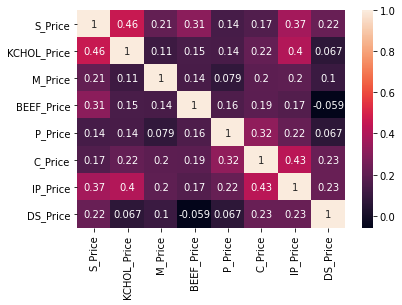

In [22]:
# Plot a correlation heatmap among all the stocks

corr_matrix = stock_returns_daily.corr()

# Plot the heatmap

sns.heatmap(corr_matrix, annot = True)
plt.show()

## Feature Engineering

In [23]:
# Define a function to use MaxMin Scaler for the modeling part

def scaler(train_array, test_array):
    scaler = MinMaxScaler(feature_range = (0,1))
    a = train_array.reshape(-1,1)
    b = test_array.reshape(-1,1)
    scaler = scaler.fit(a)
    X = scaler.transform(a)
    y = scaler.transform(b)
    return X, y

In [24]:
# Define a function to calculate the real price of the stock based on the MinMax Scaler

def scaler_inverse(train_array, predictions):
    scaler = MinMaxScaler(feature_range = (0,1))
    c = train_array.reshape(-1,1)
    scaler.fit(c)
    y_inverse = scaler.inverse_transform(predictions)
    return y_inverse

In [25]:
# Define a function to have the previous 5 days as independant features to predict the stock price

def preprocessing(dataset, time_steps = 1):
    X, y = [], []
    for i in range(len(dataset) - time_steps - 1):
        x = dataset[i:(i + time_steps), 0]
        X.append(x)
        y.append(dataset[i + time_steps, 0])
    return X, y

In [26]:
# Divide the train and test data

train = stock_prices_daily['2020']
test = stock_prices_daily['2021']

In [27]:
# Define an empty array to change the shape of the X variable (train and test)
# The new shape with treat the stock prices as each of the subarrays
# Eight stocks mean an array with shape (8, n_days)

n_days = len(stock_prices_daily)

# Define number of stocks

n_stocks = len(stock_prices_daily.columns)

# Save the number of days that are going to be used as train and test

n_days_train = len(train)
n_days_test = len(test)

# Empty array for the train and test data

train_scale = np.zeros(shape = (n_stocks, n_days_train))

test_scale = np.zeros(shape = (n_stocks, n_days_test))

# Use the for loop to iterate over the train and test to have the array shape changed

for i in range(0, n_stocks):
    train_scale[i] = train.iloc[:,i]
    
for i in range(0, n_stocks):
    test_scale[i] = test.iloc[:,i]


### Apply the Scaler function to the stocks

In [28]:
# Empty arrays for the train and test data (n_stocks, ndays, 1) to make it usable after using the MinMax Scaler

Xtrain = np.empty(shape = (n_stocks, n_days_train, 1))

Xtest = np.empty(shape = (n_stocks, n_days_test, 1))

# For loop to create the Xtrain and Xtest and scale the data (by just fitting the train data). 
# The idea is to avoid the data leakage by scaling the complete data set

for i in range(n_stocks):
    Xtrain[i], Xtest[i] = scaler(train_array = train_scale[i], test_array = test_scale[i])
    

In [29]:
# Get together the Xtrain and Xtest to apply some feature engineering (Make previous 5 days as independent variables)
# and the day ahead the dependant variable

# Define the empty array to iterate over an array (more time efficient)

Values = np.empty(shape = (n_stocks, n_days, 1))

#Iterate by concatenating the Xtrain and Xtest

for i in range(n_stocks):
    Values[i] = np.concatenate((Xtrain[i], Xtest[i]))

In [30]:
# Use the function to use the previous 5 days as independent features for train data

time_steps = 5

# Make two empty list to store the data

X = []
y = []

for i in range(0, n_stocks):
    # Use the preprocessing function 
    a,b = preprocessing(dataset = Values[i], time_steps = time_steps)
    # Apend the values
    X.append(a)
    y.append(b)

# Make sure to have them as arrays

X = np.array(X)
y = np.array(y)

In [31]:
# X_train array will have new shape

# Define the new days for each subarray

n_days_train_resample = n_days_train - time_steps - 1

# Make empty arrays with the reshape of the data after taking the 5 days as independant variables

X_train = np.empty(shape = (n_stocks, n_days_train_resample, 5))

y_train = np.empty(shape = (n_stocks, n_days_train_resample))

X_test = np.empty(shape = (n_stocks, n_days_test, 5))

y_test = np.empty(shape = (n_stocks, n_days_test))

In [32]:
# Start for the X_train, y_train, X_test, y_test

for i in range(n_stocks):
    X_train[i], y_train[i] = X[i][:n_days_train_resample], y[i][:n_days_train_resample]
    X_test[i], y_test[i] = X[i][n_days_train_resample:], y[i][n_days_train_resample:]

In [33]:
# Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , X_test.shape[2], 1)

In [34]:
print('Shape of the train data to use at the model', X_train.shape, y_train.shape)
print('Shape of the test data to use', X_test.shape, y_test.shape)

Shape of the train data to use at the model (8, 244, 5, 1) (8, 244)
Shape of the test data to use (8, 61, 5, 1) (8, 61)


## Modeling

### LSTM

In [35]:
# Define a model to build the neural network

def neural_network():
    # Begin with Sequential
    regressor = Sequential()
    # The first layer would the be LSTM
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (5,1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

In [36]:
# Define a variable to reshape the train and test data into shape (, , 1) to make it processable on the neural network

def variables_model(n):
    x_train, Y_train = X_train[n], y_train[n]
    x_test, Y_test = X_test[n], y_test[n]
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    
    return (x_train, x_test, Y_train, Y_test)
    

In [37]:
# Fit the model and get the predictions

def model_fit(Xtr, ytr, Xte):
    model.fit(Xtr, ytr, epochs = 100, batch_size = 32)
    pred = model.predict(Xte)
    return pred

In [38]:
# For future use in plotting, create one data frame to have the train values plus the test values
# and another pandas series to have the train data plus the predicted values

def df_merger(train_data, test_data, pred_values):
    actual_data = train_data.append(test_data)
    predicted_data = train_data.append(pred_values)
    return actual_data, predicted_data

In [39]:
# Compare actual values with predicted values with a plot

def plot_comparison(actual, predicted, string):
    #Visualizing the prediction
    plt.figure(figsize=(10,6))
    plt.plot(actual[:'2020-12-30'], color = 'blue')
    plt.plot(actual['2020-12-30':], color = 'orange', label = 'Actual Values')
    plt.plot(predicted['2020-12-30':], color = 'green', label = 'Predicted Values')
    plt.title(string)
    plt.xlabel('Trading Day')
    plt.ylabel('Price')
    plt.legend()
    return plt.show()
    

In [40]:
# Save a data frame to concat all the predictions

# Start with an empty data frame
predictions_df = pd.DataFrame()

# Start with the same date than the test for the comparisons.
predictions_df['Date'] = test.index

#Set the date as the index
predictions_df.set_index('Date', inplace = True)

In [41]:
# Define the model

model = neural_network()

In [42]:
# Check the summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 5, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

#### S_Stock

In [43]:
# Get the data for this stock

S_Xtrain, S_Xtest, S_ytrain, S_ytest = variables_model(n = 0)

In [44]:
# Fit the data for the stock

S_pred = model_fit(Xtr = S_Xtrain, ytr = S_ytrain, Xte = S_Xtest)


Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 291us/sample - loss: 0.2039
Epoch 2/100
244/244 [==============================] - 0s 274us/sample - loss: 0.0652
Epoch 3/100
244/244 [==============================] - 0s 280us/sample - loss: 0.0419
Epoch 4/100
244/244 [==============================] - 0s 272us/sample - loss: 0.0251
Epoch 5/100
244/244 [==============================] - 0s 276us/sample - loss: 0.0245
Epoch 6/100
244/244 [==============================] - 0s 271us/sample - loss: 0.0159
Epoch 7/100
244/244 [==============================] - 0s 275us/sample - loss: 0.0153
Epoch 8/100
244/244 [==============================] - 0s 257us/sample - loss: 0.0103
Epoch 9/100
244/244 [==============================] - 0s 265us/sample - loss: 0.0112
Epoch 10/100
244/244 [==============================] - 0s 270us/sample - loss: 0.0107
Epoch 11/100
244/244 [==============================] - 0s 264us/sample - loss: 0.0095
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 235us/sample - loss: 0.0074
Epoch 96/100
244/244 [==============================] - 0s 239us/sample - loss: 0.0067
Epoch 97/100
244/244 [==============================] - 0s 238us/sample - loss: 0.0066
Epoch 98/100
244/244 [==============================] - 0s 240us/sample - loss: 0.0064
Epoch 99/100
244/244 [==============================] - 0s 263us/sample - loss: 0.0064
Epoch 100/100
244/244 [==============================] - 0s 322us/sample - loss: 0.0067
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [45]:
# Use the inverse transform function

S_pred_prices = scaler_inverse(train_array = train['S_Price'].values, predictions = S_pred)


In [46]:
# Add the first column to the data frame that will store the predictions

predictions_df['S_Price'] = S_pred_prices


In [47]:
# Get the actual and predicted data as data frames for both

S_actual, S_predicted = df_merger(train_data = train['S_Price'], test_data = test['S_Price'], 
                                  pred_values = predictions_df['S_Price'])


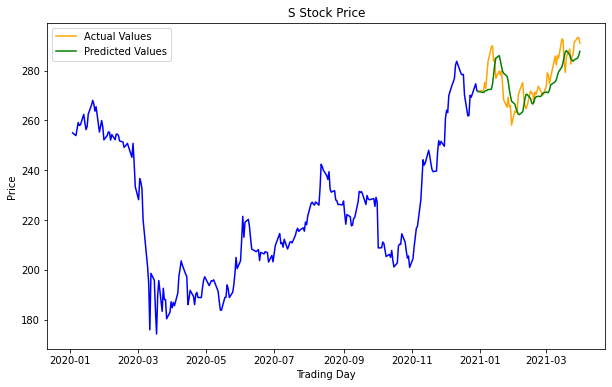

In [48]:
# Plot the S Stock Price comparison

plot_comparison(actual = S_actual, predicted = S_predicted, string = 'S Stock Price')

#### KCHOL Stock

In [49]:
# Get the data for this stock

KCHOL_Xtrain, KCHOL_Xtest, KCHOL_ytrain, KCHOL_ytest = variables_model(n = 1)

In [50]:
# Fit the model

KCHOL_pred = model_fit(Xtr = KCHOL_Xtrain, ytr = KCHOL_ytrain, Xte = KCHOL_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 256us/sample - loss: 0.0070
Epoch 2/100
244/244 [==============================] - 0s 238us/sample - loss: 0.0074
Epoch 3/100
244/244 [==============================] - 0s 261us/sample - loss: 0.0071
Epoch 4/100
244/244 [==============================] - 0s 255us/sample - loss: 0.0068
Epoch 5/100
244/244 [==============================] - 0s 243us/sample - loss: 0.0075
Epoch 6/100
244/244 [==============================] - 0s 259us/sample - loss: 0.0064
Epoch 7/100
244/244 [==============================] - 0s 239us/sample - loss: 0.0066
Epoch 8/100
244/244 [==============================] - 0s 253us/sample - loss: 0.0070
Epoch 9/100
244/244 [==============================] - 0s 238us/sample - loss: 0.0069
Epoch 10/100
244/244 [==============================] - 0s 265us/sample - loss: 0.0066
Epoch 11/100
244/244 [==============================] - 0s 258us/sample - loss: 0.0072
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 240us/sample - loss: 0.0043
Epoch 96/100
244/244 [==============================] - 0s 238us/sample - loss: 0.0047
Epoch 97/100
244/244 [==============================] - 0s 238us/sample - loss: 0.0043
Epoch 98/100
244/244 [==============================] - 0s 232us/sample - loss: 0.0041
Epoch 99/100
244/244 [==============================] - 0s 233us/sample - loss: 0.0049
Epoch 100/100
244/244 [==============================] - 0s 242us/sample - loss: 0.0042


In [51]:
# Save the actual and predicted values in different data frames to plot

KCHOL_pred_prices = scaler_inverse(train_array = train['KCHOL_Price'].values, predictions = KCHOL_pred)

In [52]:
# Add the first column to the data frame that will store the predictions

predictions_df['KCHOL_Price'] = KCHOL_pred_prices

In [53]:
# Get the actual and predicted data as data frames for both

KCHOL_actual, KCHOL_predicted = df_merger(train_data = train['KCHOL_Price'], test_data = test['KCHOL_Price'], 
                                  pred_values = predictions_df['KCHOL_Price'])

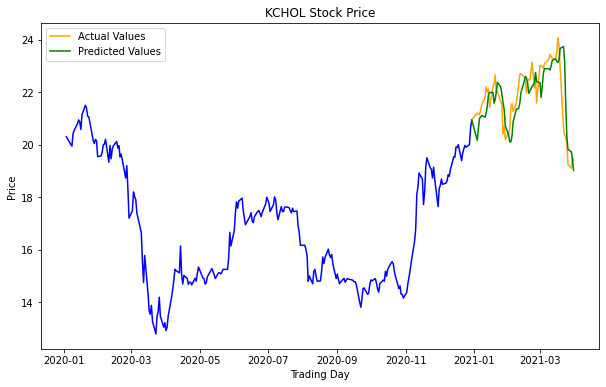

In [54]:
# Plot the Stock Price comparison

plot_comparison(actual = KCHOL_actual, predicted = KCHOL_predicted, string = 'KCHOL Stock Price')

#### M Stock

In [55]:
# Get the data for this stock

M_Xtrain, M_Xtest, M_ytrain, M_ytest = variables_model(n = 2)

In [56]:
# Fit the model

M_pred = model_fit(Xtr = M_Xtrain, ytr = M_ytrain, Xte = M_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 255us/sample - loss: 0.0032
Epoch 2/100
244/244 [==============================] - 0s 252us/sample - loss: 0.0031
Epoch 3/100
244/244 [==============================] - 0s 267us/sample - loss: 0.0033
Epoch 4/100
244/244 [==============================] - 0s 230us/sample - loss: 0.0033
Epoch 5/100
244/244 [==============================] - 0s 229us/sample - loss: 0.0034
Epoch 6/100
244/244 [==============================] - 0s 264us/sample - loss: 0.0031
Epoch 7/100
244/244 [==============================] - 0s 246us/sample - loss: 0.0032
Epoch 8/100
244/244 [==============================] - 0s 239us/sample - loss: 0.0030
Epoch 9/100
244/244 [==============================] - 0s 243us/sample - loss: 0.0036
Epoch 10/100
244/244 [==============================] - 0s 228us/sample - loss: 0.0028
Epoch 11/100
244/244 [==============================] - 0s 236us/sample - loss: 0.0028
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 248us/sample - loss: 0.0026
Epoch 96/100
244/244 [==============================] - 0s 246us/sample - loss: 0.0029
Epoch 97/100
244/244 [==============================] - 0s 239us/sample - loss: 0.0028
Epoch 98/100
244/244 [==============================] - 0s 233us/sample - loss: 0.0025
Epoch 99/100
244/244 [==============================] - 0s 234us/sample - loss: 0.0025
Epoch 100/100
244/244 [==============================] - 0s 228us/sample - loss: 0.0027


In [57]:
# Save the actual and predicted values in different data frames to plot

M_pred_prices = scaler_inverse(train_array = train['M_Price'].values, predictions = M_pred)

In [58]:
# Add the first column to the data frame that will store the predictions

predictions_df['M_Price'] = M_pred_prices

In [59]:
# Get the actual and predicted data as data frames for both

M_actual, M_predicted = df_merger(train_data = train['M_Price'], test_data = test['M_Price'], 
                                  pred_values = predictions_df['M_Price'])

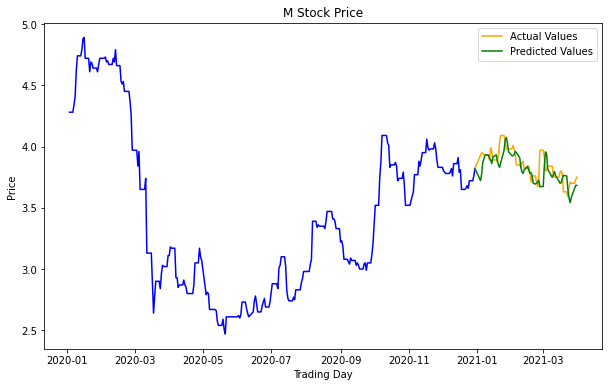

In [60]:
# Plot the Stock Price comparison

plot_comparison(actual = M_actual, predicted = M_predicted, string = 'M Stock Price')

#### BEEF Stock

In [61]:
# Get the data for this stock

BEEF_Xtrain, BEEF_Xtest, BEEF_ytrain, BEEF_ytest = variables_model(n = 3)

In [62]:
# Fit the model

BEEF_pred = model_fit(Xtr = BEEF_Xtrain, ytr = BEEF_ytrain, Xte = BEEF_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 261us/sample - loss: 0.0035
Epoch 2/100
244/244 [==============================] - 0s 253us/sample - loss: 0.0045
Epoch 3/100
244/244 [==============================] - 0s 262us/sample - loss: 0.0042
Epoch 4/100
244/244 [==============================] - 0s 251us/sample - loss: 0.0046
Epoch 5/100
244/244 [==============================] - 0s 266us/sample - loss: 0.0042
Epoch 6/100
244/244 [==============================] - 0s 238us/sample - loss: 0.0040
Epoch 7/100
244/244 [==============================] - 0s 260us/sample - loss: 0.0038
Epoch 8/100
244/244 [==============================] - 0s 257us/sample - loss: 0.0040
Epoch 9/100
244/244 [==============================] - 0s 238us/sample - loss: 0.0046
Epoch 10/100
244/244 [==============================] - 0s 257us/sample - loss: 0.0041
Epoch 11/100
244/244 [==============================] - 0s 258us/sample - loss: 0.0040
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 237us/sample - loss: 0.0036
Epoch 96/100
244/244 [==============================] - 0s 236us/sample - loss: 0.0027
Epoch 97/100
244/244 [==============================] - 0s 246us/sample - loss: 0.0029
Epoch 98/100
244/244 [==============================] - 0s 238us/sample - loss: 0.0035
Epoch 99/100
244/244 [==============================] - 0s 242us/sample - loss: 0.0036
Epoch 100/100
244/244 [==============================] - 0s 238us/sample - loss: 0.0035


In [63]:
# Save the actual and predicted values in different data frames to plot

BEEF_pred_prices = scaler_inverse(train_array = train['BEEF_Price'].values, predictions = BEEF_pred)

In [64]:
# Add the first column to the data frame that will store the predictions

predictions_df['BEEF_Price'] = BEEF_pred_prices

In [65]:
# Get the actual and predicted data as data frames for both

BEEF_actual, BEEF_predicted = df_merger(train_data = train['BEEF_Price'], test_data = test['BEEF_Price'], 
                                  pred_values = predictions_df['BEEF_Price'])

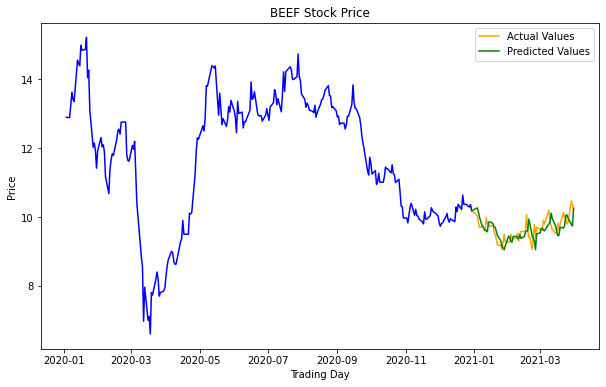

In [66]:
# Plot the Stock Price comparison

plot_comparison(actual = BEEF_actual, predicted = BEEF_predicted, string = 'BEEF Stock Price')

#### P Stock

In [67]:
# Get the data for this stock

P_Xtrain, P_Xtest, P_ytrain, P_ytest = variables_model(n = 4)

In [68]:
# Fit the model

P_pred = model_fit(Xtr = P_Xtrain, ytr = P_ytrain, Xte = P_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 250us/sample - loss: 0.0028
Epoch 2/100
244/244 [==============================] - 0s 244us/sample - loss: 0.0026
Epoch 3/100
244/244 [==============================] - 0s 242us/sample - loss: 0.0024
Epoch 4/100
244/244 [==============================] - 0s 243us/sample - loss: 0.0027
Epoch 5/100
244/244 [==============================] - 0s 239us/sample - loss: 0.0025
Epoch 6/100
244/244 [==============================] - 0s 243us/sample - loss: 0.0025
Epoch 7/100
244/244 [==============================] - 0s 237us/sample - loss: 0.0023
Epoch 8/100
244/244 [==============================] - 0s 255us/sample - loss: 0.0023
Epoch 9/100
244/244 [==============================] - 0s 231us/sample - loss: 0.0026
Epoch 10/100
244/244 [==============================] - 0s 229us/sample - loss: 0.0026
Epoch 11/100
244/244 [==============================] - 0s 229us/sample - loss: 0.0022
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 223us/sample - loss: 0.0021
Epoch 96/100
244/244 [==============================] - 0s 223us/sample - loss: 0.0025
Epoch 97/100
244/244 [==============================] - 0s 226us/sample - loss: 0.0027
Epoch 98/100
244/244 [==============================] - 0s 235us/sample - loss: 0.0026
Epoch 99/100
244/244 [==============================] - 0s 229us/sample - loss: 0.0025
Epoch 100/100
244/244 [==============================] - 0s 234us/sample - loss: 0.0023


In [69]:
# Save the actual and predicted values in different data frames to plot

P_pred_prices = scaler_inverse(train_array = train['P_Price'].values, predictions = P_pred)

In [70]:
# Add the first column to the data frame that will store the predictions

predictions_df['P_Price'] = P_pred_prices

In [71]:
# Get the actual and predicted data as data frames for both

P_actual, P_predicted = df_merger(train_data = train['P_Price'], test_data = test['P_Price'], 
                                  pred_values = predictions_df['P_Price'])

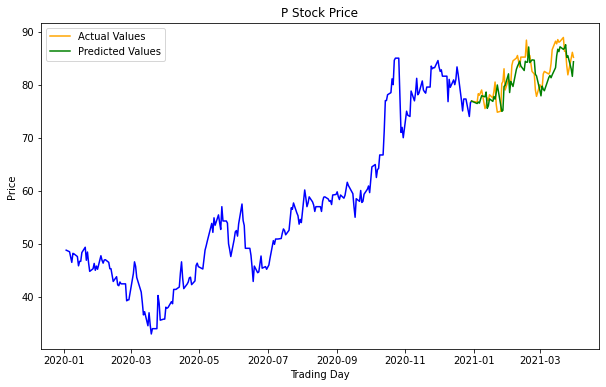

In [72]:
# Plot the Stock Price comparison

plot_comparison(actual = P_actual, predicted = P_predicted, string = 'P Stock Price')

#### C Stock

In [73]:
# Get the data for this stock

C_Xtrain, C_Xtest, C_ytrain, C_ytest = variables_model(n = 5)

In [74]:
# Fit the model

C_pred = model_fit(Xtr = C_Xtrain, ytr = C_ytrain, Xte = C_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 235us/sample - loss: 0.0019
Epoch 2/100
244/244 [==============================] - 0s 232us/sample - loss: 0.0019
Epoch 3/100
244/244 [==============================] - 0s 238us/sample - loss: 0.0015
Epoch 4/100
244/244 [==============================] - 0s 241us/sample - loss: 0.0019
Epoch 5/100
244/244 [==============================] - 0s 238us/sample - loss: 0.0015
Epoch 6/100
244/244 [==============================] - 0s 250us/sample - loss: 0.0019
Epoch 7/100
244/244 [==============================] - 0s 254us/sample - loss: 0.0018
Epoch 8/100
244/244 [==============================] - 0s 235us/sample - loss: 0.0017
Epoch 9/100
244/244 [==============================] - 0s 238us/sample - loss: 0.0017
Epoch 10/100
244/244 [==============================] - 0s 261us/sample - loss: 0.0016
Epoch 11/100
244/244 [==============================] - 0s 237us/sample - loss: 0.0019
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 271us/sample - loss: 0.0014
Epoch 96/100
244/244 [==============================] - 0s 259us/sample - loss: 0.0015
Epoch 97/100
244/244 [==============================] - 0s 260us/sample - loss: 0.0016
Epoch 98/100
244/244 [==============================] - 0s 250us/sample - loss: 0.0015
Epoch 99/100
244/244 [==============================] - 0s 269us/sample - loss: 0.0016
Epoch 100/100
244/244 [==============================] - 0s 253us/sample - loss: 0.0017


In [75]:
# Save the actual and predicted values in different data frames to plot

C_pred_prices = scaler_inverse(train_array = train['C_Price'].values, predictions = C_pred)

In [76]:
# Add the first column to the data frame that will store the predictions

predictions_df['C_Price'] = C_pred_prices

In [77]:
# Get the actual and predicted data as data frames for both

C_actual, C_predicted = df_merger(train_data = train['C_Price'], test_data = test['C_Price'], 
                                  pred_values = predictions_df['C_Price'])

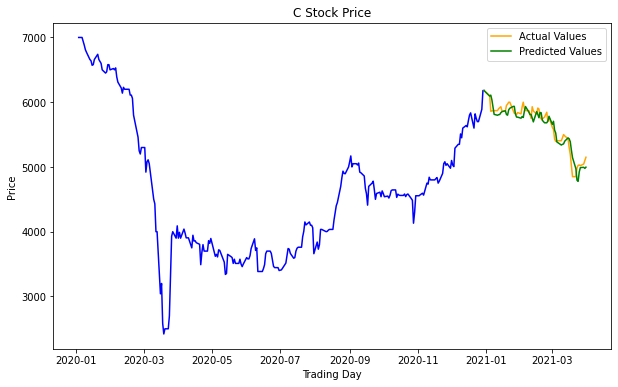

In [78]:
# Plot the Stock Price comparison

plot_comparison(actual = C_actual, predicted = C_predicted, string = 'C Stock Price')

#### IP Stock

In [79]:
# Get the data for this stock

IP_Xtrain, IP_Xtest, IP_ytrain, IP_ytest = variables_model(n = 6)

In [80]:
# Fit the model

IP_pred = model_fit(Xtr = IP_Xtrain, ytr = IP_ytrain, Xte = IP_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 272us/sample - loss: 0.0026
Epoch 2/100
244/244 [==============================] - 0s 255us/sample - loss: 0.0027
Epoch 3/100
244/244 [==============================] - 0s 247us/sample - loss: 0.0030
Epoch 4/100
244/244 [==============================] - 0s 241us/sample - loss: 0.0030
Epoch 5/100
244/244 [==============================] - 0s 239us/sample - loss: 0.0026
Epoch 6/100
244/244 [==============================] - 0s 235us/sample - loss: 0.0026
Epoch 7/100
244/244 [==============================] - 0s 246us/sample - loss: 0.0026
Epoch 8/100
244/244 [==============================] - 0s 236us/sample - loss: 0.0031
Epoch 9/100
244/244 [==============================] - 0s 230us/sample - loss: 0.0033
Epoch 10/100
244/244 [==============================] - 0s 230us/sample - loss: 0.0029
Epoch 11/100
244/244 [==============================] - 0s 236us/sample - loss: 0.0027
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 239us/sample - loss: 0.0026
Epoch 96/100
244/244 [==============================] - 0s 240us/sample - loss: 0.0027
Epoch 97/100
244/244 [==============================] - 0s 238us/sample - loss: 0.0027
Epoch 98/100
244/244 [==============================] - 0s 233us/sample - loss: 0.0025
Epoch 99/100
244/244 [==============================] - 0s 231us/sample - loss: 0.0028
Epoch 100/100
244/244 [==============================] - 0s 253us/sample - loss: 0.0027


In [81]:
# Save the actual and predicted values in different data frames to plot

IP_pred_prices = scaler_inverse(train_array = train['IP_Price'].values, predictions = IP_pred)

In [82]:
# Add the first column to the data frame that will store the predictions

predictions_df['IP_Price'] = IP_pred_prices

In [83]:
# Get the actual and predicted data as data frames for both

IP_actual, IP_predicted = df_merger(train_data = train['IP_Price'], test_data = test['IP_Price'], 
                                  pred_values = predictions_df['IP_Price'])

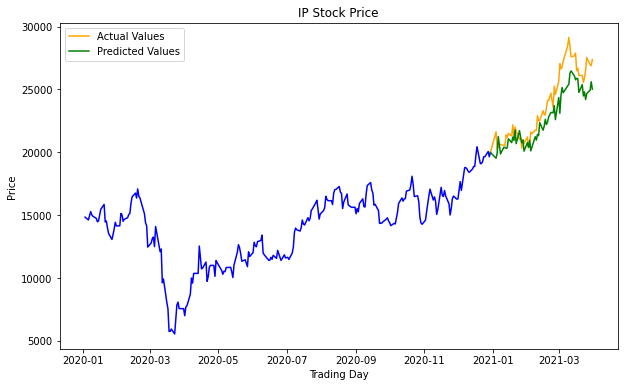

In [84]:
# Plot the Stock Price comparison

plot_comparison(actual = IP_actual, predicted = IP_predicted, string = 'IP Stock Price')

#### DS Stock

In [85]:
# Get the data for this stock

DS_Xtrain, DS_Xtest, DS_ytrain, DS_ytest = variables_model(n = 7)

In [86]:
# Fit the model

DS_pred = model_fit(Xtr = DS_Xtrain, ytr = DS_ytrain, Xte = DS_Xtest)

Train on 244 samples
Epoch 1/100
244/244 [==============================] - 0s 252us/sample - loss: 0.0030
Epoch 2/100
244/244 [==============================] - 0s 240us/sample - loss: 0.0030
Epoch 3/100
244/244 [==============================] - 0s 247us/sample - loss: 0.0029
Epoch 4/100
244/244 [==============================] - 0s 233us/sample - loss: 0.0024
Epoch 5/100
244/244 [==============================] - 0s 235us/sample - loss: 0.0025
Epoch 6/100
244/244 [==============================] - 0s 240us/sample - loss: 0.0023
Epoch 7/100
244/244 [==============================] - 0s 239us/sample - loss: 0.0024
Epoch 8/100
244/244 [==============================] - 0s 236us/sample - loss: 0.0029
Epoch 9/100
244/244 [==============================] - 0s 256us/sample - loss: 0.0027
Epoch 10/100
244/244 [==============================] - 0s 285us/sample - loss: 0.0026
Epoch 11/100
244/244 [==============================] - 0s 233us/sample - loss: 0.0028
Epoch 12/100
244/244 [=========

244/244 [==============================] - 0s 234us/sample - loss: 0.0027
Epoch 96/100
244/244 [==============================] - 0s 236us/sample - loss: 0.0025
Epoch 97/100
244/244 [==============================] - 0s 244us/sample - loss: 0.0026
Epoch 98/100
244/244 [==============================] - 0s 239us/sample - loss: 0.0024
Epoch 99/100
244/244 [==============================] - 0s 243us/sample - loss: 0.0021
Epoch 100/100
244/244 [==============================] - 0s 247us/sample - loss: 0.0026


In [87]:
# Save the actual and predicted values in different data frames to plot

DS_pred_prices = scaler_inverse(train_array = train['DS_Price'].values, predictions = DS_pred)

In [88]:
# Add the first column to the data frame that will store the predictions

predictions_df['DS_Price'] = DS_pred_prices

In [89]:
# Get the actual and predicted data as data frames for both

DS_actual, DS_predicted = df_merger(train_data = train['DS_Price'], test_data = test['DS_Price'], 
                                  pred_values = predictions_df['DS_Price'])

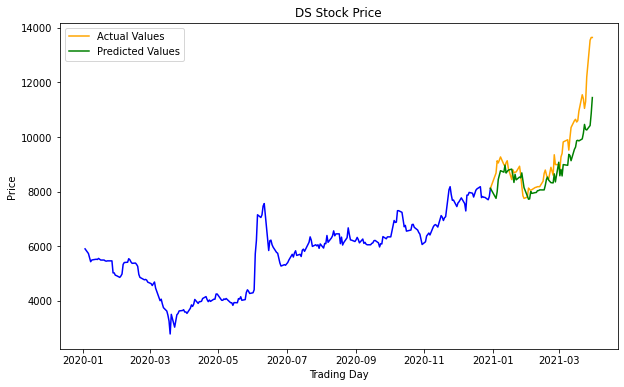

In [90]:
# Plot the Stock Price comparison

plot_comparison(actual = DS_actual, predicted = DS_predicted, string = 'DS Stock Price')

### SARIMAX

In [91]:
def arima_selection(values):
    model_autoARIMA = auto_arima(y = values, x = None, start_p = 1, d = None, start_q = 1, max_p = 11, max_d = 11,
                                max_q = 11, start_P = 1, D = None, start_Q = 1, max_P = 11, max_D = 11, max_Q = 11,
                                max_order = None, m = 5, alpha = 0.05, n_jobs = -1)
    return model_autoARIMA, model_autoARIMA.summary()


In [92]:
def model_fit_arima(df, col, order):
    
    warnings.filterwarnings('ignore')

    train_values = df['2020'][col].values

    test_values = df['2021'][col].values
    
    predictions = np.empty(shape = len(test_values))
    
    for i in range(len(test_values)):
        model = ARIMA(endog = train_values, order = order)
        model = model.fit()
        output = model.forecast()
        p = output[0]
        predictions[i] = p
        obs = test_values[i]
        train_values = np.append(train_values, obs)
        
    return predictions
        

In [93]:
pred_arima = pd.DataFrame()

pred_arima['Date'] = test.index

pred_arima.set_index('Date', inplace = True)

#### S Stock

In [94]:
# Get the best order to train the ARIMA model

arima_selection(values = train['S_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -747.842
 Date:                Sun, 13 Jun 2021   AIC                           1497.685
 Time:                        14:02:44   BIC                           1501.202
 Sample:                             0   HQIC                          1499.101
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2        23.7810    

In [99]:
stock_prices.isna().sum()

S_Price         0
KCHOL_Price     9
M_Price        77
BEEF_Price     13
P_Price        22
C_Price        20
IP_Price       10
DS_Price       14
dtype: int64

In [100]:
# Use the function to predict the outcomes

S_pred_arima = model_fit_arima(df = stock_prices_daily, col = 'S_Price', order = (0,1,0))

In [101]:
# Save the predicted prices in a new column

pred_arima['S_Price'] = S_pred_arima

In [102]:
# Get the actual and predicted data as data frames for both

S_actual_arima, S_predicted_arima = df_merger(train_data = train['S_Price'], 
                                                      test_data = test['S_Price'], 
                                                      pred_values = pred_arima['S_Price'])

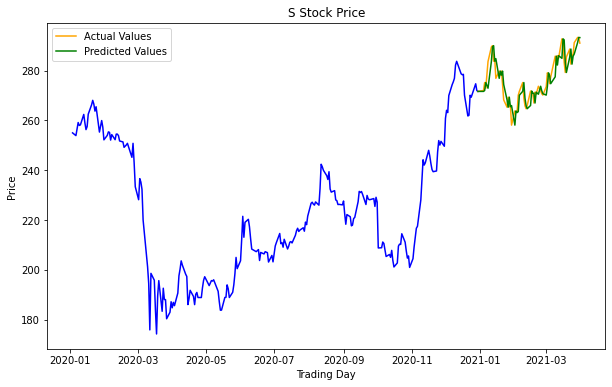

In [103]:
# Plot the Stock Price comparison

plot_comparison(actual = S_actual_arima, predicted = S_predicted_arima, string = 'S Stock Price')

#### KCHOL Stock

In [104]:
# Get the best order to train the ARIMA model

arima_selection(values = train['KCHOL_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -126.205
 Date:                Sun, 13 Jun 2021   AIC                            254.410
 Time:                        14:09:40   BIC                            257.927
 Sample:                             0   HQIC                           255.826
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         0.1613    

In [105]:
# Use the function to predict the outcomes

KCHOL_pred_arima = model_fit_arima(stock_prices_daily, col = 'KCHOL_Price', order = (0,1,0))

In [106]:
# Save the predicted prices in a new column

pred_arima['KCHOL_Price'] = KCHOL_pred_arima

In [107]:
# Get the actual and predicted data as data frames for both

KCHOL_actual_arima, KCHOL_predicted_arima = df_merger(train_data = train['KCHOL_Price'], 
                                                      test_data = test['KCHOL_Price'], 
                                                      pred_values = pred_arima['KCHOL_Price'])

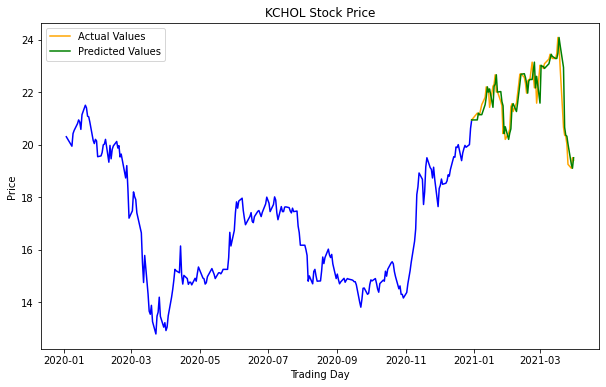

In [108]:
# Plot the Stock Price comparison

plot_comparison(actual = KCHOL_actual_arima, predicted = KCHOL_predicted_arima, string = 'KCHOL Stock Price')

#### M Stock

In [109]:
# Get the best order to train the ARIMA model

arima_selection(values = train['M_Price'])

(ARIMA(order=(0, 1, 4), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 4)   Log Likelihood                 252.477
 Date:                Sun, 13 Jun 2021   AIC                           -494.954
 Time:                        14:10:13   BIC                           -477.366
 Sample:                             0   HQIC                          -487.875
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ma.L1          0.0498    

In [110]:
# Use the function to predict the outcomes

M_pred_arima = model_fit_arima(stock_prices_daily, col = 'M_Price', order = (0,1,4))

In [111]:
pred_arima['M_Price'] = M_pred_arima

In [112]:
# Get the actual and predicted data as data frames for both

M_actual_arima, M_predicted_arima = df_merger(train_data = train['M_Price'], test_data = test['M_Price'], 
                                  pred_values = pred_arima['M_Price'])

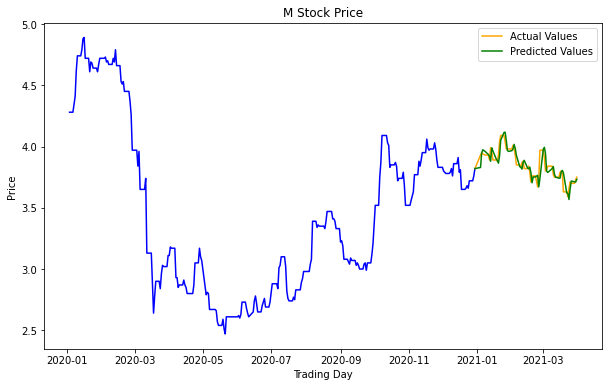

In [113]:
# Plot the Stock Price comparison

plot_comparison(actual = M_actual_arima, predicted = M_predicted_arima, string = 'M Stock Price')

#### BEEF Stock

In [114]:
# Get the best order to train the ARIMA model

arima_selection(values = train['BEEF_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -127.797
 Date:                Sun, 13 Jun 2021   AIC                            257.595
 Time:                        14:10:37   BIC                            261.112
 Sample:                             0   HQIC                           259.011
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         0.1634    

In [115]:
# Use the function to predict the outcomes

BEEF_pred_arima = model_fit_arima(stock_prices_daily, col = 'BEEF_Price', order = (0,1,0))

In [116]:
# Save prices in a column of the data frame

pred_arima['BEEF_Price'] = BEEF_pred_arima

In [117]:
# Get the actual and predicted data as data frames for both

BEEF_actual_arima, BEEF_predicted_arima = df_merger(train_data = train['BEEF_Price'], test_data = test['BEEF_Price'], 
                                  pred_values = pred_arima['BEEF_Price'])

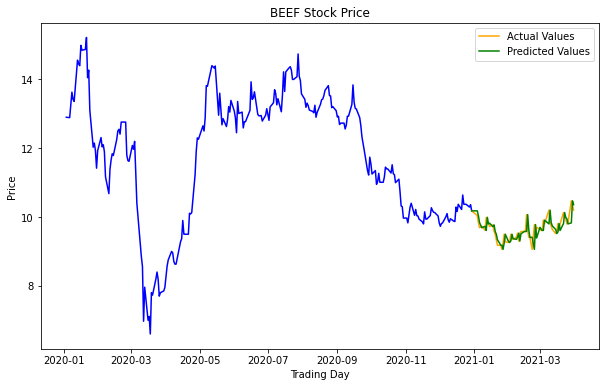

In [118]:
# Plot the Stock Price comparison

plot_comparison(actual = BEEF_actual_arima, predicted = BEEF_predicted_arima, string = 'BEEF Stock Price')

#### P Stock

In [119]:
# Get the best order to train the ARIMA model

arima_selection(values = train['P_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -522.848
 Date:                Sun, 13 Jun 2021   AIC                           1047.695
 Time:                        14:10:44   BIC                           1051.213
 Sample:                             0   HQIC                          1049.111
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         3.9028    

In [120]:
# Use the function to predict the outcomes

P_pred_arima = model_fit_arima(stock_prices_daily, col = 'P_Price', order = (0,1,0))

In [121]:
pred_arima['P_Price'] = P_pred_arima

In [122]:
# Get the actual and predicted data as data frames for both

P_actual_arima, P_predicted_arima = df_merger(train_data = train['P_Price'], test_data = test['P_Price'], 
                                  pred_values = pred_arima['P_Price'])

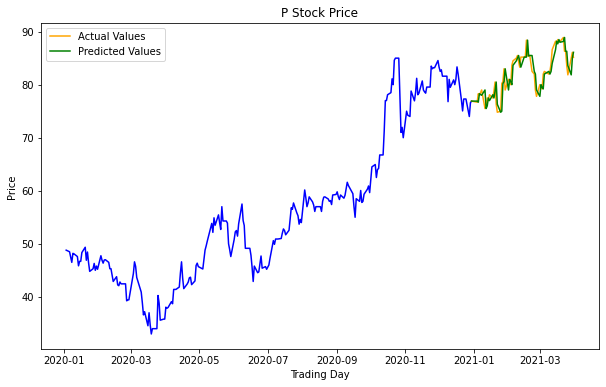

In [123]:
# Plot the Stock Price comparison

plot_comparison(actual = P_actual_arima, predicted = P_predicted_arima, string = 'P Stock Price')

#### C Stock

In [124]:
# Get the best order to train the ARIMA model

arima_selection(values = train['C_Price'])

(ARIMA(order=(2, 2, 1), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1593.351
 Date:                Sun, 13 Jun 2021   AIC                           3194.701
 Time:                        14:11:04   BIC                           3208.755
 Sample:                             0   HQIC                          3200.359
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1          0.0525    

In [125]:
# Use the function to predict the outcomes

C_pred_arima = model_fit_arima(stock_prices_daily, col = 'C_Price', order = (2,2,1))


In [126]:
# Save results in the predicted data frame

pred_arima['C_Price'] = C_pred_arima

In [127]:
# Get the actual and predicted data as data frames for both

C_actual_arima, C_predicted_arima = df_merger(train_data = train['C_Price'], test_data = test['C_Price'], 
                                  pred_values = pred_arima['C_Price'])

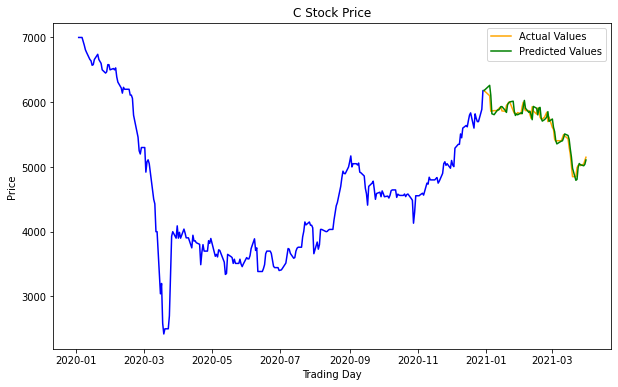

In [128]:
# Plot the Stock Price comparison

plot_comparison(actual = C_actual_arima, predicted = C_predicted_arima, string = 'C Stock Price')

#### IP Stock

In [129]:
# Get the best order to train the ARIMA model

arima_selection(values = train['IP_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 1, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                       SARIMAX Results                                      
 Dep. Variable:                                   y   No. Observations:                  250
 Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood               -1964.063
 Date:                             Sun, 13 Jun 2021   AIC                           3932.126
 Time:                                     14:11:23   BIC                           3939.161
 Sample:                                          0   HQIC                          3934.957
                                              - 250                                         
 Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 -

In [130]:
# Use the function to predict the outcomes

IP_pred_arima = model_fit_arima(stock_prices_daily, col = 'IP_Price', order = (0,1,0))


In [131]:
pred_arima['IP_Price'] = IP_pred_arima

In [132]:
# Get the actual and predicted data as data frames for both

IP_actual_arima, IP_predicted_arima = df_merger(train_data = train['IP_Price'], test_data = test['IP_Price'], 
                                  pred_values = pred_arima['IP_Price'])

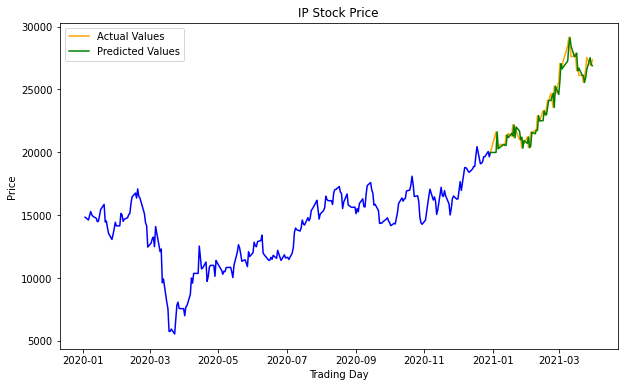

In [133]:
# Plot the Stock Price comparison

plot_comparison(actual = IP_actual_arima, predicted = IP_predicted_arima, string = 'IP Stock Price')

#### DS Stock

In [134]:
# Get the best order to train the ARIMA model

arima_selection(values = train['DS_Price'])

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  250
 Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1711.671
 Date:                Sun, 13 Jun 2021   AIC                           3425.341
 Time:                        14:11:26   BIC                           3428.859
 Sample:                             0   HQIC                          3426.757
                                 - 250                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2      5.475e+04   1

In [135]:
# Use the function to predict the outcomes

DS_pred_arima = model_fit_arima(stock_prices_daily, col = 'DS_Price', order = (0,1,0))


In [136]:
pred_arima['DS_Price'] = DS_pred_arima

In [137]:
# Get the actual and predicted data as data frames for both

DS_actual_arima, DS_predicted_arima = df_merger(train_data = train['DS_Price'], test_data = test['DS_Price'], 
                                  pred_values = pred_arima['DS_Price'])

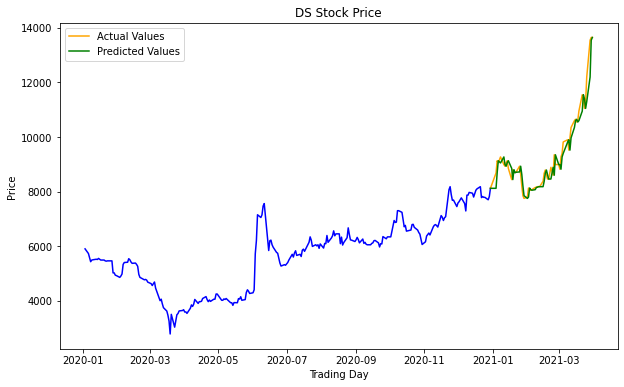

In [138]:
# Plot the Stock Price comparison

plot_comparison(actual = DS_actual_arima, predicted = DS_predicted_arima, string = 'DS Stock Price')

## Model Evaluation

In [139]:
def capital_gain_predicted_prices(df1, df2):
    # Define the total capital gain as the final value minus the initial value divided by the initial value
    actual_returns = (df1[-1] - df1[0])/df1[0]
    # Predicted returns 
    predicted_returns = (df2[-1] - df2[0])/df2[0]
    # Show the value as percentage
    actual_returns = round(actual_returns*100,2)
    predicted_returns = round(predicted_returns*100, 2)
    print('The actual returns had a value of {}% and the predicted returns had a value {}%'.format(actual_returns, 
                                                                                                predicted_returns))

In [140]:
# Define a function for the Bollinger brands

def bollinger_bands(df, col, p, std):
    # Create a new data frame just to use in the function to plot the upper, and lower bound with the moving average
    # and the closing price
    bollinger_df = pd.DataFrame()
    #Establish the serie to use the rolling function
    bollinger_df[col] = df[col].astype(int)
    # Define number of periods
    period = p
    # Apply the rolling function for the moving average
    bollinger_df['SMA'] = bollinger_df.rolling(window = period).mean()
    # Calculate the Standard Deviation
    bollinger_df['std'] = bollinger_df[col].rolling(window = period).std()
    # Establish the upper border
    bollinger_df['upper'] = bollinger_df['SMA'] + (bollinger_df['std'] * std)
    # Establish the lower border
    bollinger_df['lower'] = bollinger_df['SMA'] - (bollinger_df['std'] * std)
    
    # Define the conditions to make the buy/sell recommendations
    buy_signal = []
    sell_signal = []
    
    # Start a for loop
    for i in range(len(bollinger_df[col])):
        if bollinger_df[col][i] > bollinger_df['upper'][i]: # This is the condition for sell recommendation 
            buy_signal.append(np.nan)
            sell_signal.append(bollinger_df[col][i])
        elif bollinger_df[col][i] < bollinger_df['lower'][i]: # This is the condition for buy recommendation
            buy_signal.append(bollinger_df[col][i])
            sell_signal.append(np.nan)
        else: # If none of the conditions are met, then no recommendation is given
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
    # Add the recommendations as a columns in the data frame
    bollinger_df['buy'] = buy_signal
    bollinger_df['sell'] = sell_signal
    
    # Plot the bollinger bands in order to make the sell and buy recommendations
    fig = plt.figure(figsize = (20,12))
    # Add subplot
    ax = fig.add_subplot(1,1,1)
    # Get the index
    x_axis = bollinger_df.index
    # Plot the shade area between the upper and the lower bound
    ax.fill_between(x_axis, bollinger_df['upper'], bollinger_df['lower'], color = 'grey')
    # Plot the closing price, moving average and buy and sell recommendations
    ax.plot(x_axis, bollinger_df[col], color = 'gold', lw = 3, label = 'Price')
    ax.plot(x_axis, bollinger_df['SMA'], color = 'blue', lw = 3, label = 'Moving Averag')
    ax.scatter(x_axis, bollinger_df['buy'], color = 'green', lw = 3, marker = '^', label = 'Buy', s = 100)
    ax.scatter(x_axis, bollinger_df['sell'], color = 'red', lw = 3, marker = 'v', label = 'Sell', s = 100)
    # Set the axis
    ax.set_title('Bollinger bands for {}'.format(col))
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.xticks(rotation = 45)
    ax.legend(loc = (1.02, 0.6))
    return plt.show()


In [141]:
# Get a data frame that stores the train and predicted data frame for the bollinger bands

predicted_df = merge_df(df1 = S_predicted, df2 = KCHOL_predicted, df3 = M_predicted, df4 = BEEF_predicted, 
                        df5 = P_predicted, df6 = C_predicted, df7 = IP_predicted, df8 = DS_predicted)

### LSTM

#### S_Stock

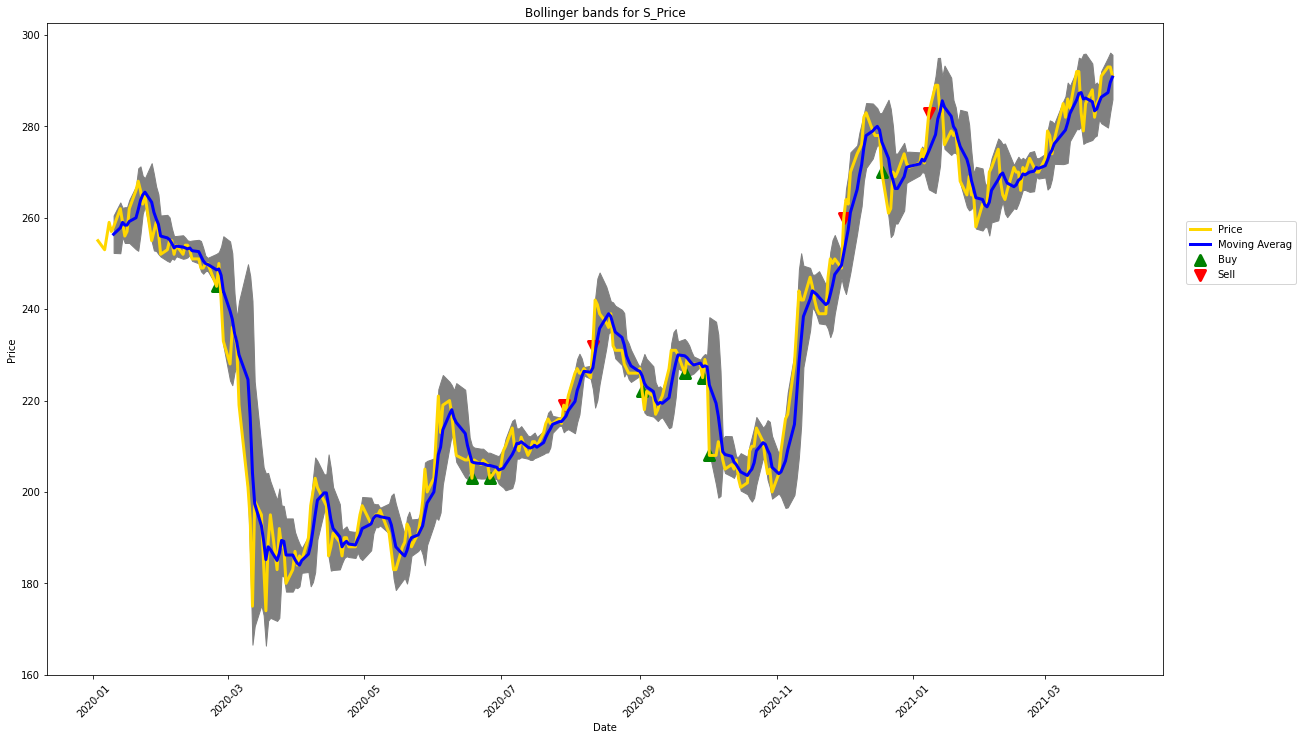

In [142]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'S_Price', p = 5, std = 1.7)

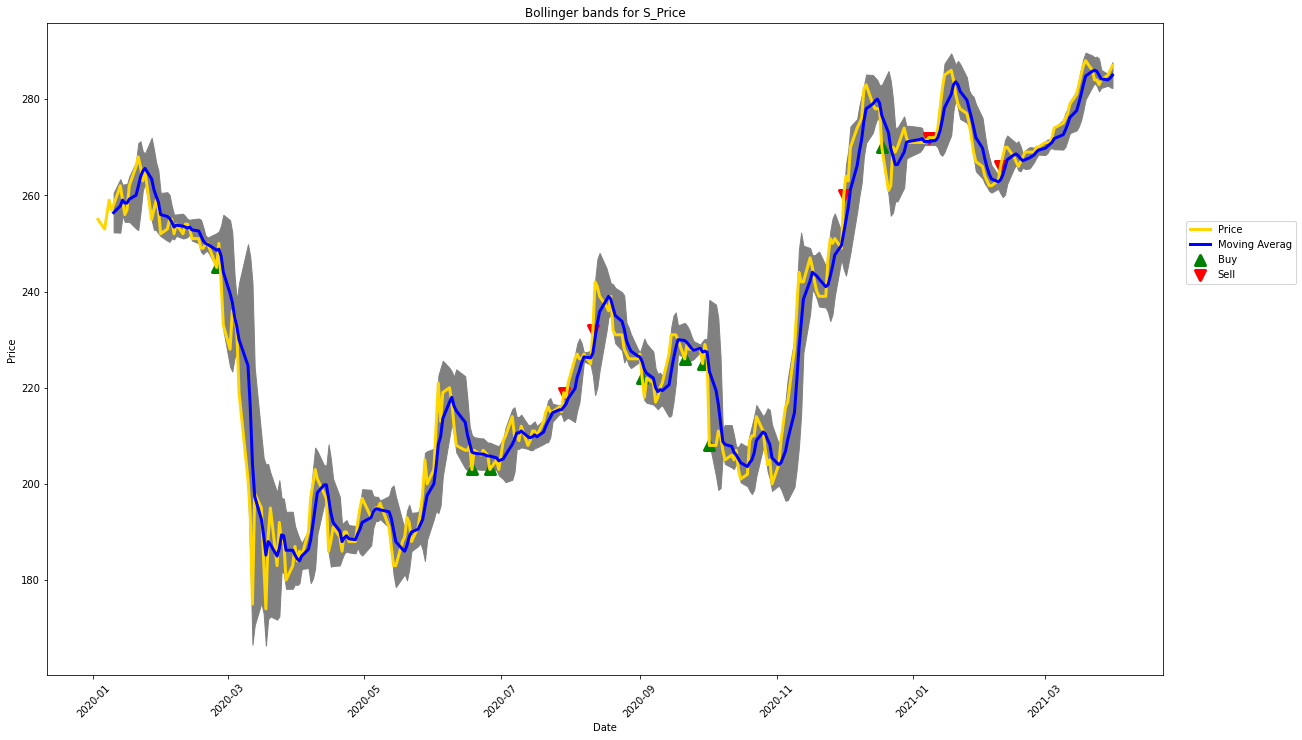

In [143]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'S_Price', p = 5, std = 1.7)

In [144]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['S_Price'], df2 = predictions_df['S_Price'])

The actual returns had a value of 6.99% and the predicted returns had a value 6.1%


#### KCHOL Stock

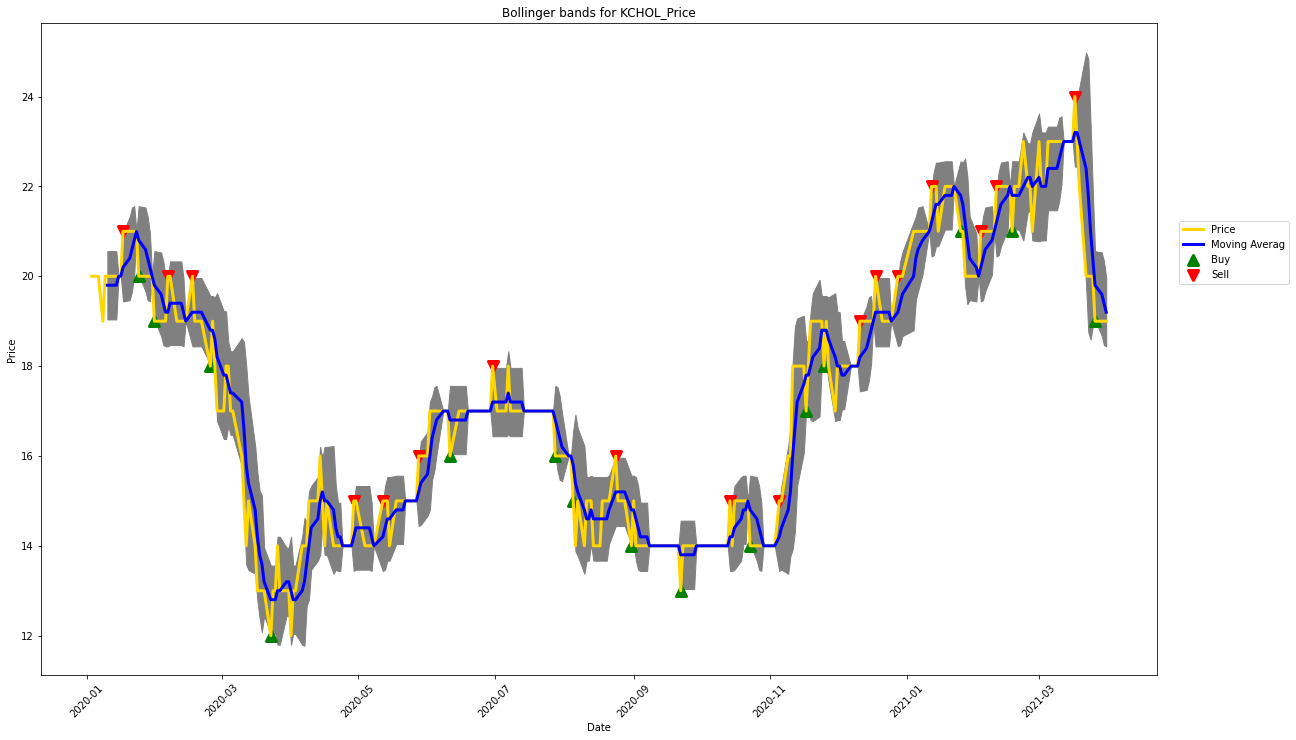

In [145]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'KCHOL_Price', p = 5, std = 1.7)

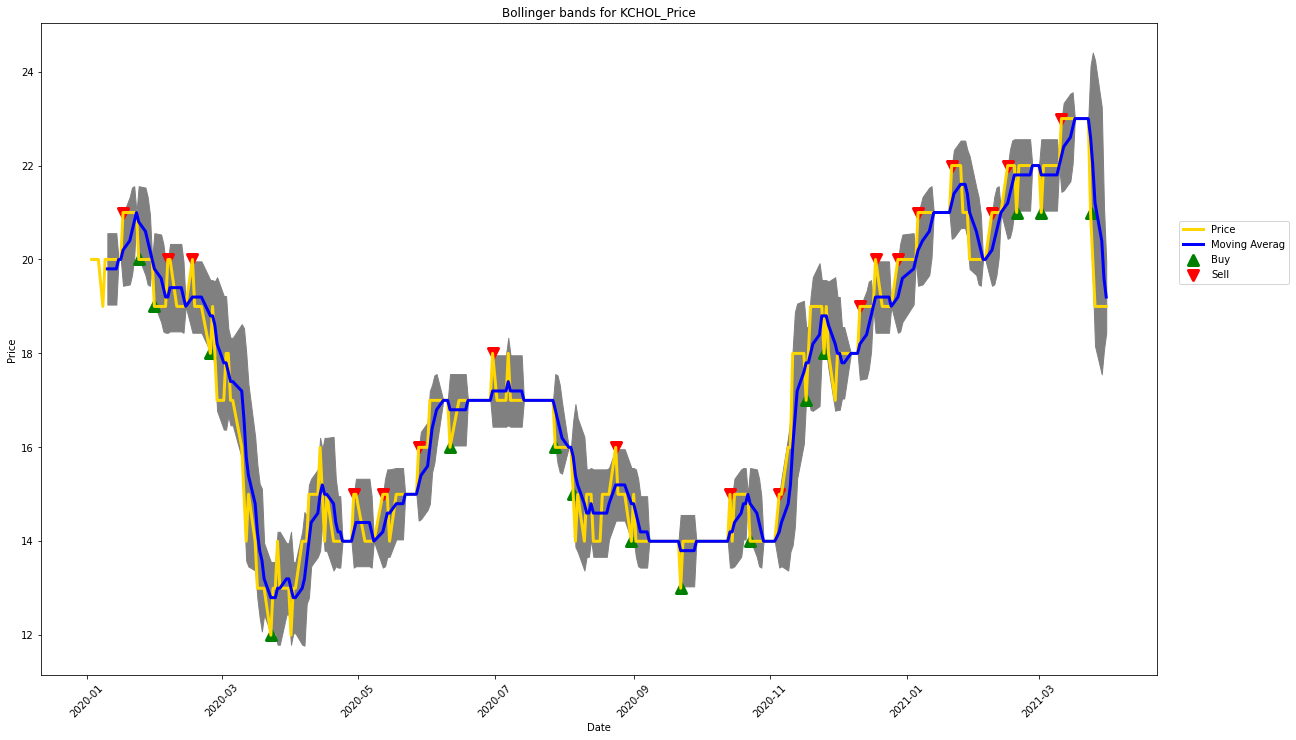

In [146]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'KCHOL_Price', p = 5, std = 1.7)

In [147]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['KCHOL_Price'], df2 = predictions_df['KCHOL_Price'])

The actual returns had a value of -8.44% and the predicted returns had a value -5.71%


#### M Stock

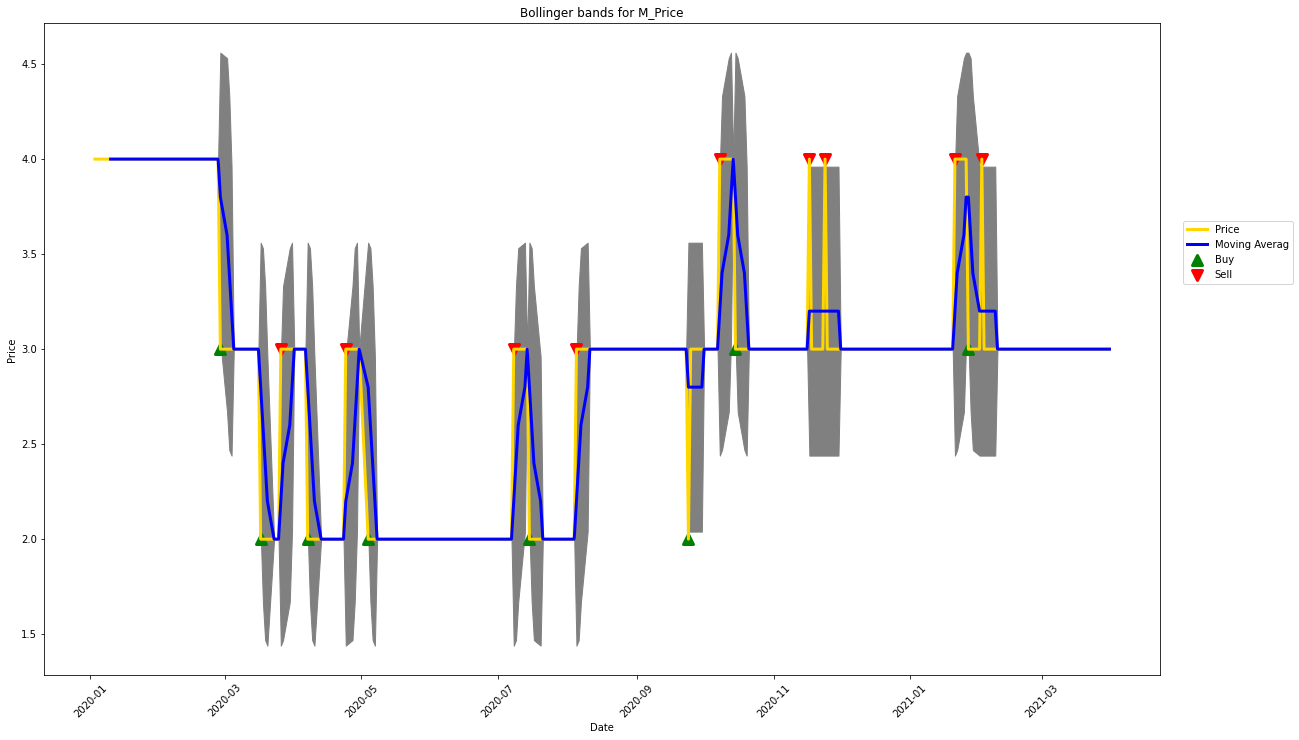

In [148]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'M_Price', p = 5, std = 1.7)

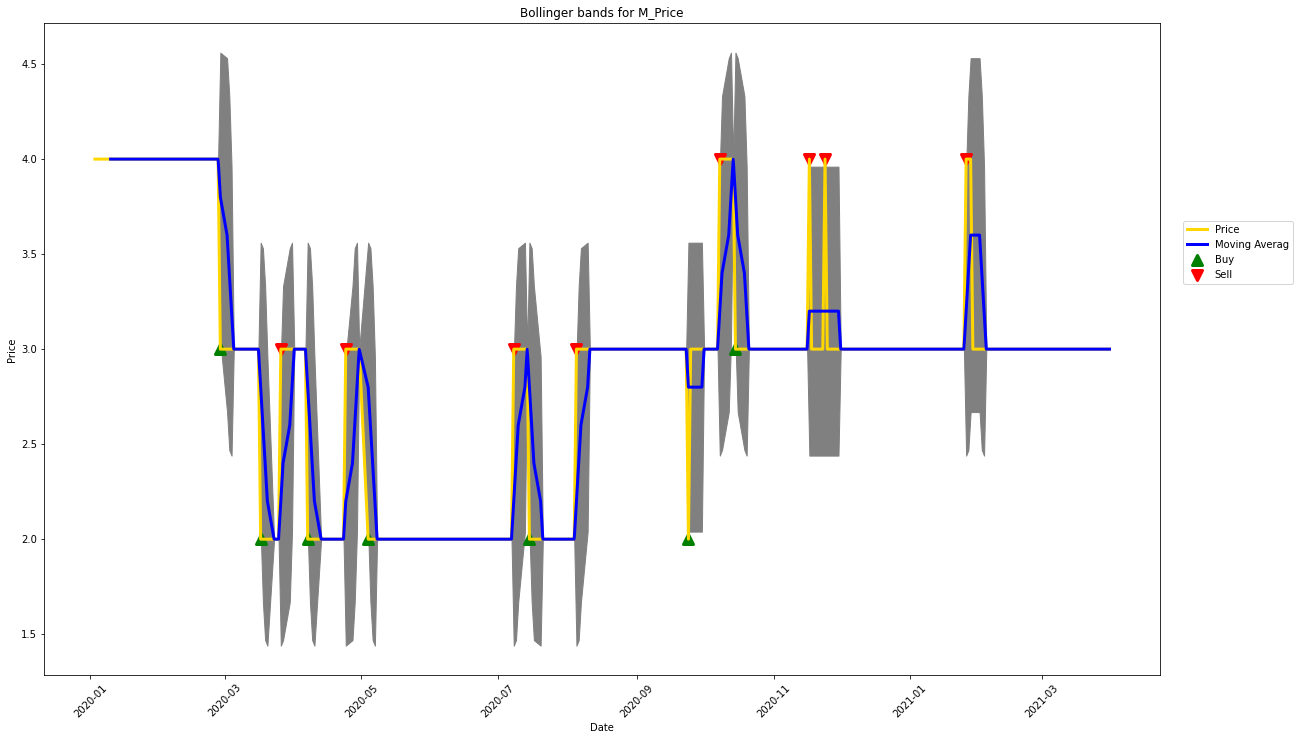

In [149]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'M_Price', p = 5, std = 1.7)

In [150]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['M_Price'], df2 = predictions_df['M_Price'])

The actual returns had a value of -4.58% and the predicted returns had a value -1.03%


#### BEEF Stock

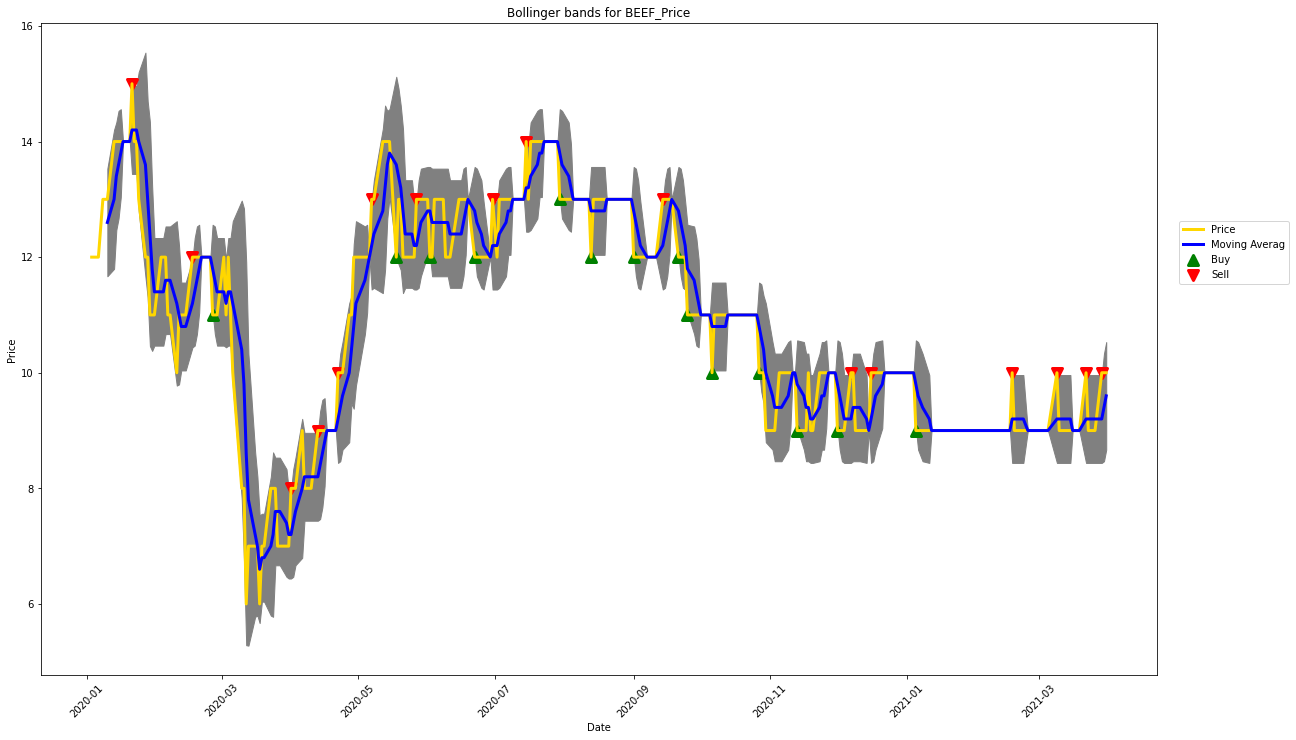

In [151]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'BEEF_Price', p = 5, std = 1.7)

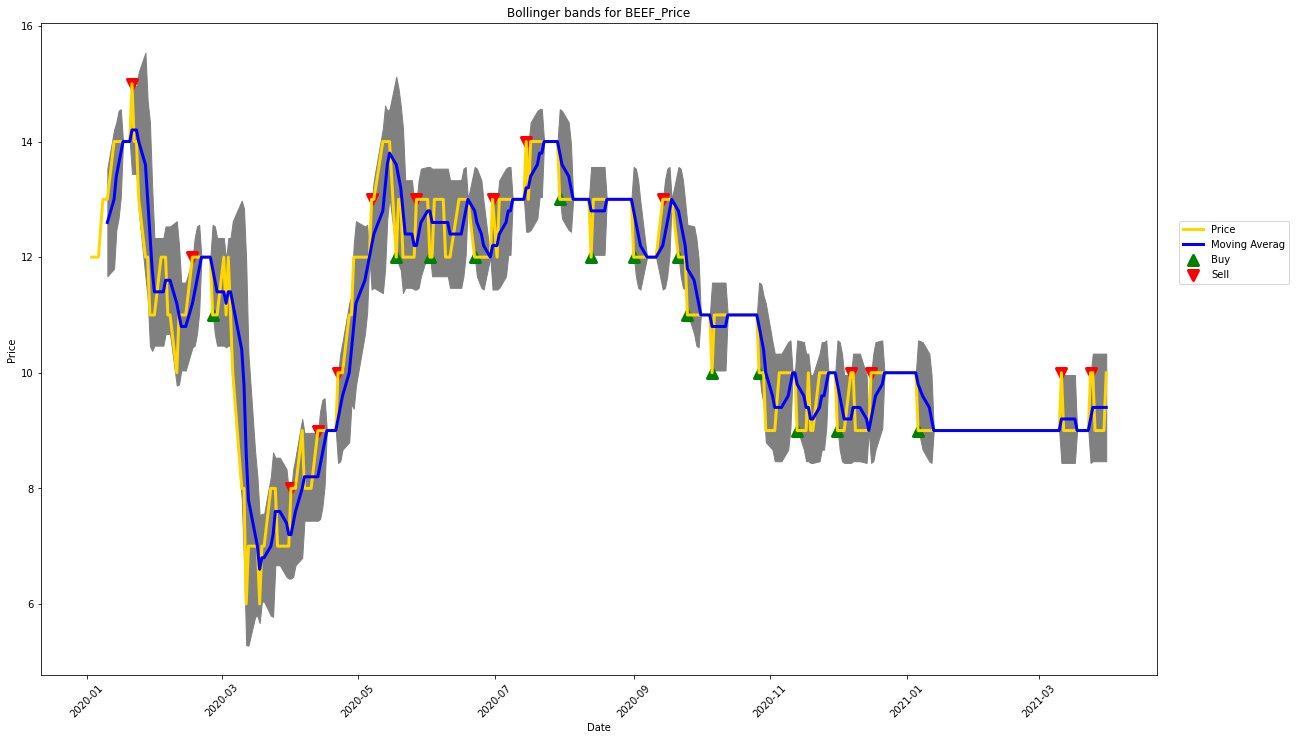

In [152]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'BEEF_Price', p = 5, std = 1.7)

In [153]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['BEEF_Price'], df2 = predictions_df['BEEF_Price'])

The actual returns had a value of 1.59% and the predicted returns had a value -0.09%


#### P Stock

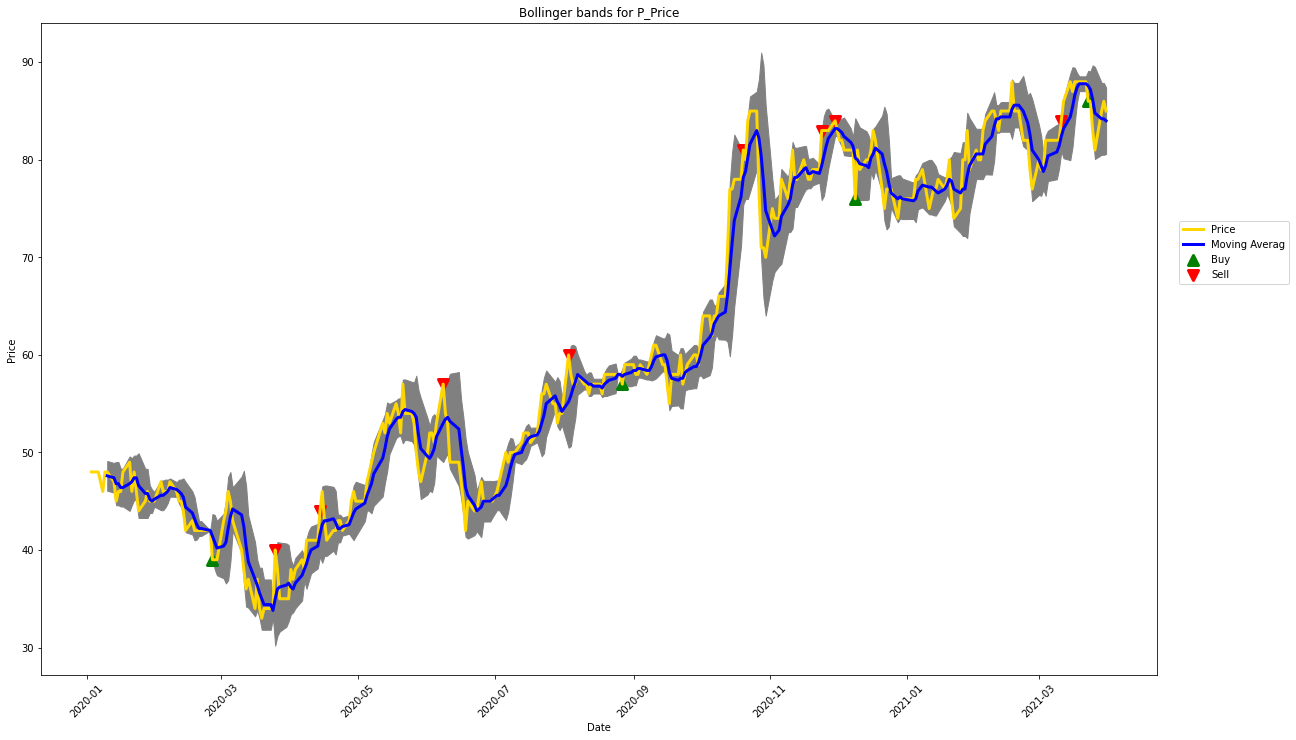

In [154]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'P_Price', p = 5, std = 1.7)

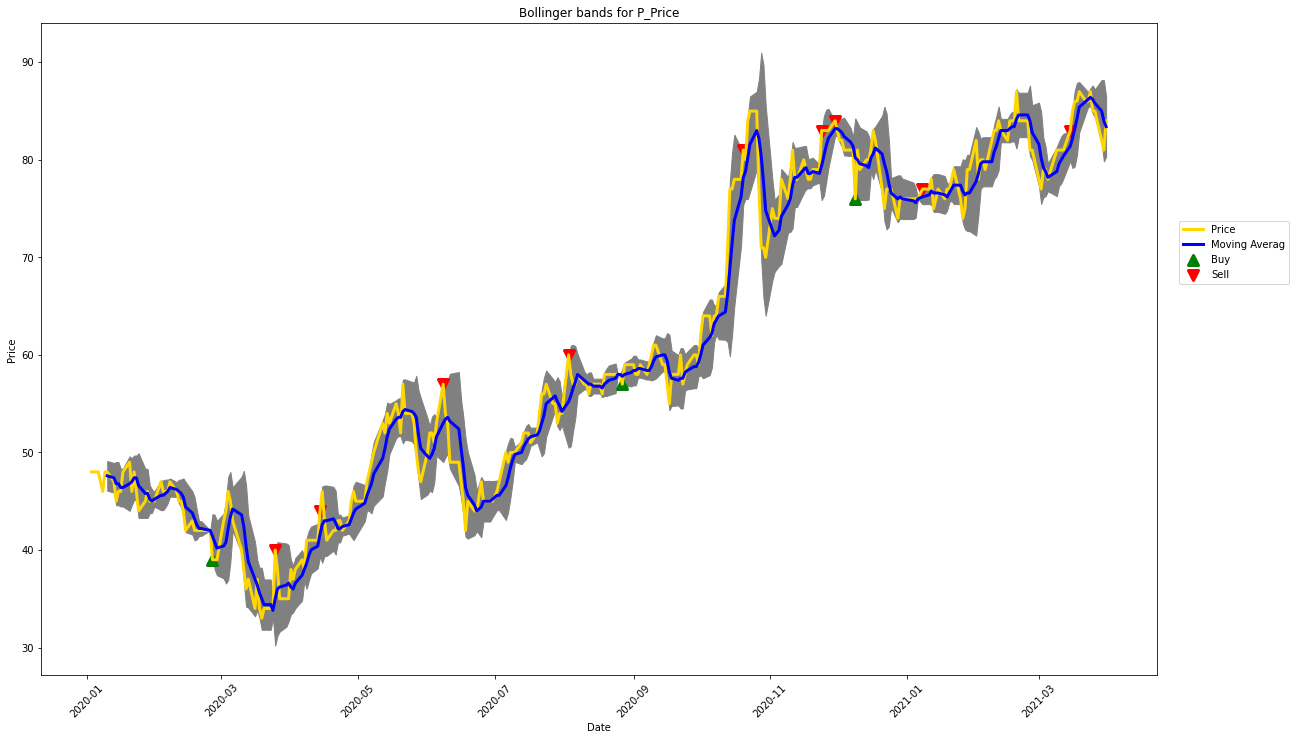

In [155]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'P_Price', p = 5, std = 1.7)

In [156]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['P_Price'], df2 = predictions_df['P_Price'])

The actual returns had a value of 11.02% and the predicted returns had a value 10.3%


#### C Stock

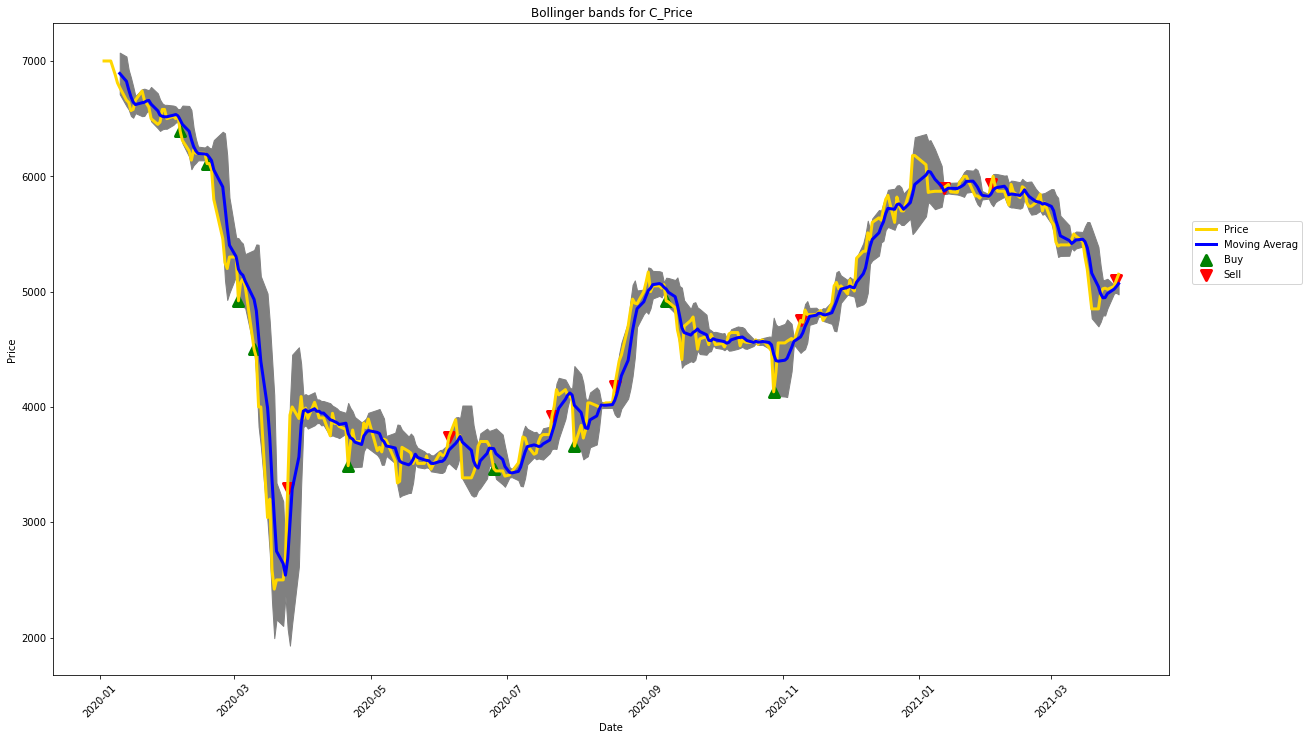

In [157]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'C_Price', p = 5, std = 1.7)

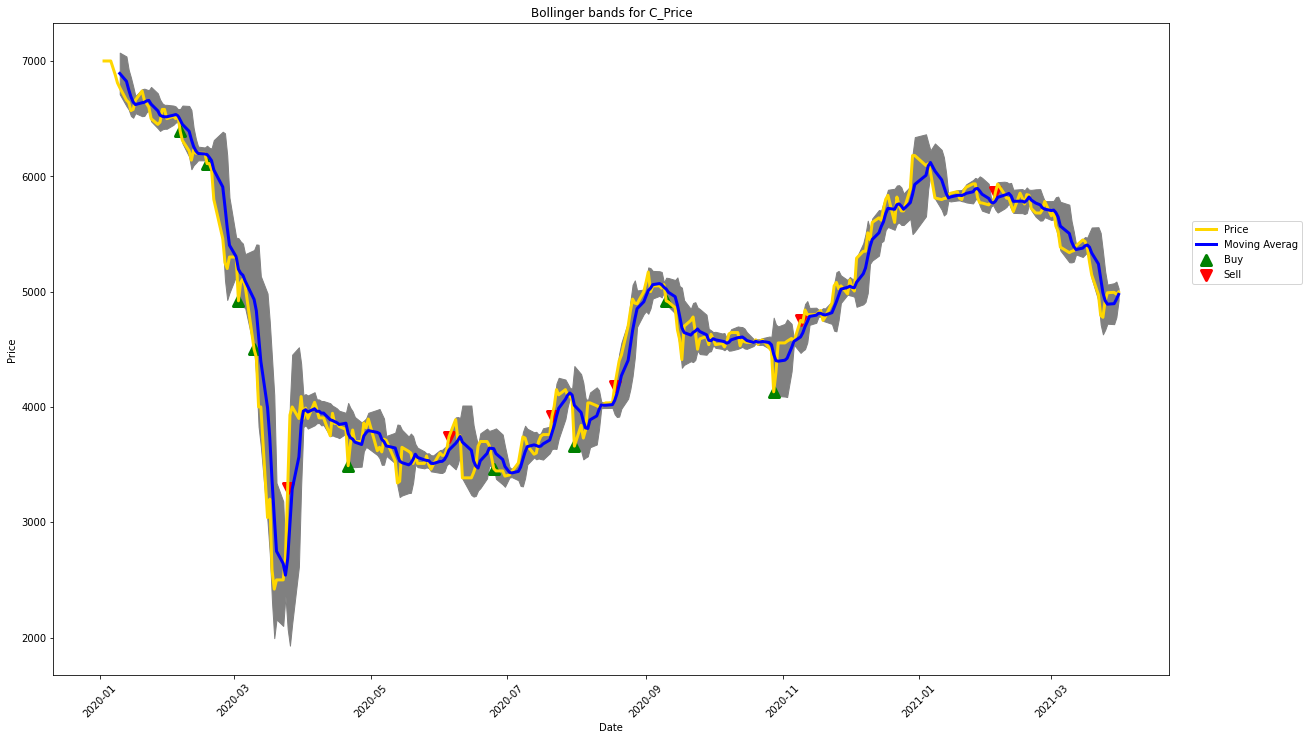

In [158]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'C_Price', p = 5, std = 1.7)

In [159]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['C_Price'], df2 = predictions_df['C_Price'])

The actual returns had a value of -15.57% and the predicted returns had a value -18.0%


#### IP Stock

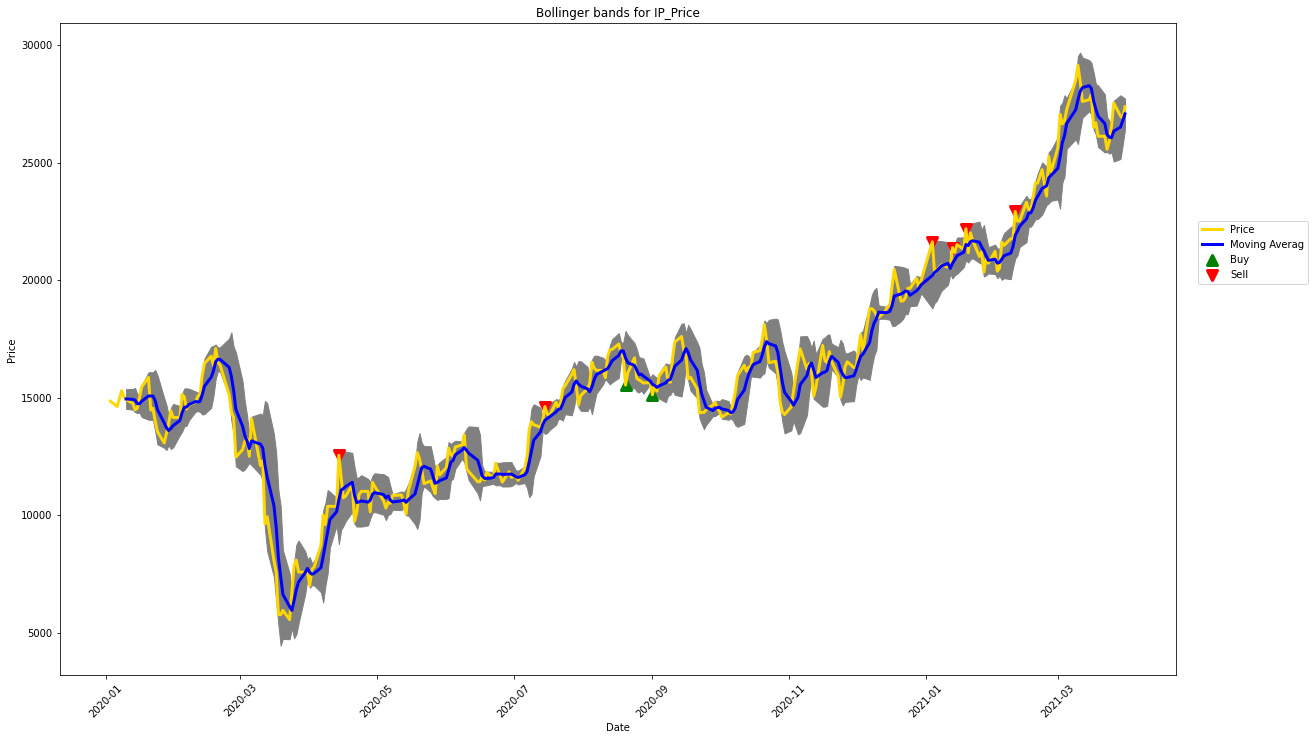

In [160]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'IP_Price', p = 5, std = 1.7)

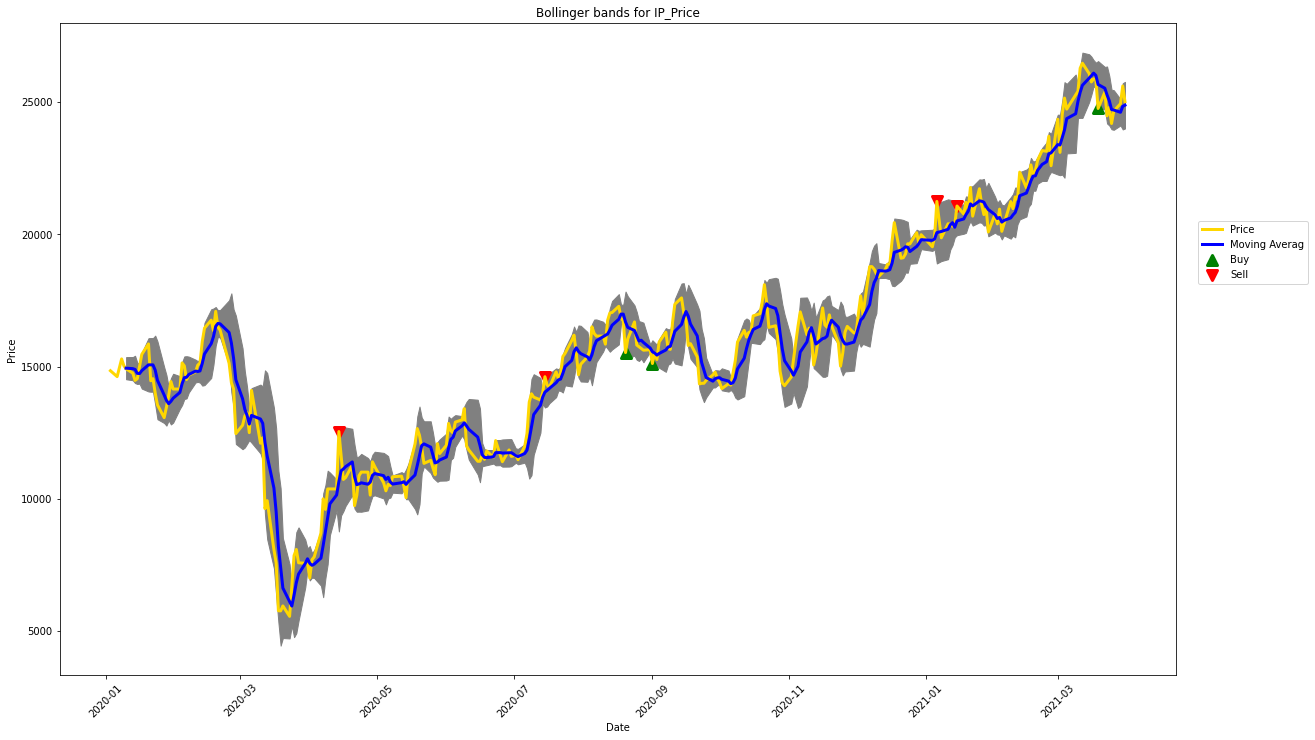

In [161]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'IP_Price', p = 5, std = 1.7)

In [162]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['IP_Price'], df2 = predictions_df['IP_Price'])

The actual returns had a value of 26.56% and the predicted returns had a value 28.12%


#### DS Stock

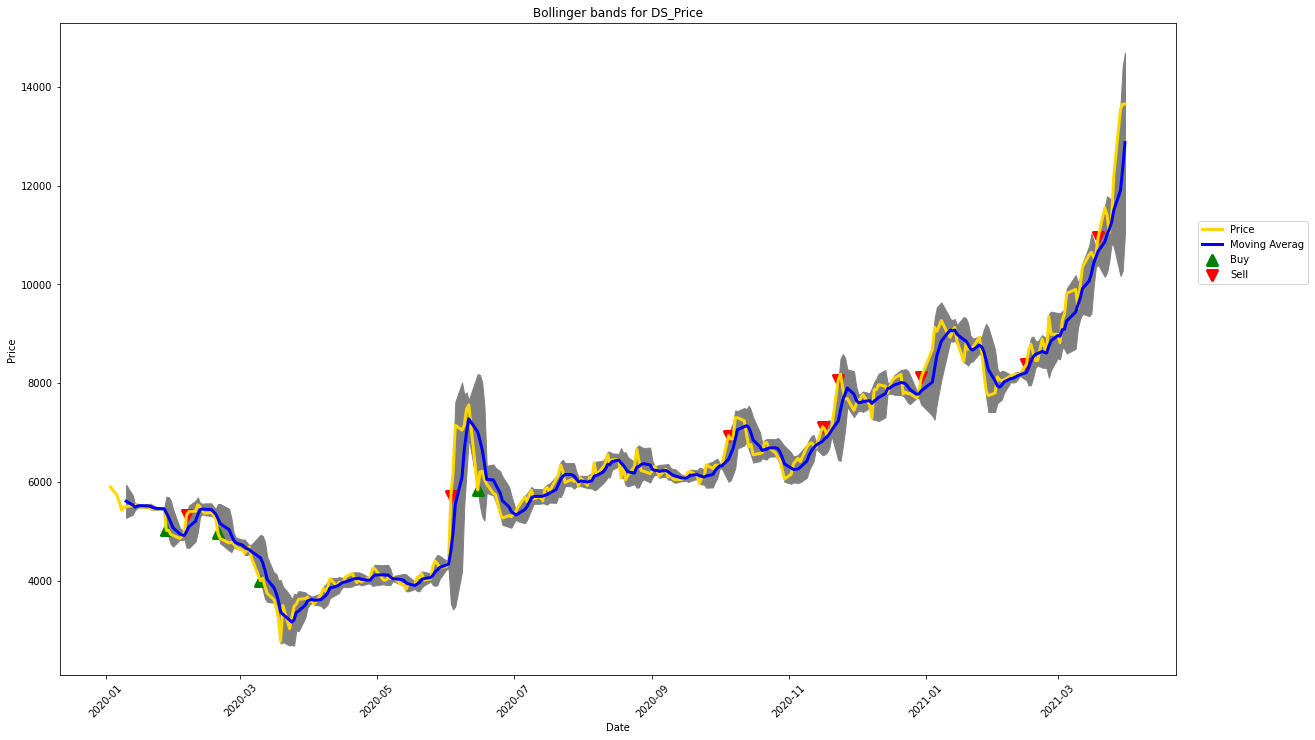

In [163]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'DS_Price', p = 5, std = 1.7)

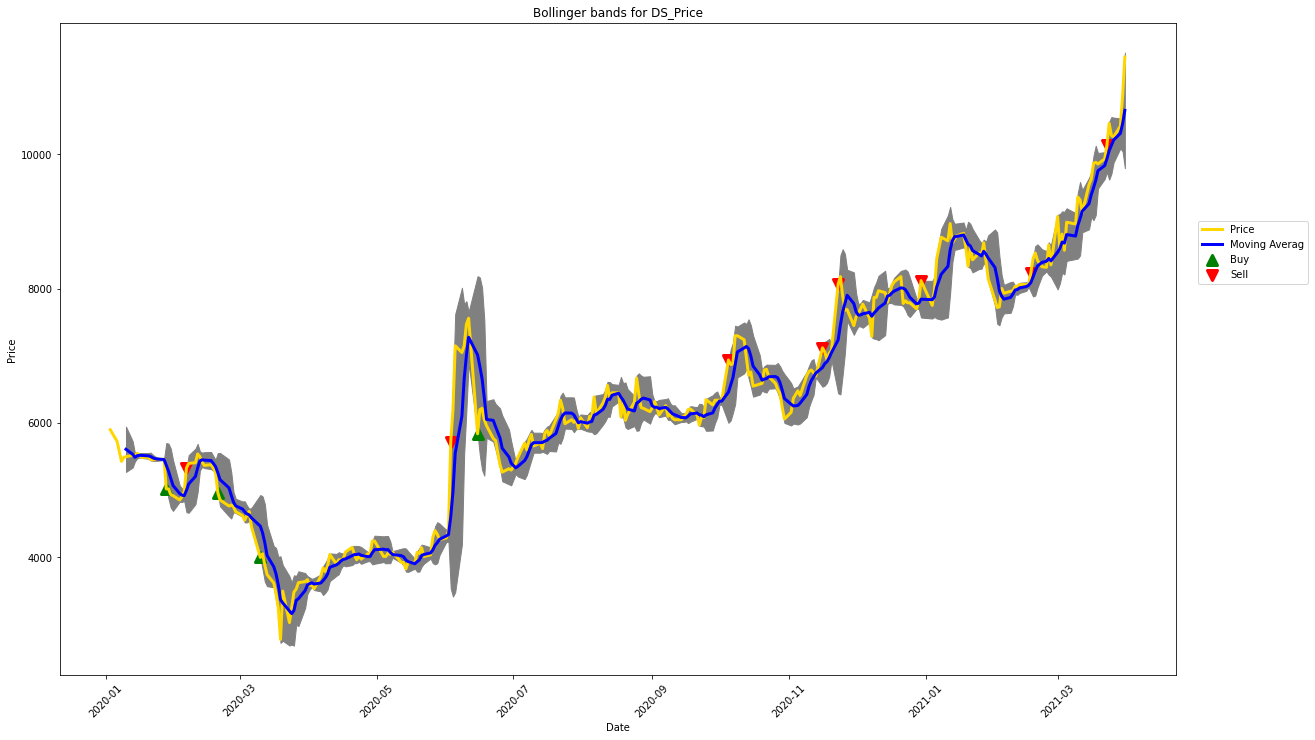

In [164]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'DS_Price', p = 5, std = 1.7)

In [165]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['DS_Price'], df2 = predictions_df['DS_Price'])

The actual returns had a value of 57.26% and the predicted returns had a value 47.66%


### ARIMA

In [166]:
# Get a data frame that stores the train and predicted data frame for the bollinger bands

predicted_df_arima = merge_df(df1 = S_predicted_arima, df2 = KCHOL_predicted_arima, df3 = M_predicted_arima, 
                        df4 = BEEF_predicted_arima, df5 = P_predicted_arima, df6 = C_predicted_arima, 
                        df7 = IP_predicted_arima, df8 = DS_predicted_arima)

#### S Stock

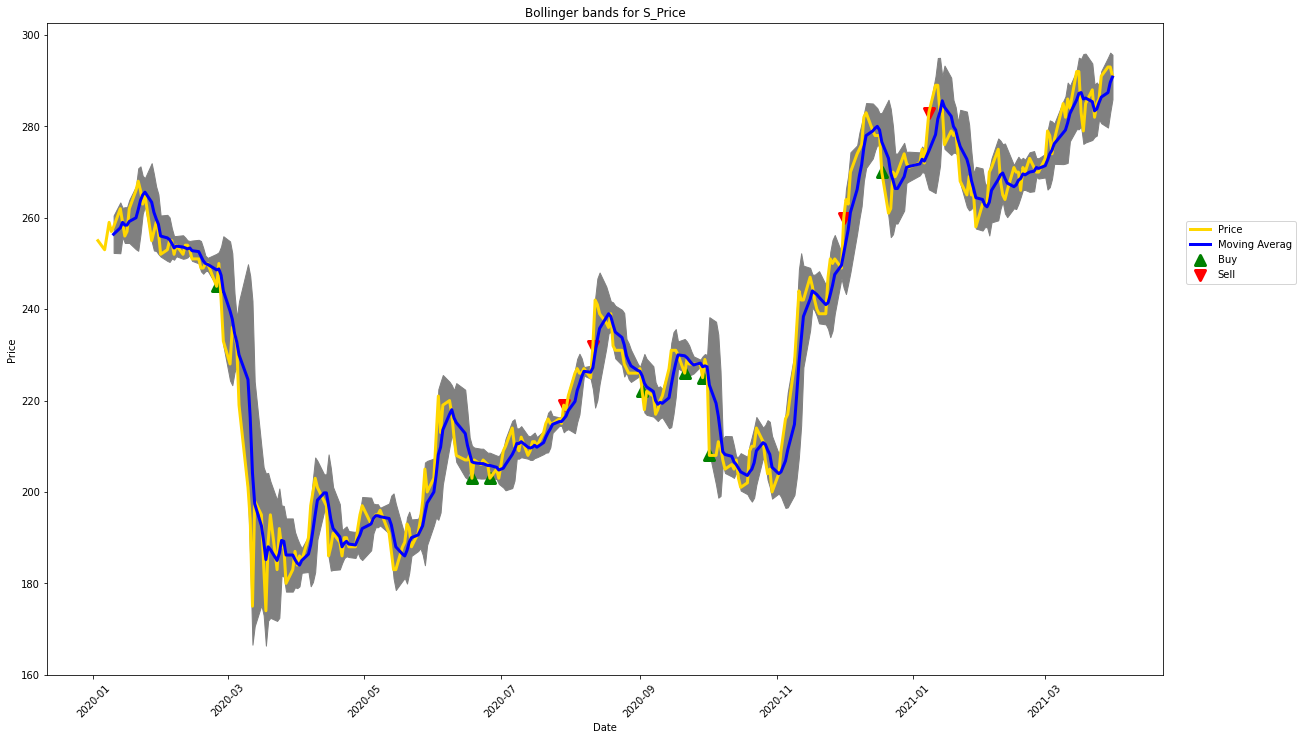

In [167]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'S_Price', p = 5, std = 1.7)

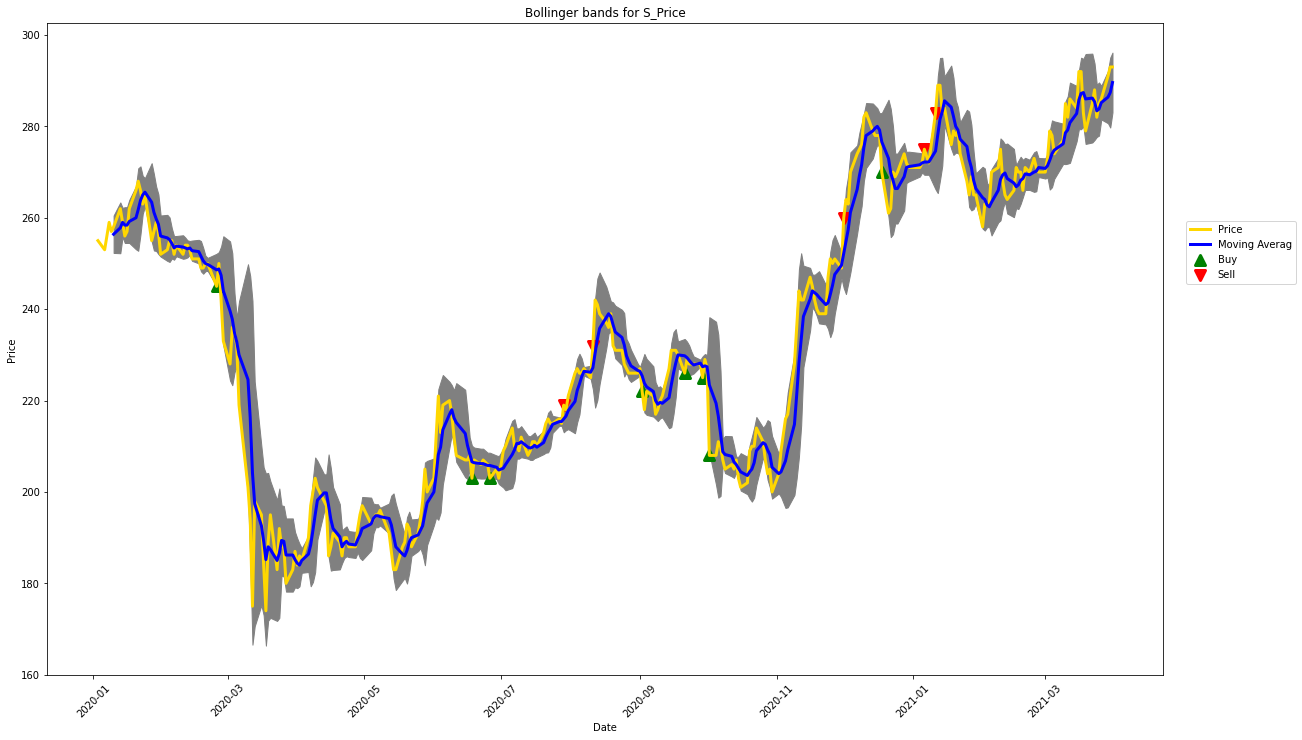

In [168]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'S_Price', p = 5, std = 1.7)

In [169]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['S_Price'], df2 = pred_arima['S_Price'])

The actual returns had a value of 6.99% and the predicted returns had a value 7.95%


#### KCHOL Stock

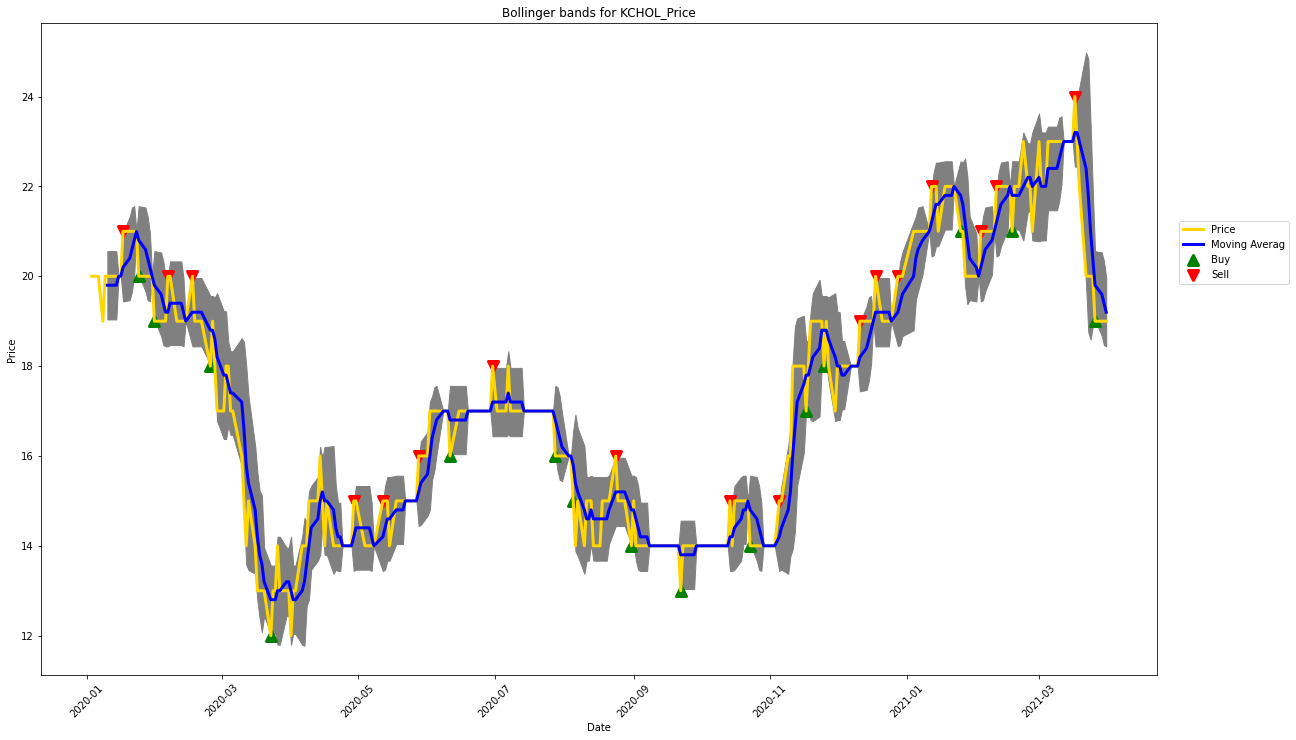

In [170]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'KCHOL_Price', p = 5, std = 1.7)

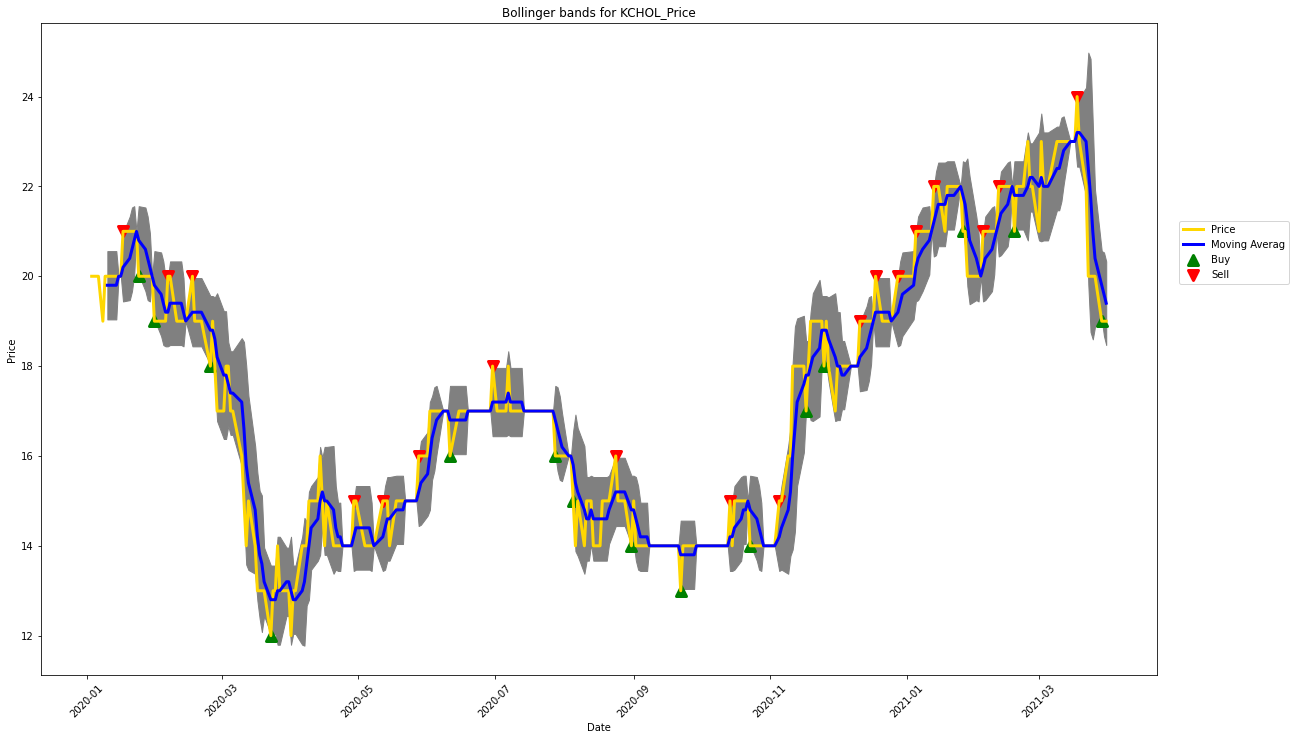

In [171]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'KCHOL_Price', p = 5, std = 1.7)

In [172]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['KCHOL_Price'], df2 = pred_arima['KCHOL_Price'])

The actual returns had a value of -8.44% and the predicted returns had a value -6.88%


#### M Stock

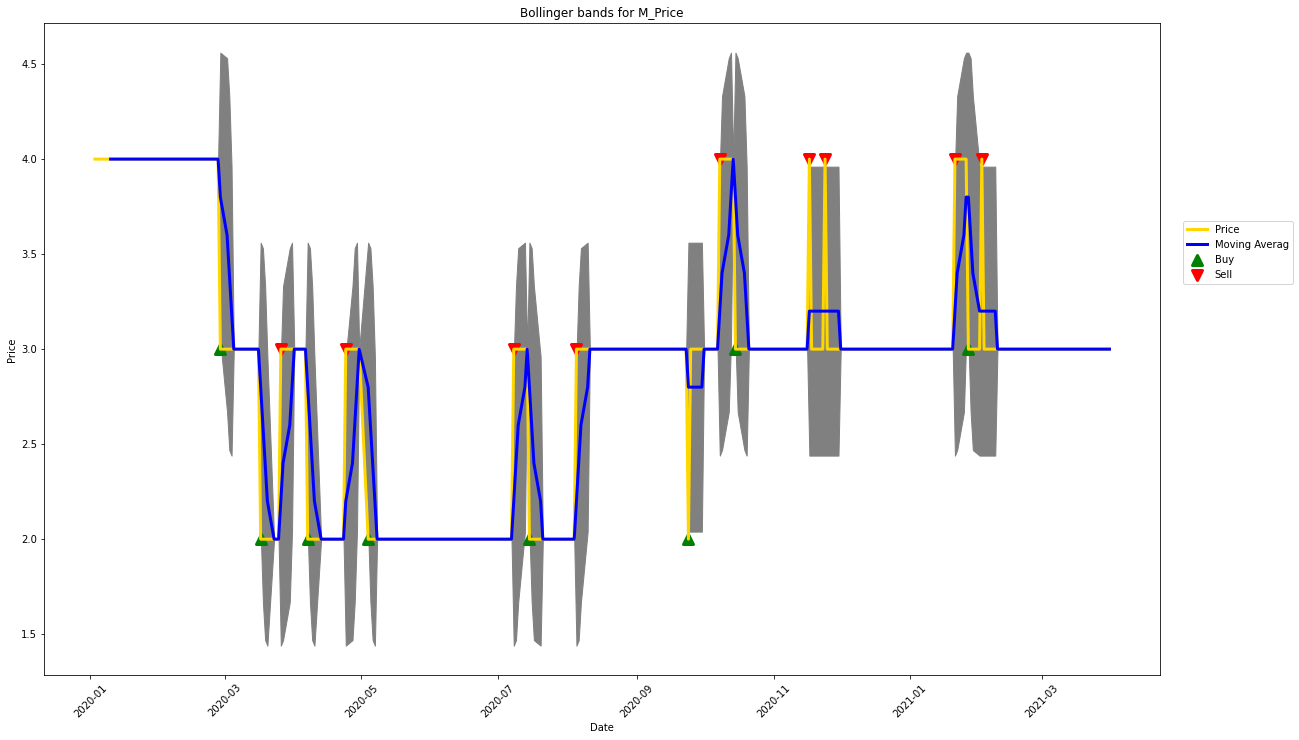

In [173]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'M_Price', p = 5, std = 1.7)

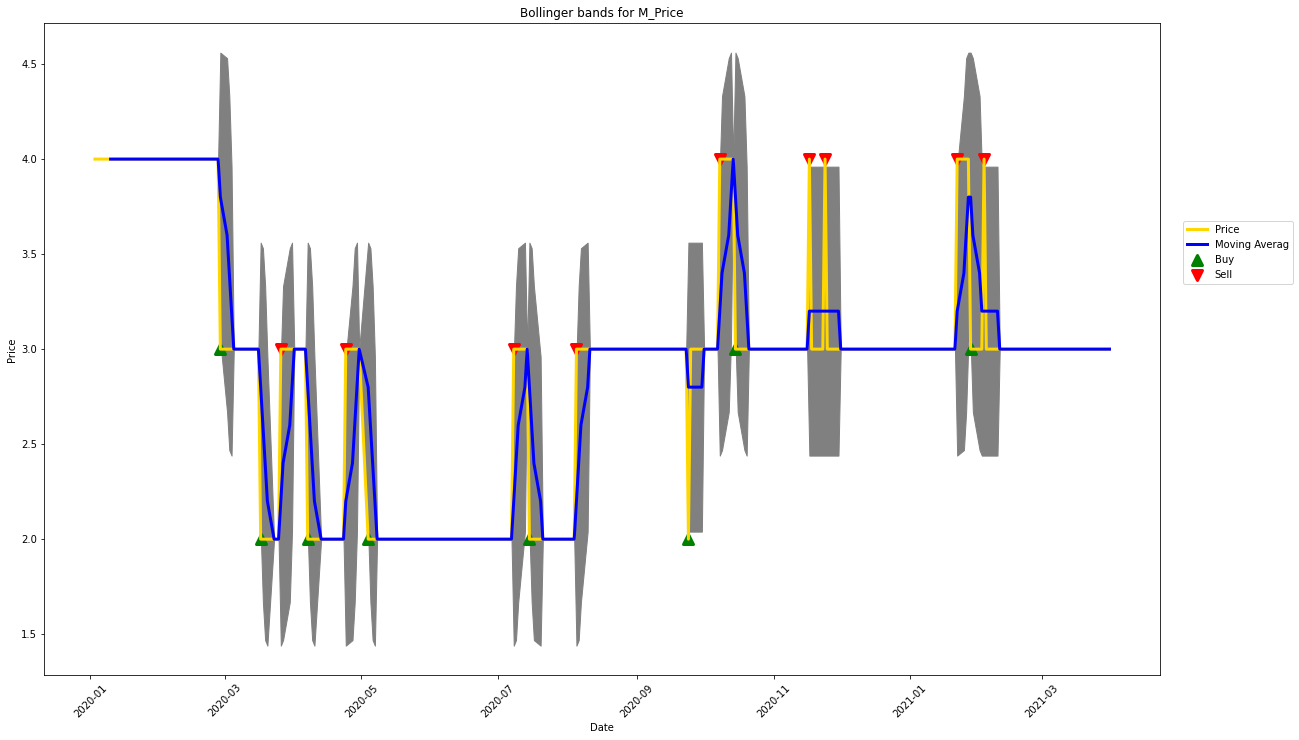

In [174]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'M_Price', p = 5, std = 1.7)

In [175]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['M_Price'], df2 = pred_arima['M_Price'])

The actual returns had a value of -4.58% and the predicted returns had a value -2.51%


#### BEEF Stock

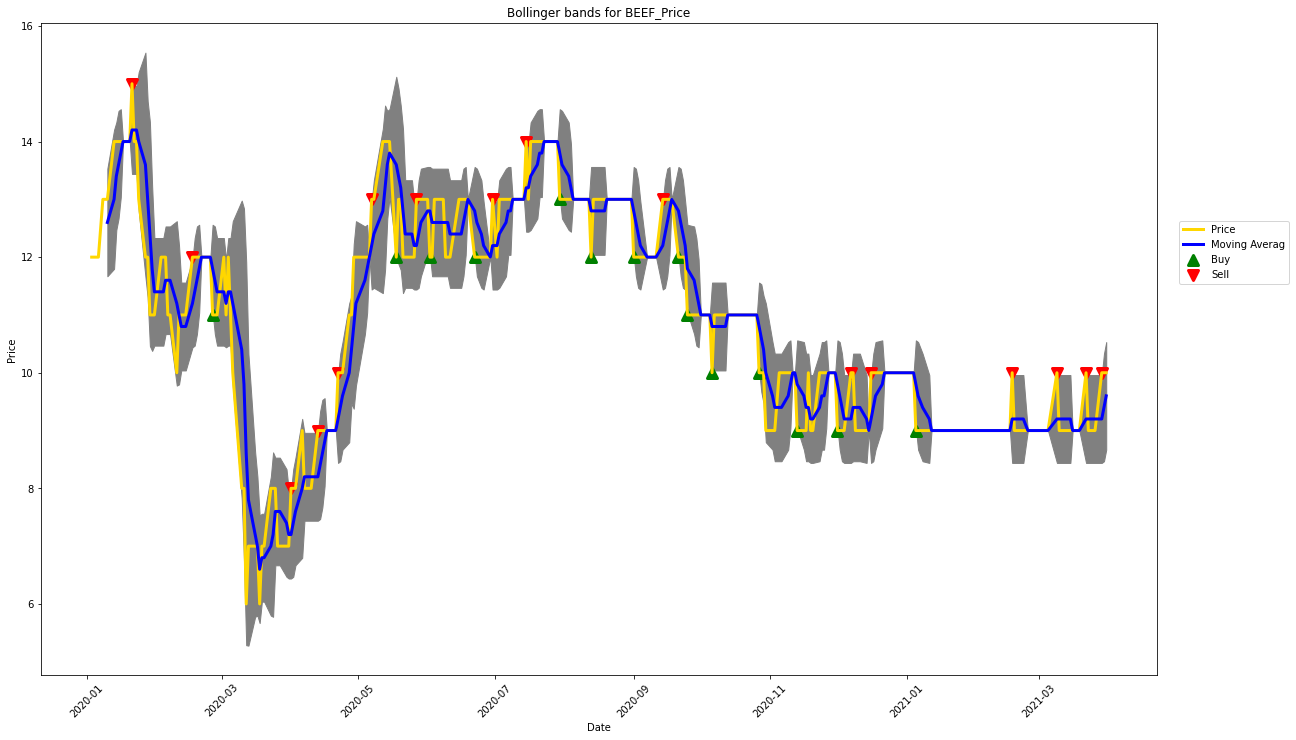

In [176]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'BEEF_Price', p = 5, std = 1.7)

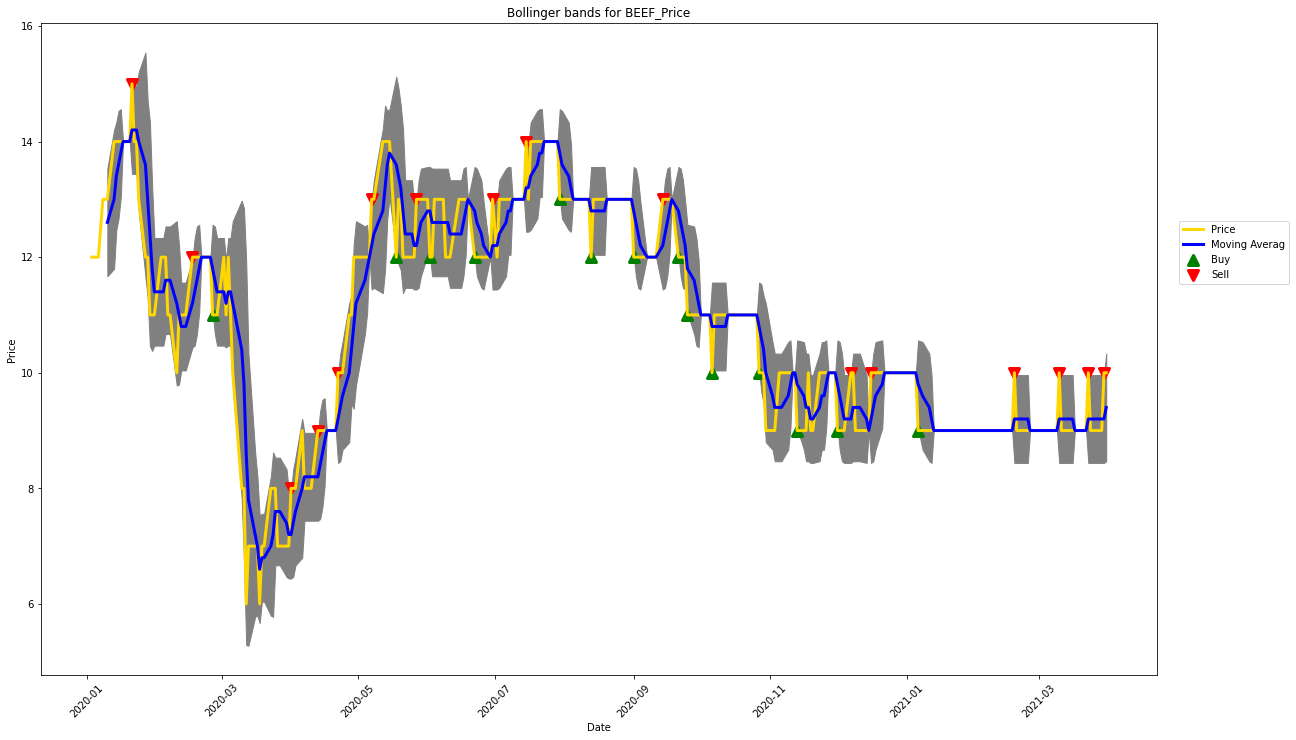

In [177]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'BEEF_Price', p = 5, std = 1.7)

In [178]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['BEEF_Price'], df2 = pred_arima['BEEF_Price'])

The actual returns had a value of 1.59% and the predicted returns had a value 1.77%


#### P Stock

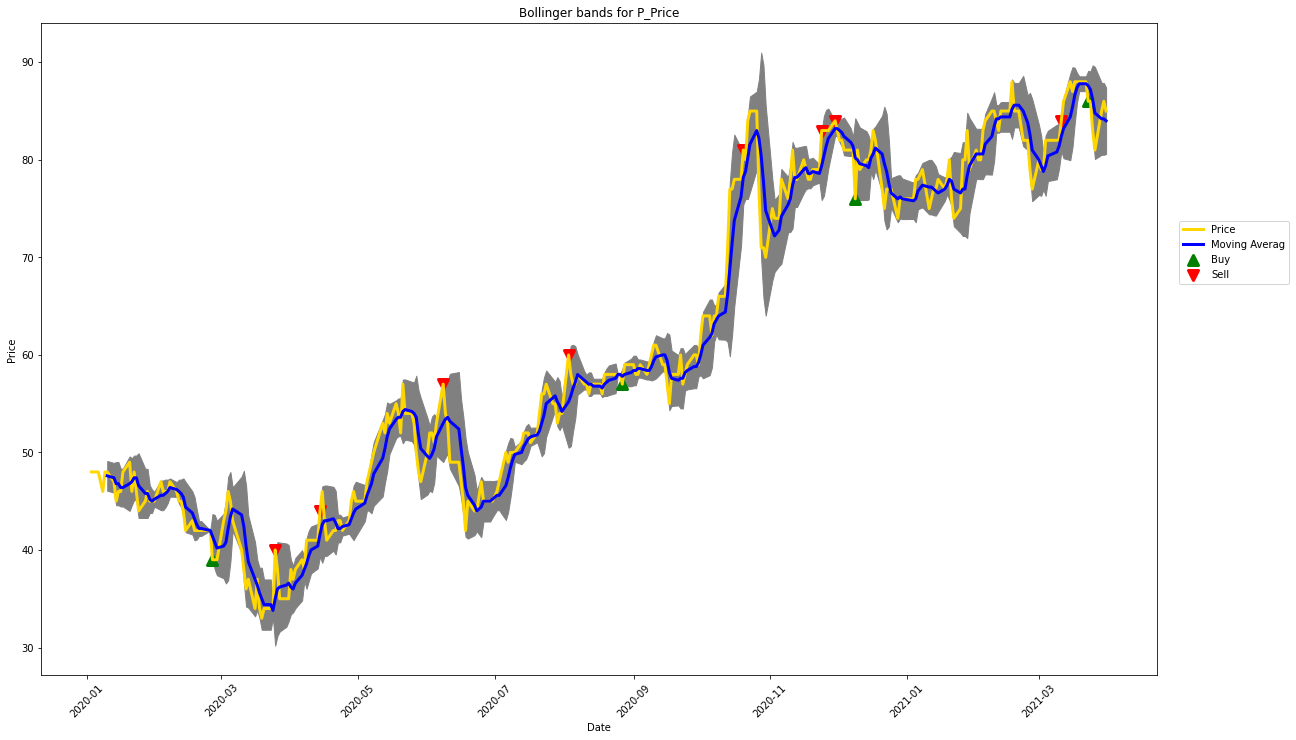

In [179]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'P_Price', p = 5, std = 1.7)

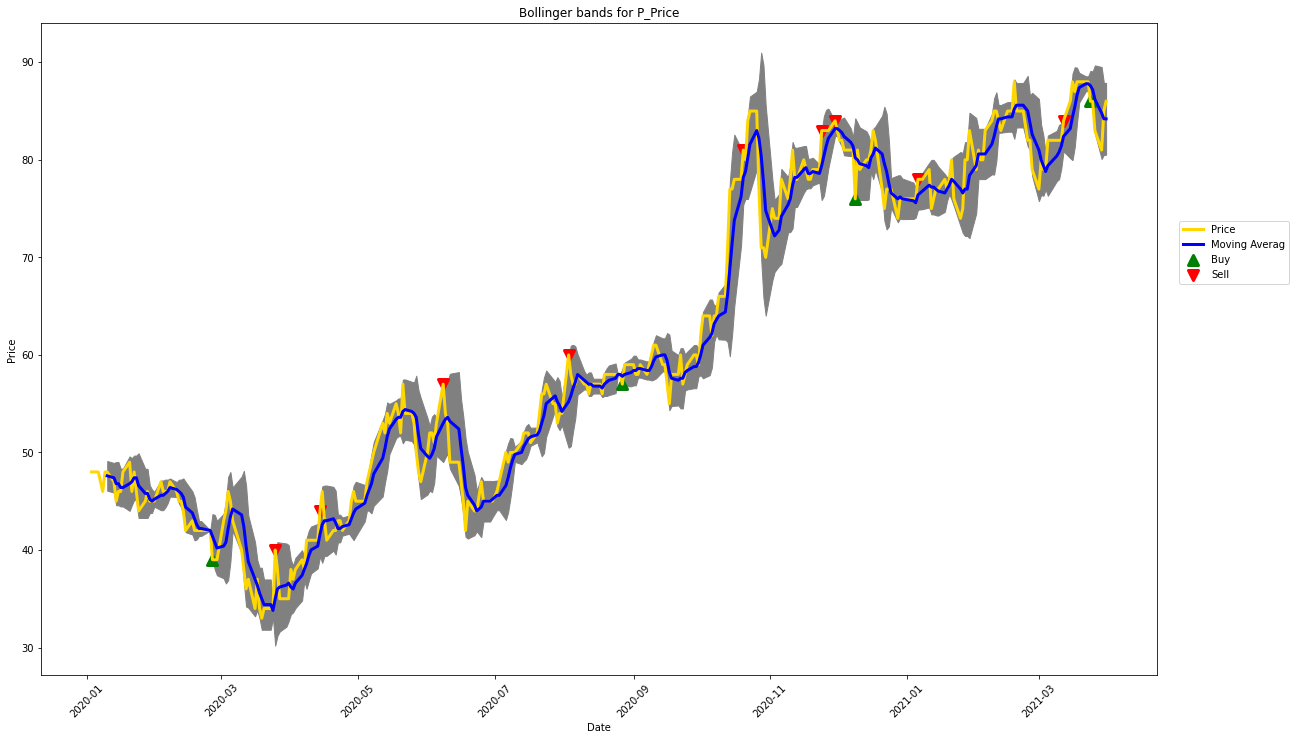

In [180]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'P_Price', p = 5, std = 1.7)

In [181]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['P_Price'], df2 = pred_arima['P_Price'])

The actual returns had a value of 11.02% and the predicted returns had a value 11.96%


#### C Stock

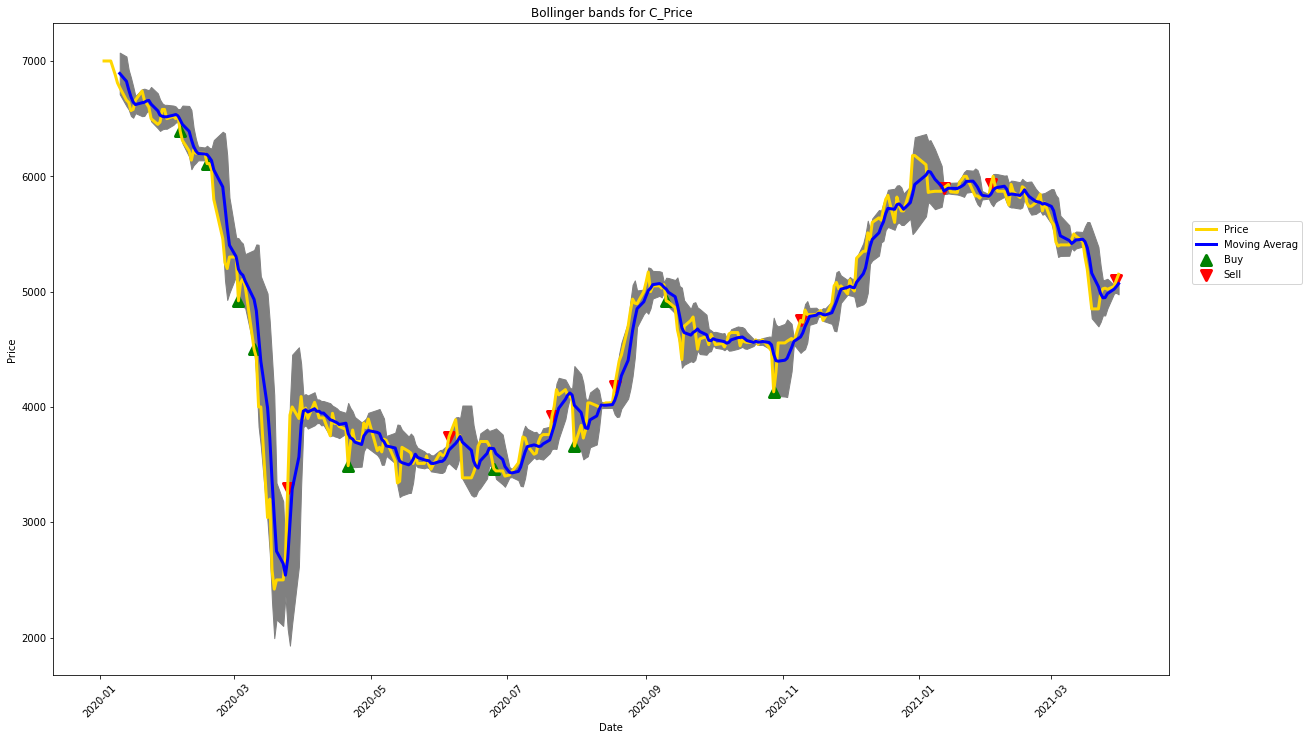

In [182]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'C_Price', p = 5, std = 1.7)

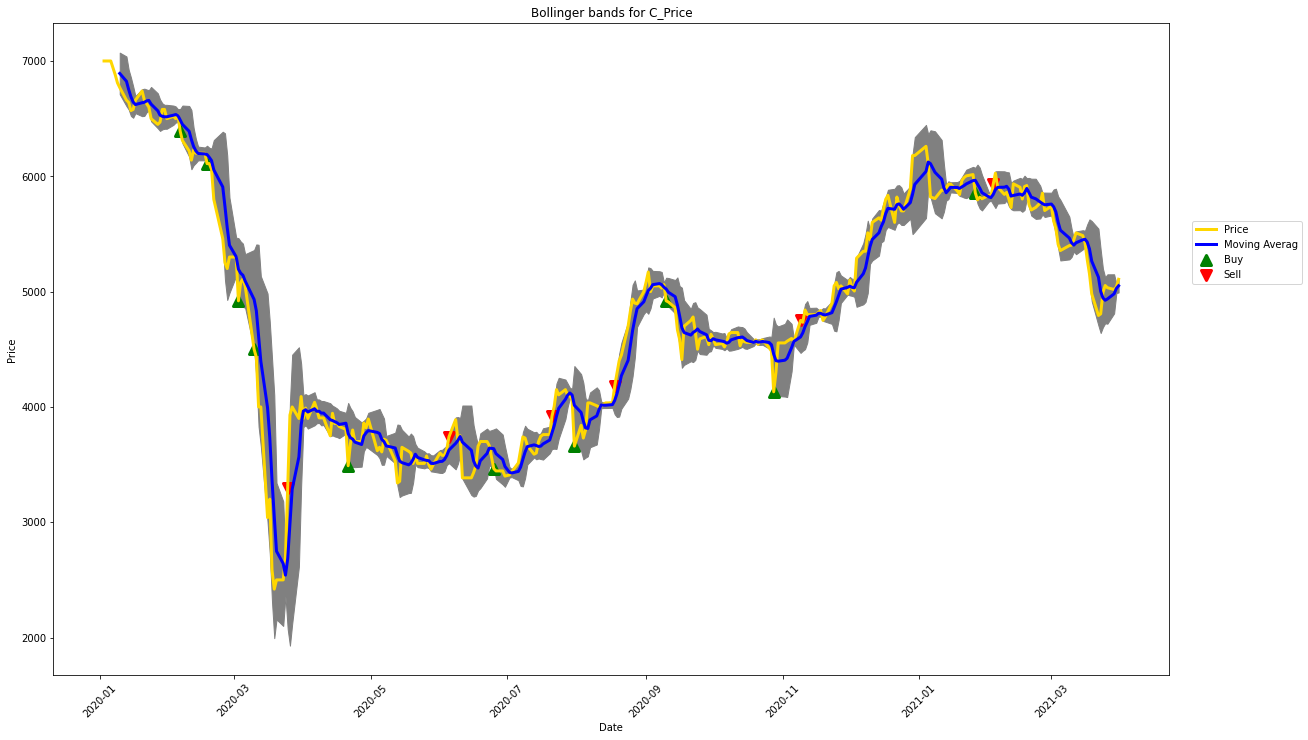

In [183]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'C_Price', p = 5, std = 1.7)

In [184]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['C_Price'], df2 = pred_arima['C_Price'])

The actual returns had a value of -15.57% and the predicted returns had a value -18.42%


#### IP Stock

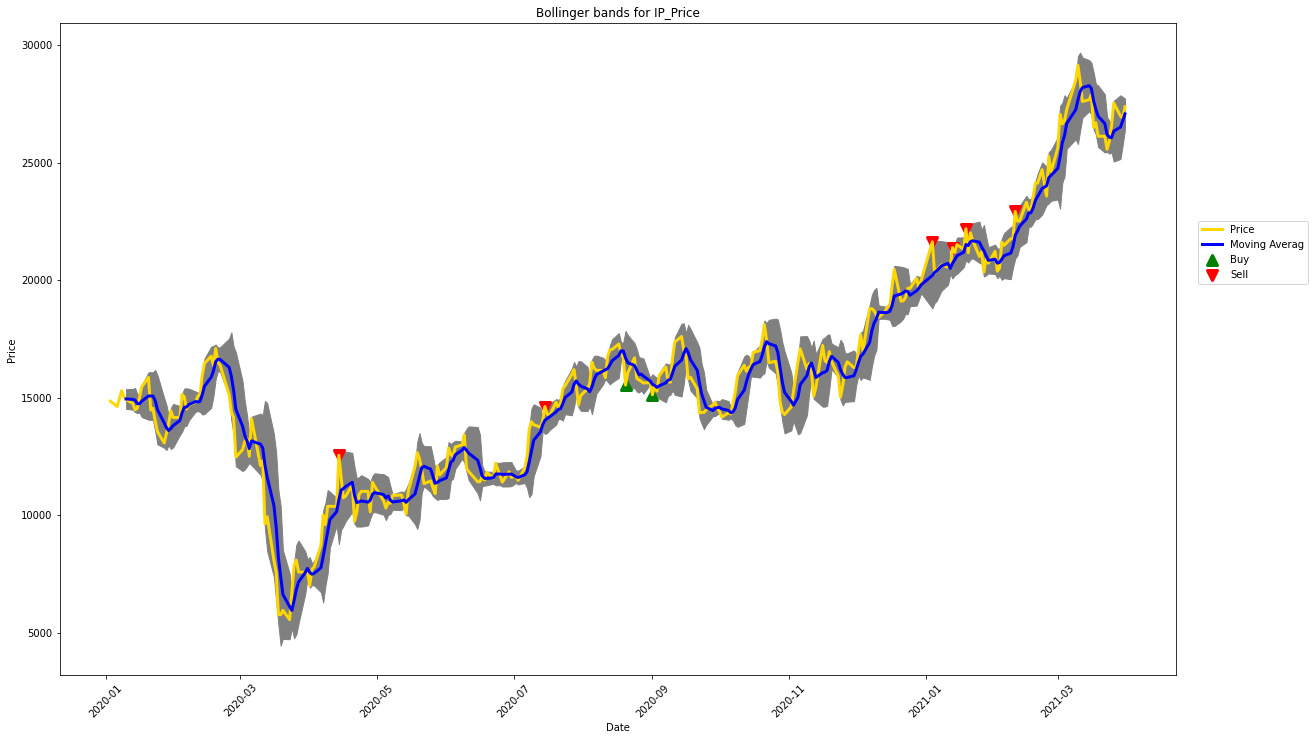

In [185]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'IP_Price', p = 5, std = 1.7)

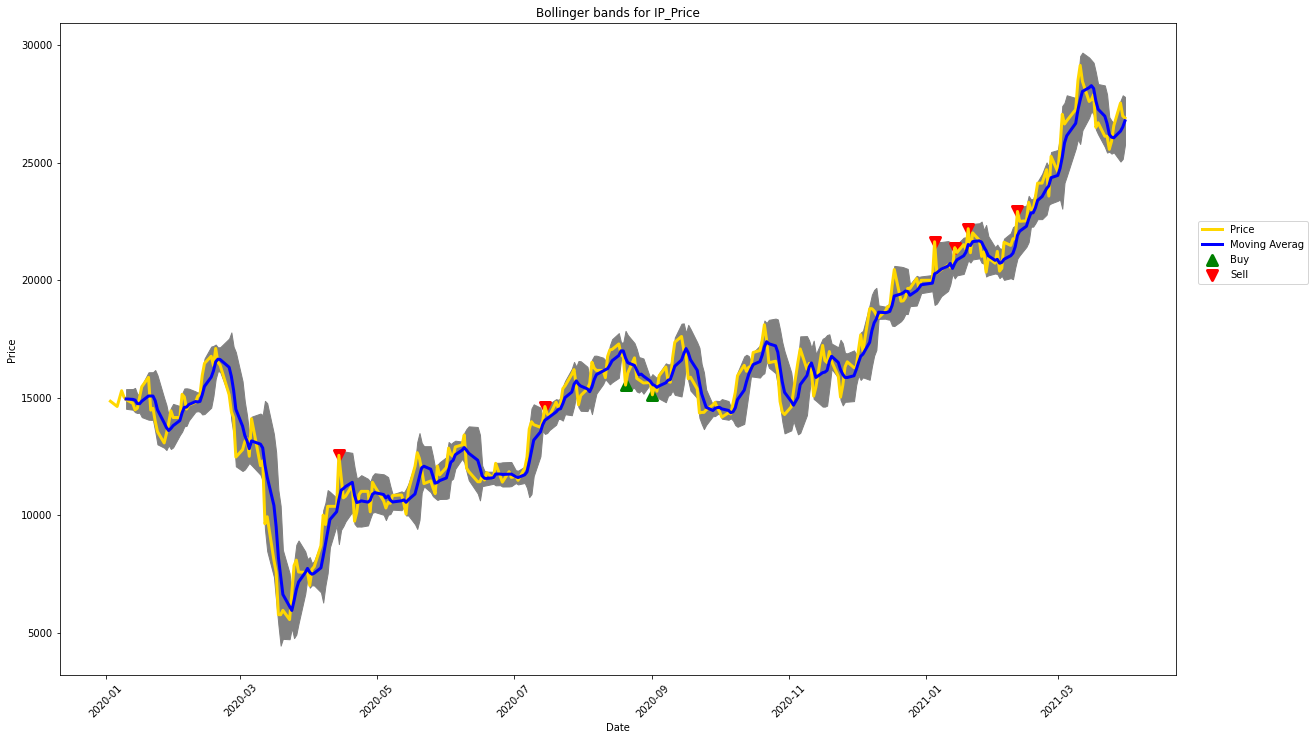

In [186]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'IP_Price', p = 5, std = 1.7)

In [187]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['IP_Price'], df2 = pred_arima['IP_Price'])

The actual returns had a value of 26.56% and the predicted returns had a value 34.56%


#### DS Stock

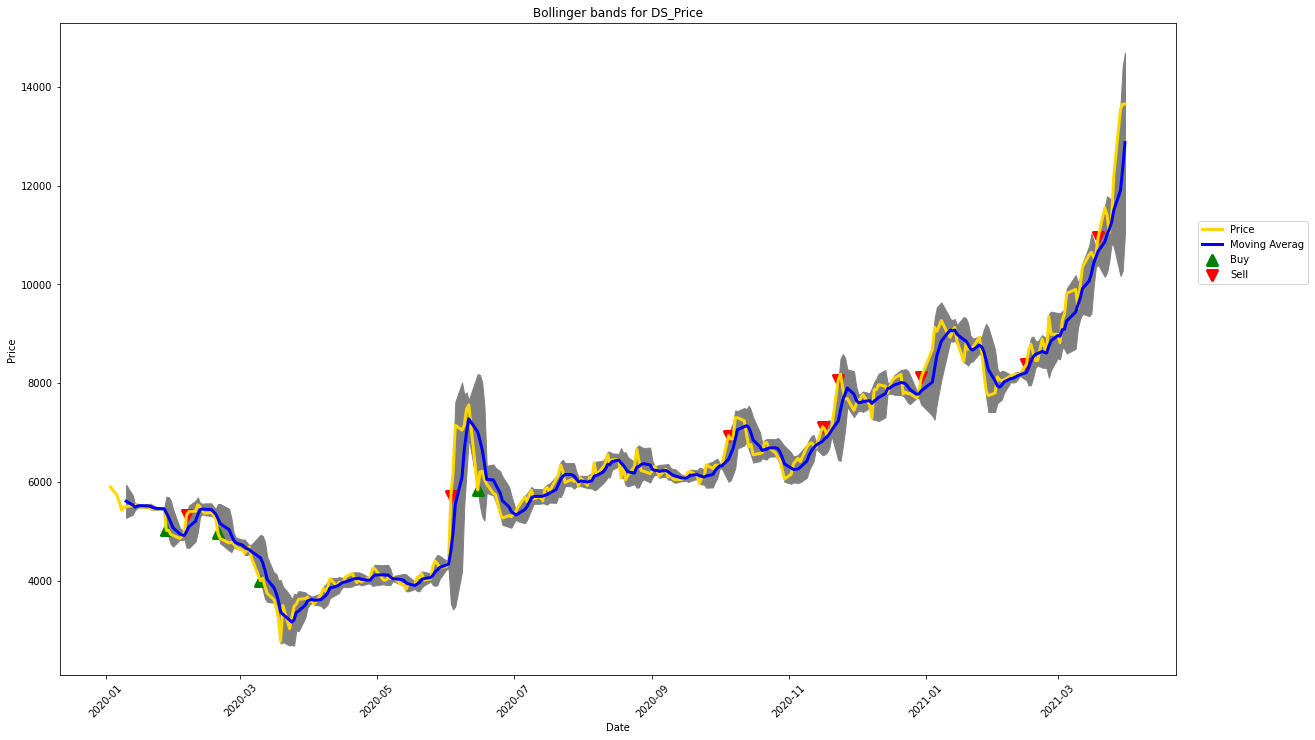

In [188]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'DS_Price', p = 5, std = 1.7)

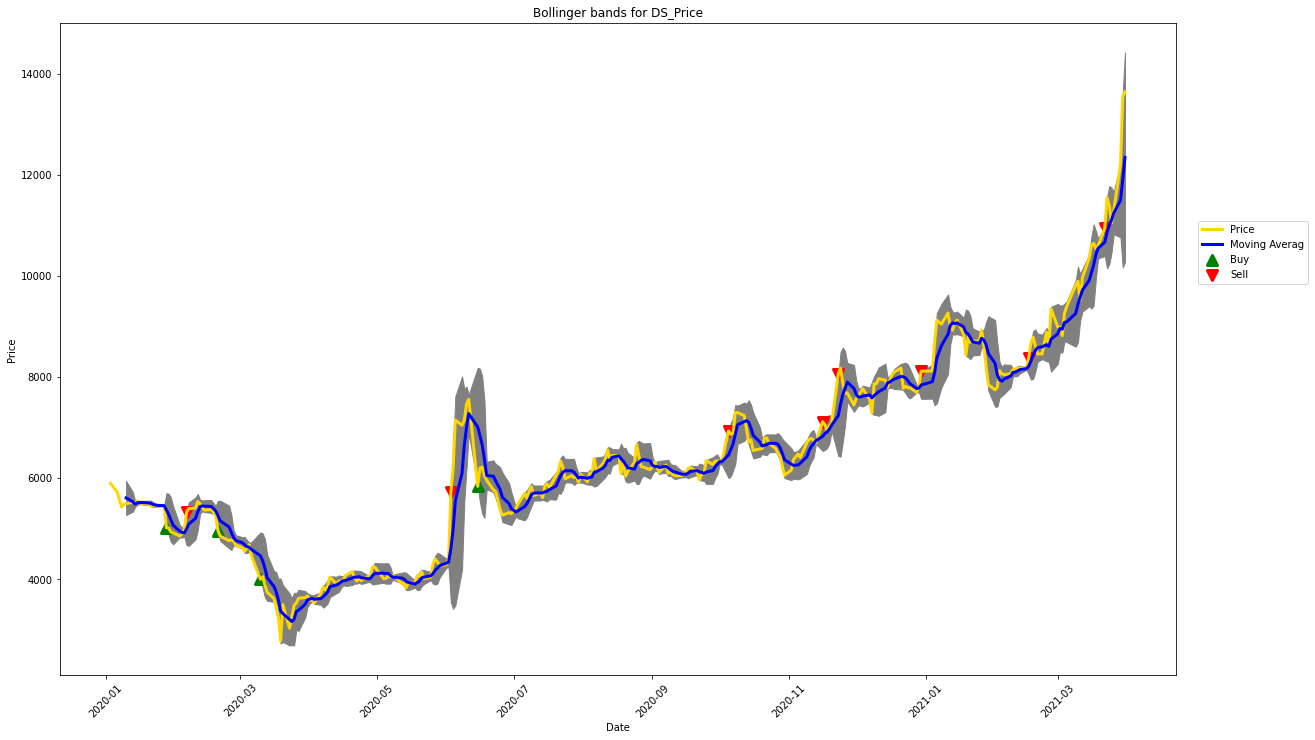

In [189]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df_arima, col = 'DS_Price', p = 5, std = 1.7)

In [190]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['DS_Price'], df2 = pred_arima['DS_Price'])

The actual returns had a value of 57.26% and the predicted returns had a value 68.1%


### Combining two models

In [191]:
from sklearn.metrics import mean_squared_error

In [192]:
def model_weight(col):
    x = np.arange(0,1.1, 0.1)
    y = np.arange(0,1.1, 0.1)
    squared_error = []
    weights_lstm = []
    weights_arima = []
    for i in x:
        for j in y:
            if (i+j) ==1:
                p = (i*predictions_df[col])+(j*pred_arima[col])
                e = mean_squared_error(test[col], p)
                squared_error.append(e)
                weights_lstm.append(i)
                weights_arima.append(j)
                
            else:
                pass
    return squared_error, weights_lstm, weights_arima

In [193]:
def pred_df(col):
    pred = pd.concat([train[col], weighted_predictions[col]])
    return pred

In [194]:
# The combination of the two models by weigthing the results per 0.5. 
# Didn't take approach of mean squared error because it would show to use only ARIMA

weighted_predictions = (0.5 * predictions_df) + (0.5 * pred_arima)

#### D Stock

In [195]:
# New predictions

S_predictions = pred_df(col = 'S_Price')

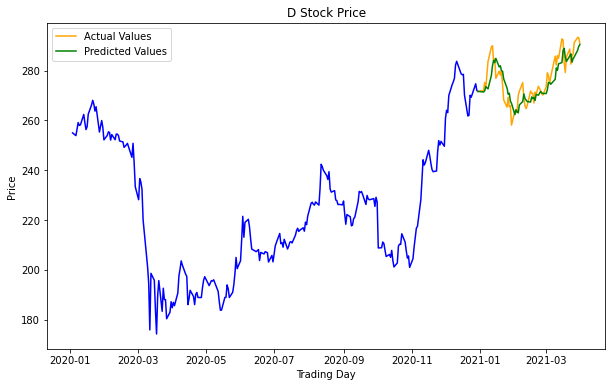

In [196]:
# Plot the Stock Price comparison

plot_comparison(actual = S_actual, predicted = S_predictions, string = 'D Stock Price')

#### KCHOL Stock

In [197]:
# New predictions

KCHOL_predictions = pred_df(col = 'KCHOL_Price')

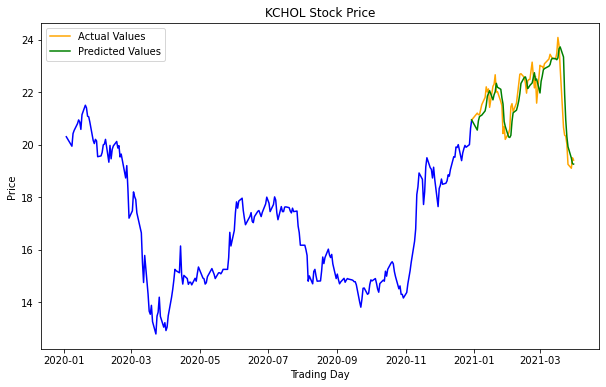

In [198]:
# Plot the Stock Price comparison

plot_comparison(actual = KCHOL_actual, predicted = KCHOL_predictions, string = 'KCHOL Stock Price')

#### M Stock

In [199]:
# New predictions

M_predictions = pred_df(col = 'M_Price')

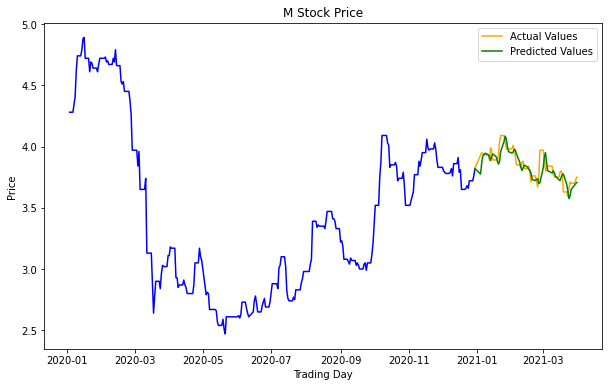

In [200]:
# Plot the Stock Price comparison

plot_comparison(actual = M_actual, predicted = M_predictions, string = 'M Stock Price')

#### BEEF Stock

In [201]:
# New predictions

BEEF_predictions = pred_df(col = 'BEEF_Price')

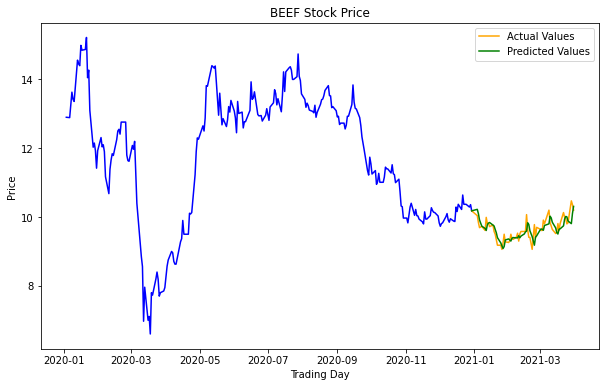

In [202]:
# Plot the Stock Price comparison

plot_comparison(actual = BEEF_actual, predicted = BEEF_predictions, string = 'BEEF Stock Price')

#### P Stock

In [203]:
# New predictions

P_predictions = pred_df(col = 'P_Price')

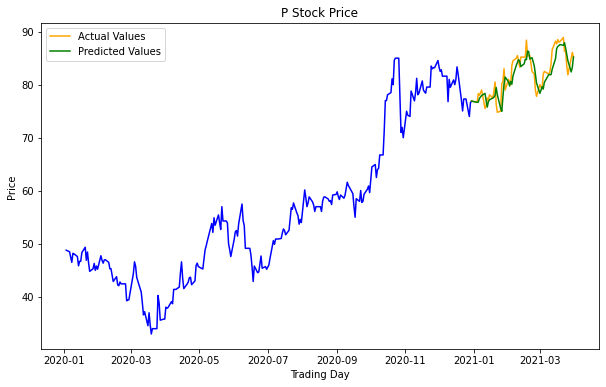

In [204]:
# Plot the Stock Price comparison

plot_comparison(actual = P_actual, predicted = P_predictions, string = 'P Stock Price')

#### C Stock

In [205]:
# New predictions

C_predictions = pred_df(col = 'C_Price')

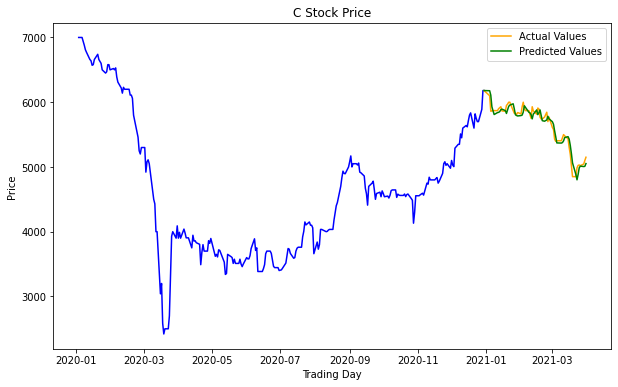

In [206]:
# Plot the Stock Price comparison

plot_comparison(actual = C_actual, predicted = C_predictions, string = 'C Stock Price')

#### IP Stock

In [207]:
# New predictions

IP_predictions = pred_df(col = 'IP_Price')

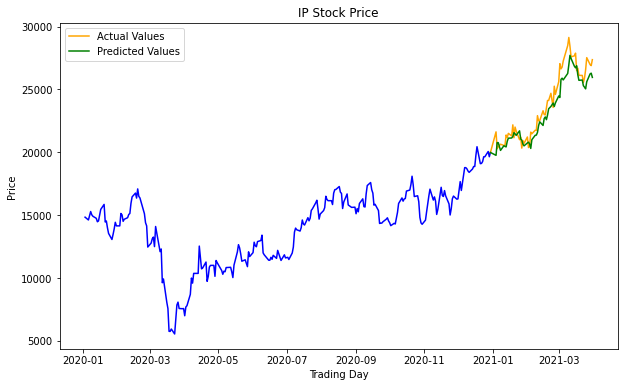

In [208]:
# Plot the Stock Price comparison

plot_comparison(actual = IP_actual, predicted = IP_predictions, string = 'IP Stock Price')

#### DS Stock

In [209]:
# New predictions

DS_predictions = pred_df(col = 'DS_Price')

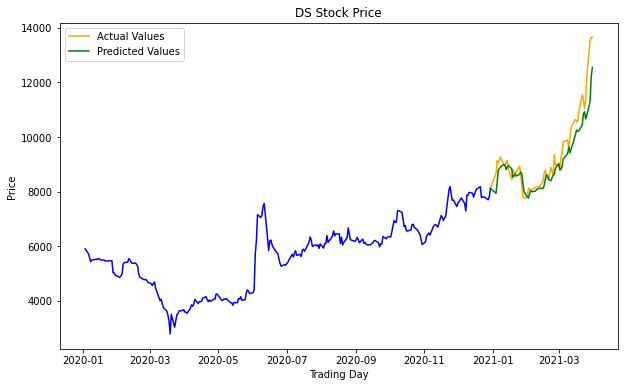

In [210]:
# Plot the Stock Price comparison

plot_comparison(actual = DS_actual, predicted = DS_predictions, string = 'DS Stock Price')

In [211]:
class model_reinforcement:
    
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [212]:
def plot_signals(values):
    fig = plt.figure(figsize = (15,5))
    plt.plot(values, color='r', lw=2.)
    plt.plot(values, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
    plt.plot(values, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
    plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
    plt.legend()
    plt.show()

In [213]:
initial_money = 1000
window_size = 5
skip = 1
batch_size = 32

#### S Stock

##### Actual Values

In [214]:
# Define the values for the S Stock

close = S_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
epoch: 10, total rewards: 16.940000.3, cost: 0.140760, total money: 1016.940000
epoch: 20, total rewards: -6.890000.3, cost: 0.057191, total money: 993.110000
epoch: 30, total rewards: 1.480000.3, cost: 0.078642, total money: 1001.480000
epoch: 40, total rewards: 0.220000.3, cost: 0.067333, total money: 1000.220000
epoch: 50, total rewards: 1.520000.3, cost: 0.059954, total money: 1001.520000
epoch: 60, total rewards: -20.590000.3, cost: 0.025114, total money: 979.410000
epoch: 70, total rewards: -29.650000.3, cost: 0.023043, total money: 970.350000
epoch: 80, total rewards: -10.240000.3, cost: 0.020698, total money: 989.760000
epoch: 90, total rewards: -1.720000.3, cost: 0.019203, total money: 998.280000
epoch: 100, total rewards: -30.270000.3, cost: 0.018249, total money: 969.730000


In [215]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 19: buy 1 unit at price 252.200000, total balance 747.800000
day 20, sell 1 unit at price 253.990000, investment 0.709754 %, total balance 1001.790000,
day 21: buy 1 unit at price 255.400000, total balance 746.390000
day 22: buy 1 unit at price 255.200000, total balance 491.190000
day 23: buy 1 unit at price 252.110000, total balance 239.080000
day 24, sell 1 unit at price 254.300000, investment -0.430697 %, total balance 493.380000,
day 25, sell 1 unit at price 252.260000, investment -1.152038 %, total balance 745.640000,
day 27, sell 1 unit at price 254.500000, investment 0.947999 %, total balance 1000.140000,
day 31: buy 1 unit at price 249.200000, total balance 750.940000
day 32, sell 1 unit at price 249.700000, investment 0.200642 %, total balance 1000.640000,
day 34: buy 1 unit at price 250.800000, total balance 749.840000
day 35, sell 1 unit at price 245.190000, investment -2.236842 %, total balance 995.030000,
day 40: buy 1 unit at price 236.630000, total balance 758.400000

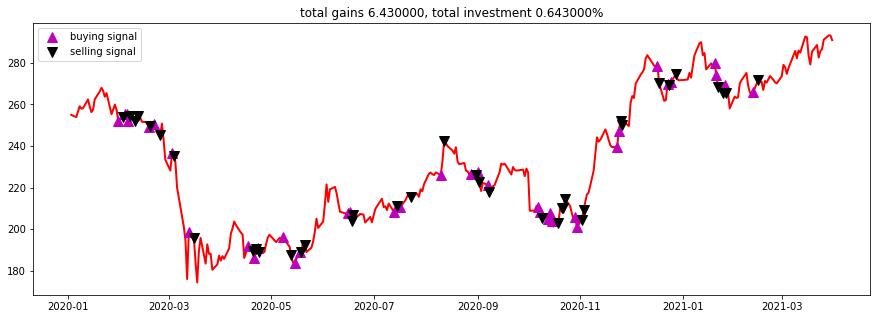

In [216]:
# Plot the results

plot_signals(values = S_actual)

##### Predicted Values

In [217]:
# Define the values for the S Stock

close = S_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 12.656042.3, cost: 0.025234, total money: 1012.656042
epoch: 20, total rewards: 7.007836.3, cost: 0.010450, total money: 1007.007836
epoch: 30, total rewards: -10.609667.3, cost: 0.007996, total money: 989.390333
epoch: 40, total rewards: -10.209025.3, cost: 0.005609, total money: 989.790975
epoch: 50, total rewards: -18.714911.3, cost: 0.006387, total money: 981.285089
epoch: 60, total rewards: -13.987222.3, cost: 0.005578, total money: 986.012778
epoch: 70, total rewards: -15.360693.3, cost: 0.004896, total money: 984.639307
epoch: 80, total rewards: -8.080693.3, cost: 0.004378, total money: 991.919307
epoch: 90, total rewards: -7.740734.3, cost: 0.002666, total money: 992.259266
epoch: 100, total rewards: 8.789266.3, cost: 0.004396, total money: 1008.789266


In [218]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 13: buy 1 unit at price 263.730000, total balance 736.270000
day 14, sell 1 unit at price 265.490000, investment 0.667349 %, total balance 1001.760000,
day 67: buy 1 unit at price 201.990000, total balance 799.770000
day 68: buy 1 unit at price 198.260000, total balance 601.510000
day 69, sell 1 unit at price 197.370000, investment -2.287242 %, total balance 798.880000,
day 71, sell 1 unit at price 188.500000, investment -4.922829 %, total balance 987.380000,
day 112: buy 1 unit at price 208.140000, total balance 779.240000
day 115, sell 1 unit at price 206.400000, investment -0.835976 %, total balance 985.640000,
day 125: buy 1 unit at price 210.970000, total balance 774.670000
day 126, sell 1 unit at price 209.110000, investment -0.881642 %, total balance 983.780000,
day 154: buy 1 unit at price 236.300000, total balance 747.480000
day 155, sell 1 unit at price 239.400000, investment 1.311892 %, total balance 986.880000,
day 177: buy 1 unit at price 230.300000, total balance 756.

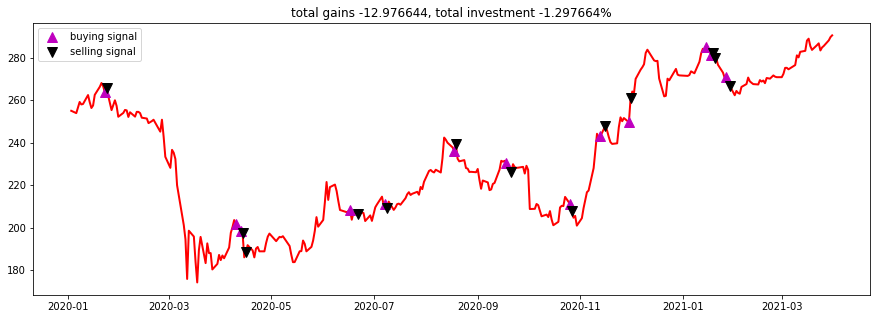

In [219]:
# Plot the results

plot_signals(values = S_predictions)

#### KCHOL Stock

##### Actual Values

In [220]:
# Define the values for the S Stock

close = KCHOL_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 1.920000.3, cost: 0.005719, total money: 943.210000
epoch: 20, total rewards: 0.260000.3, cost: 0.005694, total money: 941.550000
epoch: 30, total rewards: 1.100000.3, cost: 0.005629, total money: 942.390000
epoch: 40, total rewards: -0.080000.3, cost: 0.003531, total money: 941.210000
epoch: 50, total rewards: 2.680000.3, cost: 0.005509, total money: 943.970000
epoch: 60, total rewards: -0.580000.3, cost: 0.003486, total money: 940.710000
epoch: 70, total rewards: -0.010000.3, cost: 0.005229, total money: 980.890000
epoch: 80, total rewards: 0.730000.3, cost: 0.005182, total money: 981.630000
epoch: 90, total rewards: -0.590000.3, cost: 0.005148, total money: 980.310000
epoch: 100, total rewards: 1.850000.3, cost: 0.005080, total money: 982.750000


In [221]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 19.940000, total balance 980.060000
day 4, sell 1 unit at price 20.540000, investment 3.009027 %, total balance 1000.600000,
day 16: buy 1 unit at price 20.040000, total balance 980.560000
day 19, sell 1 unit at price 19.540000, investment -2.495010 %, total balance 1000.100000,
day 20: buy 1 unit at price 19.570000, total balance 980.530000
day 21, sell 1 unit at price 19.700000, investment 0.664282 %, total balance 1000.230000,
day 26: buy 1 unit at price 19.970000, total balance 980.260000
day 27, sell 1 unit at price 19.460000, investment -2.553831 %, total balance 999.720000,
day 29: buy 1 unit at price 19.950000, total balance 979.770000
day 30, sell 1 unit at price 20.120000, investment 0.852130 %, total balance 999.890000,
day 34: buy 1 unit at price 19.640000, total balance 980.250000
day 35, sell 1 unit at price 18.730000, investment -4.633401 %, total balance 998.980000,
day 36: buy 1 unit at price 19.200000, total balance 979.780000
day 37, sell 1

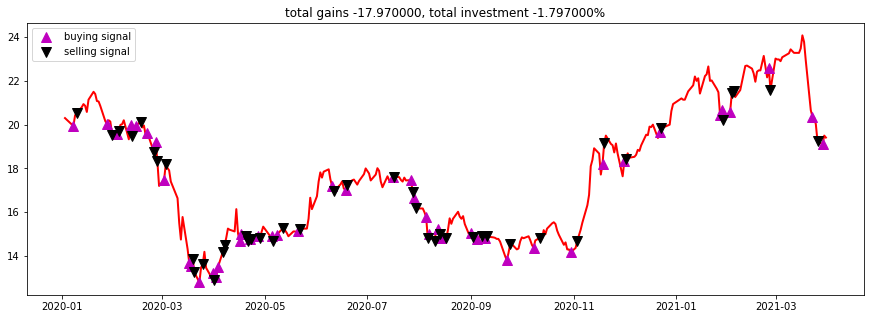

In [222]:
# Plot the results

plot_signals(values = KCHOL_actual)

##### Predicted Values

In [223]:
# Define the values for the S Stock

close = KCHOL_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -47.392651.3, cost: 0.380375, total money: 8.211855
epoch: 20, total rewards: -7.017801.3, cost: 0.363017, total money: 10.155663
epoch: 30, total rewards: 8.272081.3, cost: 0.353526, total money: 8.577247
epoch: 40, total rewards: 41.552209.3, cost: 0.337380, total money: 18.911138
epoch: 50, total rewards: 45.524733.3, cost: 0.333134, total money: 12.796989
epoch: 60, total rewards: 69.604672.3, cost: 0.315795, total money: 6.384223
epoch: 70, total rewards: 89.487662.3, cost: 0.256799, total money: 56.307809
epoch: 80, total rewards: 103.641534.3, cost: 0.219086, total money: 144.454263
epoch: 90, total rewards: 95.591534.3, cost: 0.123195, total money: 342.735964
epoch: 100, total rewards: 90.083451.3, cost: 0.107892, total money: 397.275858


In [224]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3: buy 1 unit at price 20.420000, total balance 979.580000
day 4, sell 1 unit at price 20.540000, investment 0.587659 %, total balance 1000.120000,
day 5: buy 1 unit at price 20.800000, total balance 979.320000
day 6, sell 1 unit at price 20.940000, investment 0.673077 %, total balance 1000.260000,
day 9: buy 1 unit at price 21.140000, total balance 979.120000
day 10: buy 1 unit at price 21.500000, total balance 957.620000
day 11, sell 1 unit at price 21.400000, investment 1.229896 %, total balance 979.020000,
day 12, sell 1 unit at price 21.080000, investment -1.953488 %, total balance 1000.100000,
day 16: buy 1 unit at price 20.040000, total balance 980.060000
day 17: buy 1 unit at price 20.200000, total balance 959.860000
day 18, sell 1 unit at price 20.140000, investment 0.499002 %, total balance 980.000000,
day 19, sell 1 unit at price 19.540000, investment -3.267327 %, total balance 999.540000,
day 20: buy 1 unit at price 19.570000, total balance 979.970000
day 21: buy 1 unit

day 219: buy 1 unit at price 18.200000, total balance 709.970000
day 220: buy 1 unit at price 19.150000, total balance 690.820000
day 221: buy 1 unit at price 19.500000, total balance 671.320000
day 222, sell 1 unit at price 19.120000, investment 35.410765 %, total balance 690.440000,
day 225: buy 1 unit at price 19.140000, total balance 671.300000
day 226, sell 1 unit at price 18.680000, investment 28.561597 %, total balance 689.980000,
day 228: buy 1 unit at price 18.330000, total balance 671.650000
day 229: buy 1 unit at price 18.450000, total balance 653.200000
day 230: buy 1 unit at price 18.690000, total balance 634.510000
day 231, sell 1 unit at price 18.490000, investment 26.039536 %, total balance 653.000000,
day 234: buy 1 unit at price 18.850000, total balance 634.150000
day 235, sell 1 unit at price 18.800000, investment 27.804215 %, total balance 652.950000,
day 236: buy 1 unit at price 19.050000, total balance 633.900000
day 237: buy 1 unit at price 19.540000, total balan

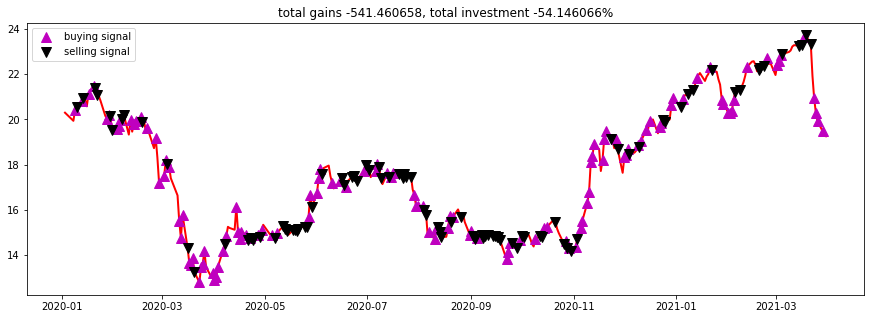

In [225]:
# Plot the results

plot_signals(values = KCHOL_predictions)

#### M Stock

##### Actual Values

In [226]:
# Define the values for the S Stock

close = M_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 1.480000.3, cost: 0.000054, total money: 1001.480000
epoch: 20, total rewards: 1.390000.3, cost: 0.000054, total money: 1001.390000
epoch: 30, total rewards: 1.440000.3, cost: 0.000055, total money: 1001.440000
epoch: 40, total rewards: 1.310000.3, cost: 0.000054, total money: 1001.310000
epoch: 50, total rewards: 1.320000.3, cost: 0.000055, total money: 1001.320000
epoch: 60, total rewards: 1.070000.3, cost: 0.000053, total money: 1001.070000
epoch: 70, total rewards: 1.040000.3, cost: 0.000046, total money: 1001.040000
epoch: 80, total rewards: 0.990000.3, cost: 0.000047, total money: 1000.990000
epoch: 90, total rewards: 1.310000.3, cost: 0.000046, total money: 1001.310000
epoch: 100, total rewards: 1.100000.3, cost: 0.000045, total money: 1001.100000


In [227]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 4.410000, total balance 995.590000
day 3: buy 1 unit at price 4.620000, total balance 990.970000
day 7, sell 1 unit at price 4.880000, investment 10.657596 %, total balance 995.850000,
day 9, sell 1 unit at price 4.720000, investment 2.164502 %, total balance 1000.570000,
day 10: buy 1 unit at price 4.720000, total balance 995.850000
day 11, sell 1 unit at price 4.610000, investment -2.330508 %, total balance 1000.460000,
day 12: buy 1 unit at price 4.690000, total balance 995.770000
day 13, sell 1 unit at price 4.680000, investment -0.213220 %, total balance 1000.450000,
day 17: buy 1 unit at price 4.670000, total balance 995.780000
day 18, sell 1 unit at price 4.720000, investment 1.070664 %, total balance 1000.500000,
day 23: buy 1 unit at price 4.700000, total balance 995.800000
day 24, sell 1 unit at price 4.670000, investment -0.638298 %, total balance 1000.470000,
day 25: buy 1 unit at price 4.670000, total balance 995.800000
day 26, sell 1 unit at pri

day 250: buy 1 unit at price 3.930000, total balance 997.230000
day 251, sell 1 unit at price 3.950000, investment 0.508906 %, total balance 1001.180000,
day 256: buy 1 unit at price 3.990000, total balance 997.190000
day 257, sell 1 unit at price 3.960000, investment -0.751880 %, total balance 1001.150000,
day 279: buy 1 unit at price 3.820000, total balance 997.330000
day 280, sell 1 unit at price 3.840000, investment 0.523560 %, total balance 1001.170000,
day 287: buy 1 unit at price 3.740000, total balance 997.430000
day 288, sell 1 unit at price 3.970000, investment 6.149733 %, total balance 1001.400000,
day 296: buy 1 unit at price 3.750000, total balance 997.650000
day 297, sell 1 unit at price 3.750000, investment 0.000000 %, total balance 1001.400000,
day 298: buy 1 unit at price 3.750000, total balance 997.650000
day 299, sell 1 unit at price 3.790000, investment 1.066667 %, total balance 1001.440000,
day 303: buy 1 unit at price 3.630000, total balance 997.810000
day 304, se

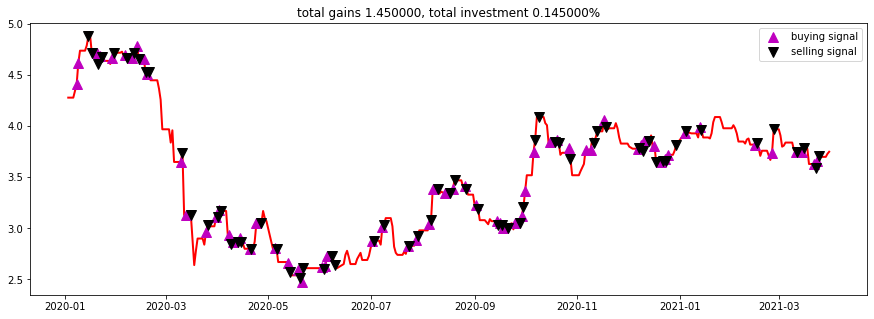

In [228]:
# Plot the results

plot_signals(values = M_actual)

##### Predicted Values

In [229]:
# Define the values for the S Stock

close = M_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -0.741430.3, cost: 0.000033, total money: 995.661007
epoch: 20, total rewards: -0.785100.3, cost: 0.000033, total money: 995.617337
epoch: 30, total rewards: -3.491430.3, cost: 0.000050, total money: 992.911007
epoch: 40, total rewards: 0.008570.3, cost: 0.000027, total money: 996.411007
epoch: 50, total rewards: -0.151430.3, cost: 0.000027, total money: 996.251007
epoch: 60, total rewards: -0.205254.3, cost: 0.000027, total money: 996.197183
epoch: 70, total rewards: -1.251430.3, cost: 0.000033, total money: 995.151007
epoch: 80, total rewards: -0.081430.3, cost: 0.000025, total money: 996.321007
epoch: 90, total rewards: -0.332214.3, cost: 0.000027, total money: 996.070223
epoch: 100, total rewards: -0.657462.3, cost: 0.000027, total money: 995.744975


In [230]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 5: buy 1 unit at price 4.740000, total balance 995.260000
day 6: buy 1 unit at price 4.790000, total balance 990.470000
day 7, sell 1 unit at price 4.880000, investment 2.953586 %, total balance 995.350000,
day 8, sell 1 unit at price 4.890000, investment 2.087683 %, total balance 1000.240000,
day 9: buy 1 unit at price 4.720000, total balance 995.520000
day 10: buy 1 unit at price 4.720000, total balance 990.800000
day 12, sell 1 unit at price 4.690000, investment -0.635593 %, total balance 995.490000,
day 13, sell 1 unit at price 4.680000, investment -0.847458 %, total balance 1000.170000,
day 15: buy 1 unit at price 4.640000, total balance 995.530000
day 17, sell 1 unit at price 4.670000, investment 0.646552 %, total balance 1000.200000,
day 20: buy 1 unit at price 4.720000, total balance 995.480000
day 21, sell 1 unit at price 4.730000, investment 0.211864 %, total balance 1000.210000,
day 23: buy 1 unit at price 4.700000, total balance 995.510000
day 25: buy 1 unit at price 4.

day 290, sell 1 unit at price 3.920237, investment 5.832087 %, total balance 999.674751,
day 291: buy 1 unit at price 3.950284, total balance 995.724467
day 292: buy 1 unit at price 3.868544, total balance 991.855923
day 293: buy 1 unit at price 3.801425, total balance 988.054498
day 296, sell 1 unit at price 3.785260, investment -4.177525 %, total balance 991.839758,
day 297, sell 1 unit at price 3.756784, investment -2.888955 %, total balance 995.596542,
day 298: buy 1 unit at price 3.729597, total balance 991.866945
day 300, sell 1 unit at price 3.748026, investment -1.404710 %, total balance 995.614971,
day 301, sell 1 unit at price 3.772127, investment 1.140343 %, total balance 999.387098,
day 303: buy 1 unit at price 3.690423, total balance 995.696675
day 304: buy 1 unit at price 3.634116, total balance 992.062559
day 306: buy 1 unit at price 3.597563, total balance 988.464996
day 307, sell 1 unit at price 3.650773, investment -1.074411 %, total balance 992.115769,
day 308, sell 

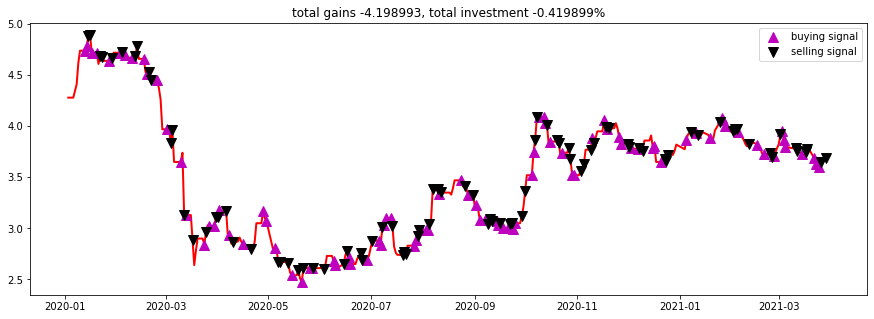

In [231]:
# Plot the results

plot_signals(values = M_predictions)

#### BEEF Stock

##### Actual Values

In [232]:
# Define the values for the S Stock

close = BEEF_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -1.980000.3, cost: 0.313894, total money: 61.970000
epoch: 20, total rewards: -11.630000.3, cost: 0.296829, total money: 74.510000
epoch: 30, total rewards: 17.390000.3, cost: 0.271012, total money: 113.540000
epoch: 40, total rewards: 2.760000.3, cost: 0.197766, total money: 239.050000
epoch: 50, total rewards: -23.470000.3, cost: 0.144830, total money: 341.890000
epoch: 60, total rewards: -47.700000.3, cost: 0.111727, total money: 416.210000
epoch: 70, total rewards: -55.360000.3, cost: 0.075871, total money: 513.380000
epoch: 80, total rewards: -65.590000.3, cost: 0.072377, total money: 519.850000
epoch: 90, total rewards: -70.110000.3, cost: 0.056539, total money: 590.960000
epoch: 100, total rewards: -76.210000.3, cost: 0.051063, total money: 607.270000


In [233]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 14: buy 1 unit at price 13.100000, total balance 986.900000
day 15, sell 1 unit at price 12.030000, investment -8.167939 %, total balance 998.930000,
day 16: buy 1 unit at price 12.150000, total balance 986.780000
day 18: buy 1 unit at price 11.420000, total balance 975.360000
day 19: buy 1 unit at price 11.930000, total balance 963.430000
day 21: buy 1 unit at price 12.040000, total balance 951.390000
day 25: buy 1 unit at price 10.680000, total balance 940.710000
day 27, sell 1 unit at price 11.660000, investment -4.032922 %, total balance 952.370000,
day 28: buy 1 unit at price 11.840000, total balance 940.530000
day 36: buy 1 unit at price 11.800000, total balance 928.730000
day 39: buy 1 unit at price 12.080000, total balance 916.650000
day 40: buy 1 unit at price 11.970000, total balance 904.680000
day 42: buy 1 unit at price 11.300000, total balance 893.380000
day 44: buy 1 unit at price 8.850000, total balance 884.530000
day 46: buy 1 unit at price 6.970000, total balance 8

day 249, sell 1 unit at price 10.180000, investment -23.516153 %, total balance 578.030000,
day 250, sell 1 unit at price 10.040000, investment -23.417239 %, total balance 588.070000,
day 251: buy 1 unit at price 9.840000, total balance 578.230000
day 252, sell 1 unit at price 9.690000, investment -25.860750 %, total balance 587.920000,
day 253: buy 1 unit at price 9.730000, total balance 578.190000
day 254, sell 1 unit at price 9.610000, investment -27.471698 %, total balance 587.800000,
day 255: buy 1 unit at price 9.990000, total balance 577.810000
day 256, sell 1 unit at price 9.800000, investment -24.031008 %, total balance 587.610000,
day 258: buy 1 unit at price 9.720000, total balance 577.890000
day 259, sell 1 unit at price 9.770000, investment -26.430723 %, total balance 587.660000,
day 260: buy 1 unit at price 9.580000, total balance 578.080000
day 261, sell 1 unit at price 9.500000, investment -29.785661 %, total balance 587.580000,
day 262: buy 1 unit at price 9.340000, to

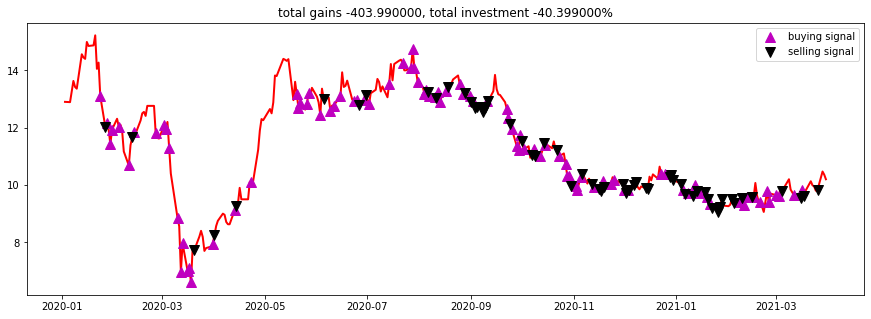

In [234]:
# Plot the results

plot_signals(values = BEEF_actual)

##### Predicted Values

In [235]:
# Define the values for the S Stock

close = BEEF_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 5.100954.3, cost: 0.002324, total money: 937.338186
epoch: 20, total rewards: 2.728913.3, cost: 0.000965, total money: 963.741538
epoch: 30, total rewards: 0.729767.3, cost: 0.000995, total money: 961.742392
epoch: 40, total rewards: 8.913672.3, cost: 0.000827, total money: 969.926297
epoch: 50, total rewards: 13.406501.3, cost: 0.000930, total money: 964.912808
epoch: 60, total rewards: 9.897775.3, cost: 0.001223, total money: 961.404082
epoch: 70, total rewards: 16.418657.3, cost: 0.000975, total money: 977.867321
epoch: 80, total rewards: 10.615047.3, cost: 0.000686, total money: 991.214232
epoch: 90, total rewards: 13.555047.3, cost: 0.000600, total money: 994.154232
epoch: 100, total rewards: 13.555047.3, cost: 0.000584, total money: 994.154232


In [236]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 13.630000, total balance 986.370000
day 3, sell 1 unit at price 13.420000, investment -1.540719 %, total balance 999.790000,
day 5: buy 1 unit at price 14.560000, total balance 985.230000
day 6, sell 1 unit at price 14.450000, investment -0.755495 %, total balance 999.680000,
day 16: buy 1 unit at price 12.150000, total balance 987.530000
day 17: buy 1 unit at price 11.930000, total balance 975.600000
day 18: buy 1 unit at price 11.420000, total balance 964.180000
day 19: buy 1 unit at price 11.930000, total balance 952.250000
day 20, sell 1 unit at price 12.310000, investment 1.316872 %, total balance 964.560000,
day 21, sell 1 unit at price 12.040000, investment 0.922045 %, total balance 976.600000,
day 22, sell 1 unit at price 12.100000, investment 5.954466 %, total balance 988.700000,
day 23, sell 1 unit at price 11.900000, investment -0.251467 %, total balance 1000.600000,
day 25: buy 1 unit at price 10.680000, total balance 989.920000
day 26: buy 1 unit

day 220, sell 1 unit at price 9.940000, investment -3.401361 %, total balance 968.590000,
day 221, sell 1 unit at price 9.940000, investment -4.423077 %, total balance 978.530000,
day 222, sell 1 unit at price 10.040000, investment 1.006036 %, total balance 988.570000,
day 223, sell 1 unit at price 10.270000, investment 4.795918 %, total balance 998.840000,
day 226, sell 1 unit at price 10.130000, investment -0.197044 %, total balance 1008.970000,
day 229: buy 1 unit at price 9.730000, total balance 999.240000
day 230: buy 1 unit at price 9.810000, total balance 989.430000
day 231: buy 1 unit at price 9.830000, total balance 979.600000
day 232: buy 1 unit at price 10.010000, total balance 969.590000
day 234, sell 1 unit at price 9.920000, investment 1.952724 %, total balance 979.510000,
day 236, sell 1 unit at price 9.950000, investment 1.427115 %, total balance 989.460000,
day 237, sell 1 unit at price 9.880000, investment 0.508647 %, total balance 999.340000,
day 238: buy 1 unit at p

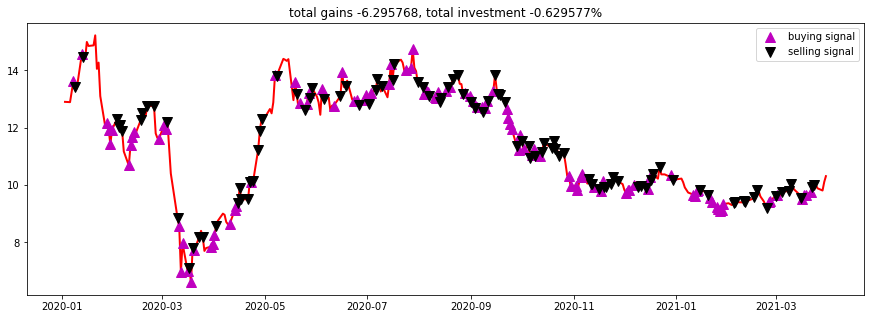

In [237]:
# Plot the results

plot_signals(values = BEEF_predictions)

#### P Stock

##### Actual Values

In [238]:
# Define the values for the S Stock

close = P_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 3.250000.3, cost: 0.034220, total money: 1003.250000
epoch: 20, total rewards: -1.350000.3, cost: 0.026854, total money: 998.650000
epoch: 30, total rewards: 2.850000.3, cost: 0.030890, total money: 1002.850000
epoch: 40, total rewards: 4.050000.3, cost: 0.028679, total money: 1004.050000
epoch: 50, total rewards: 0.200000.3, cost: 0.025134, total money: 1000.200000
epoch: 60, total rewards: 2.600000.3, cost: 0.024824, total money: 1002.600000
epoch: 70, total rewards: 13.700000.3, cost: 0.022985, total money: 1013.700000
epoch: 80, total rewards: 18.000000.3, cost: 0.021369, total money: 1018.000000
epoch: 90, total rewards: 1.950000.3, cost: 0.021024, total money: 1001.950000
epoch: 100, total rewards: 10.950000.3, cost: 0.019418, total money: 1010.950000


In [239]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 48.500000, total balance 951.500000
day 2, sell 1 unit at price 46.500000, investment -4.123711 %, total balance 998.000000,
day 11: buy 1 unit at price 46.900000, total balance 951.100000
day 12, sell 1 unit at price 48.450000, investment 3.304904 %, total balance 999.550000,
day 13: buy 1 unit at price 46.400000, total balance 953.150000
day 14, sell 1 unit at price 44.800000, investment -3.448276 %, total balance 997.950000,
day 34: buy 1 unit at price 42.450000, total balance 955.500000
day 35, sell 1 unit at price 42.450000, investment 0.000000 %, total balance 997.950000,
day 36: buy 1 unit at price 39.250000, total balance 958.700000
day 37, sell 1 unit at price 39.400000, investment 0.382166 %, total balance 998.100000,
day 42: buy 1 unit at price 45.750000, total balance 952.350000
day 43: buy 1 unit at price 43.650000, total balance 908.700000
day 44, sell 1 unit at price 40.900000, investment -10.601093 %, total balance 949.600000,
day 45, sell 1 u

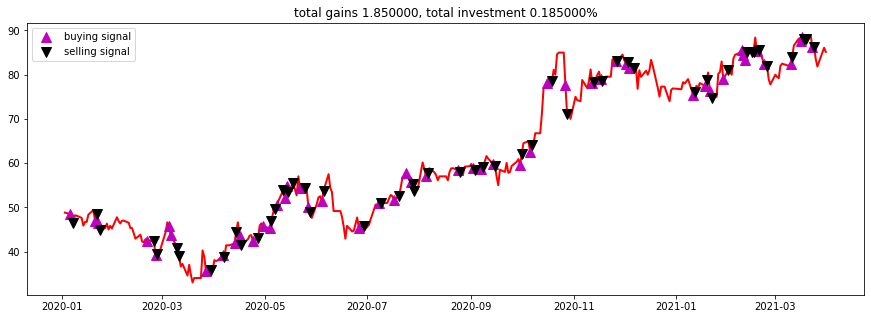

In [240]:
# Plot the results

plot_signals(values = P_actual)

##### Predicted Values

In [241]:
# Define the values for the S Stock

close = P_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 58.057112.3, cost: 0.038215, total money: 887.804950
epoch: 20, total rewards: 60.512827.3, cost: 0.039211, total money: 719.954051
epoch: 30, total rewards: 62.962827.3, cost: 0.035826, total money: 722.404051
epoch: 40, total rewards: 47.464735.3, cost: 0.032196, total money: 794.810194
epoch: 50, total rewards: 50.598148.3, cost: 0.029349, total money: 797.943607
epoch: 60, total rewards: 52.868085.3, cost: 0.026836, total money: 800.213544
epoch: 70, total rewards: 40.097238.3, cost: 0.019868, total money: 787.442697
epoch: 80, total rewards: 39.297238.3, cost: 0.018457, total money: 786.642697
epoch: 90, total rewards: 50.376617.3, cost: 0.015870, total money: 797.722076
epoch: 100, total rewards: 44.126617.3, cost: 0.015402, total money: 791.472076


In [242]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 48.500000, total balance 951.500000
day 2: buy 1 unit at price 46.500000, total balance 905.000000
day 3, sell 1 unit at price 48.200000, investment -0.618557 %, total balance 953.200000,
day 4, sell 1 unit at price 48.100000, investment 3.440860 %, total balance 1001.300000,
day 7: buy 1 unit at price 46.700000, total balance 954.600000
day 8, sell 1 unit at price 46.700000, investment 0.000000 %, total balance 1001.300000,
day 11: buy 1 unit at price 46.900000, total balance 954.400000
day 12, sell 1 unit at price 48.450000, investment 3.304904 %, total balance 1002.850000,
day 26: buy 1 unit at price 45.300000, total balance 957.550000
day 27: buy 1 unit at price 45.300000, total balance 912.250000
day 30, sell 1 unit at price 43.800000, investment -3.311258 %, total balance 956.050000,
day 33, sell 1 unit at price 42.800000, investment -5.518764 %, total balance 998.850000,
day 36: buy 1 unit at price 39.250000, total balance 959.600000
day 37: buy 1 unit

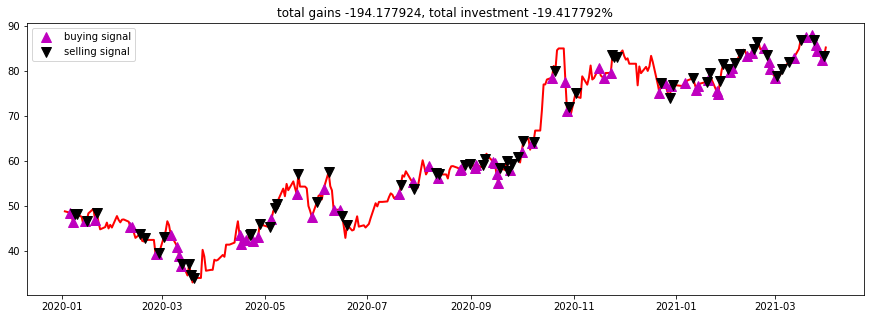

In [243]:
# Plot the results

plot_signals(values = P_predictions)

#### C Stock

##### Actual Values

In [244]:
# Different variables for this stock (May vary depending on the stock)
initial_money = 10000

# Define the values for the S Stock

close = C_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -1073.000000.3, cost: 0.314538, total money: 8927.000000
epoch: 20, total rewards: 912.000000.3, cost: 0.127065, total money: 10912.000000
epoch: 30, total rewards: 3073.000000.3, cost: 0.267878, total money: 13073.000000
epoch: 40, total rewards: 1656.000000.3, cost: 0.062428, total money: 11656.000000
epoch: 50, total rewards: 1324.000000.3, cost: 0.059678, total money: 11324.000000
epoch: 60, total rewards: 1192.000000.3, cost: 0.040443, total money: 11192.000000
epoch: 70, total rewards: 906.000000.3, cost: 0.034479, total money: 10906.000000
epoch: 80, total rewards: 582.000000.3, cost: 0.037767, total money: 10582.000000
epoch: 90, total rewards: 441.000000.3, cost: 0.067692, total money: 10441.000000
epoch: 100, total rewards: 981.000000.3, cost: 0.021622, total money: 10981.000000


In [245]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 6: buy 1 unit at price 6640.000000, total balance 3360.000000
day 7, sell 1 unit at price 6570.000000, investment -1.054217 %, total balance 9930.000000,
day 23: buy 1 unit at price 6390.000000, total balance 3540.000000
day 24, sell 1 unit at price 6310.000000, investment -1.251956 %, total balance 9850.000000,
day 32: buy 1 unit at price 6110.000000, total balance 3740.000000
day 33, sell 1 unit at price 6060.000000, investment -0.818331 %, total balance 9800.000000,
day 49: buy 1 unit at price 3200.000000, total balance 6600.000000
day 50, sell 1 unit at price 2585.000000, investment -19.218750 %, total balance 9185.000000,
day 55: buy 1 unit at price 3300.000000, total balance 5885.000000
day 56, sell 1 unit at price 3930.000000, investment 19.090909 %, total balance 9815.000000,
day 60: buy 1 unit at price 3900.000000, total balance 5915.000000
day 61, sell 1 unit at price 3990.000000, investment 2.307692 %, total balance 9905.000000,
day 75: buy 1 unit at price 3680.000000, t

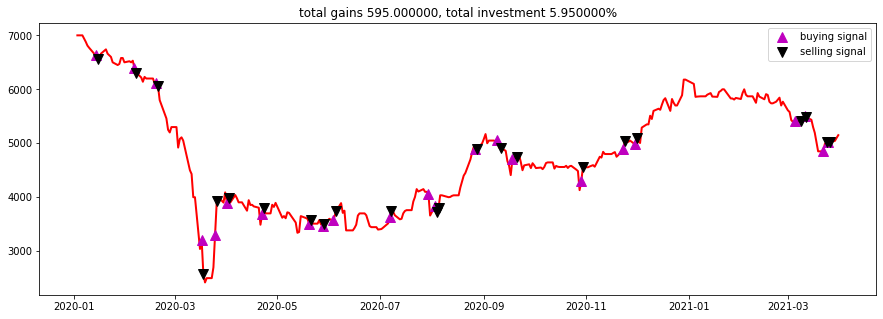

In [246]:
# Plot the results

plot_signals(values = C_actual)

##### Predicted Values

In [247]:
# Define the values for the S Stock

close = C_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 2548.398684.3, cost: 0.448680, total money: 12548.398684
epoch: 20, total rewards: 3571.680202.3, cost: 0.250910, total money: 13571.680202
epoch: 30, total rewards: 1603.065046.3, cost: 0.145264, total money: 11603.065046
epoch: 40, total rewards: 2156.430114.3, cost: 0.104126, total money: 12156.430114
epoch: 50, total rewards: 622.034023.3, cost: 0.098129, total money: 10622.034023
epoch: 60, total rewards: 1040.069972.3, cost: 0.075119, total money: 11040.069972
epoch: 70, total rewards: 2232.050367.3, cost: 0.057355, total money: 12232.050367
epoch: 80, total rewards: 2378.050367.3, cost: 0.054305, total money: 12378.050367
epoch: 90, total rewards: 882.457762.3, cost: 0.058406, total money: 10882.457762
epoch: 100, total rewards: 1203.160434.3, cost: 0.045691, total money: 11203.160434


In [248]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 6: buy 1 unit at price 6640.000000, total balance 3360.000000
day 8, sell 1 unit at price 6580.000000, investment -0.903614 %, total balance 9940.000000,
day 10: buy 1 unit at price 6740.000000, total balance 3200.000000
day 11, sell 1 unit at price 6660.000000, investment -1.186944 %, total balance 9860.000000,
day 16: buy 1 unit at price 6470.000000, total balance 3390.000000
day 17, sell 1 unit at price 6580.000000, investment 1.700155 %, total balance 9970.000000,
day 27: buy 1 unit at price 6230.000000, total balance 3740.000000
day 28, sell 1 unit at price 6200.000000, investment -0.481541 %, total balance 9940.000000,
day 37: buy 1 unit at price 5200.000000, total balance 4740.000000
day 38, sell 1 unit at price 5300.000000, investment 1.923077 %, total balance 10040.000000,
day 53: buy 1 unit at price 2500.000000, total balance 7540.000000
day 54, sell 1 unit at price 2700.000000, investment 8.000000 %, total balance 10240.000000,
day 58: buy 1 unit at price 3900.000000, to

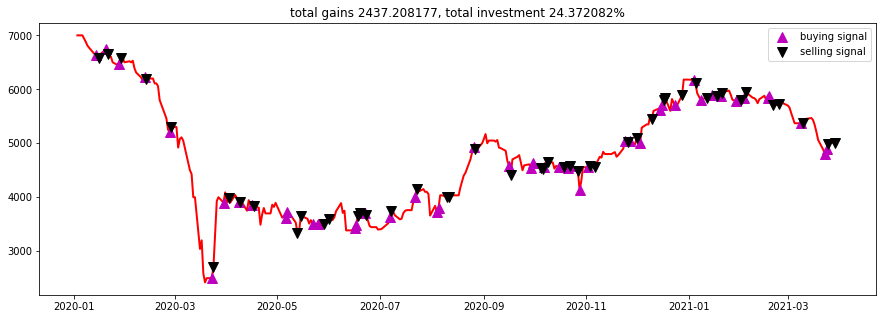

In [249]:
# Plot the results

plot_signals(values = C_predictions)

#### IP Stock

##### Actual Values

In [250]:
# Different variables for this stock (May vary depending on the stock)
initial_money = 100000

# Define the values for the S Stock

close = IP_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 4620.000000.3, cost: nan, total money: 83826.000000
epoch: 20, total rewards: 5639.000000.3, cost: nan, total money: 105639.000000
epoch: 30, total rewards: 0.000000.3, cost: nan, total money: 57688.000000
epoch: 40, total rewards: 4019.000000.3, cost: nan, total money: 104019.000000
epoch: 50, total rewards: 0.000000.3, cost: nan, total money: 88011.000000
epoch: 60, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 70, total rewards: 0.000000.3, cost: nan, total money: 65439.000000
epoch: 80, total rewards: 4044.000000.3, cost: nan, total money: 104044.000000
epoch: 90, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 100, total rewards: 0.000000.3, cost: nan, total money: 100000.000000


In [251]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 144: buy 1 unit at price 15600.000000, total balance 84400.000000
day 221: buy 1 unit at price 16541.000000, total balance 67859.000000


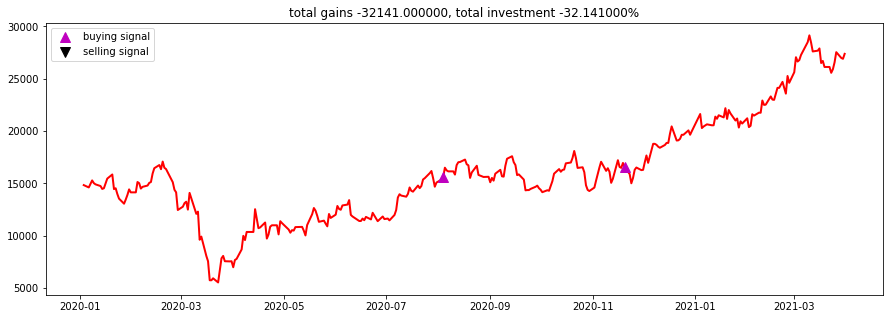

In [252]:
# Plot the results

plot_signals(values = IP_actual)

##### Predicted Values

In [253]:
# Define the values for the S Stock

close = IP_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 26089.826172.3, cost: 0.039391, total money: 85952.055664
epoch: 20, total rewards: 11230.461914.3, cost: 0.013344, total money: 84990.021484
epoch: 30, total rewards: -1774.673828.3, cost: 0.006879, total money: 98225.326172
epoch: 40, total rewards: -343.000000.3, cost: 0.013459, total money: 27621.599609
epoch: 50, total rewards: 25797.000000.3, cost: 0.087317, total money: 125797.000000
epoch: 60, total rewards: 27028.287109.3, cost: 0.021898, total money: 106150.516602
epoch: 70, total rewards: 5708.326172.3, cost: 0.009382, total money: 105708.326172
epoch: 80, total rewards: 0.000000.3, cost: 0.006041, total money: 100000.000000
epoch: 90, total rewards: 3305.000000.3, cost: 0.004554, total money: 103305.000000
epoch: 100, total rewards: 0.000000.3, cost: 0.005091, total money: 100000.000000


In [254]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

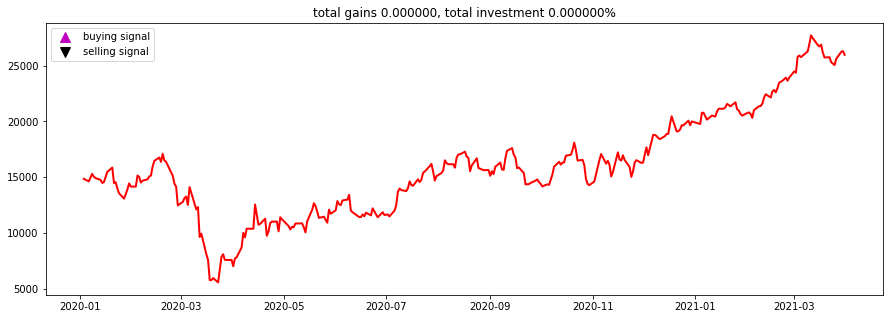

In [255]:
# Plot the results

plot_signals(values = IP_predictions)

#### DS Stock

##### Actual Values

In [256]:
# Define the values for the S Stock

close = DS_actual.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 2030.000000.3, cost: 3.152779, total money: 102030.000000
epoch: 20, total rewards: 2640.000000.3, cost: 0.395363, total money: 102640.000000
epoch: 30, total rewards: 1190.000000.3, cost: 0.202150, total money: 101190.000000
epoch: 40, total rewards: 895.000000.3, cost: 0.368723, total money: 100895.000000
epoch: 50, total rewards: 2330.000000.3, cost: 1.561705, total money: 102330.000000
epoch: 60, total rewards: 500.000000.3, cost: 0.236367, total money: 100500.000000
epoch: 70, total rewards: -470.000000.3, cost: 0.717497, total money: 99530.000000
epoch: 80, total rewards: -425.000000.3, cost: 0.543186, total money: 99575.000000
epoch: 90, total rewards: -350.000000.3, cost: 0.604423, total money: 99650.000000
epoch: 100, total rewards: -2270.000000.3, cost: 0.208252, total money: 97730.000000


In [257]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3: buy 1 unit at price 5490.000000, total balance 94510.000000
day 4, sell 1 unit at price 5500.000000, investment 0.182149 %, total balance 100010.000000,
day 5: buy 1 unit at price 5520.000000, total balance 94490.000000
day 6, sell 1 unit at price 5510.000000, investment -0.181159 %, total balance 100000.000000,
day 7: buy 1 unit at price 5550.000000, total balance 94450.000000
day 9, sell 1 unit at price 5490.000000, investment -1.081081 %, total balance 99940.000000,
day 10: buy 1 unit at price 5490.000000, total balance 94450.000000
day 11, sell 1 unit at price 5460.000000, investment -0.546448 %, total balance 99910.000000,
day 18: buy 1 unit at price 4935.000000, total balance 94975.000000
day 19, sell 1 unit at price 4920.000000, investment -0.303951 %, total balance 99895.000000,
day 23: buy 1 unit at price 5330.000000, total balance 94565.000000
day 25: buy 1 unit at price 5410.000000, total balance 89155.000000
day 29, sell 1 unit at price 5370.000000, investment 0.7504

day 217, sell 1 unit at price 7120.000000, investment 4.860088 %, total balance 98505.000000,
day 228: buy 1 unit at price 7580.000000, total balance 90925.000000
day 230: buy 1 unit at price 7700.000000, total balance 83225.000000
day 231, sell 1 unit at price 7770.000000, investment 2.506596 %, total balance 90995.000000,
day 232, sell 1 unit at price 7560.000000, investment -1.818182 %, total balance 98555.000000,
day 233: buy 1 unit at price 7290.000000, total balance 91265.000000
day 234, sell 1 unit at price 7870.000000, investment 7.956104 %, total balance 99135.000000,
day 236: buy 1 unit at price 7970.000000, total balance 91165.000000
day 237, sell 1 unit at price 7940.000000, investment -0.376412 %, total balance 99105.000000,
day 241: buy 1 unit at price 8100.000000, total balance 91005.000000
day 242, sell 1 unit at price 8180.000000, investment 0.987654 %, total balance 99185.000000,
day 244: buy 1 unit at price 7820.000000, total balance 91365.000000
day 245: buy 1 unit 

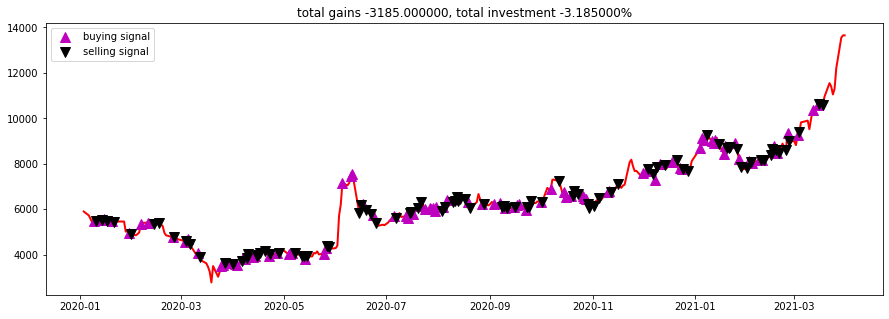

In [258]:
# Plot the results

plot_signals(values = DS_actual)

##### Predicted Values

In [259]:
# Define the values for the S Stock

close = DS_predictions.values.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 1363.516357.3, cost: 0.258663, total money: 101363.516357
epoch: 20, total rewards: 4544.990723.3, cost: 0.079158, total money: 73279.626465
epoch: 30, total rewards: 7017.266113.3, cost: 0.051685, total money: 75751.901855
epoch: 40, total rewards: 4187.089355.3, cost: 0.037912, total money: 93407.796387
epoch: 50, total rewards: 7068.444092.3, cost: 0.066929, total money: 107068.444092
epoch: 60, total rewards: 7465.175293.3, cost: 0.036736, total money: 96685.882324
epoch: 70, total rewards: 9862.392090.3, cost: 0.052962, total money: 88854.317383
epoch: 80, total rewards: 5099.374268.3, cost: 0.025081, total money: 94320.081299
epoch: 90, total rewards: 2643.070068.3, cost: 0.029042, total money: 91863.777100
epoch: 100, total rewards: 2612.245605.3, cost: 0.039693, total money: 91832.952637


In [260]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 13: buy 1 unit at price 5460.000000, total balance 94540.000000
day 14, sell 1 unit at price 5460.000000, investment 0.000000 %, total balance 100000.000000,
day 15: buy 1 unit at price 5460.000000, total balance 94540.000000
day 17, sell 1 unit at price 5020.000000, investment -8.058608 %, total balance 99560.000000,
day 18: buy 1 unit at price 4935.000000, total balance 94625.000000
day 20, sell 1 unit at price 4855.000000, investment -1.621074 %, total balance 99480.000000,
day 25: buy 1 unit at price 5410.000000, total balance 94070.000000
day 26: buy 1 unit at price 5540.000000, total balance 88530.000000
day 27, sell 1 unit at price 5500.000000, investment 1.663586 %, total balance 94030.000000,
day 28: buy 1 unit at price 5420.000000, total balance 88610.000000
day 30, sell 1 unit at price 5380.000000, investment -2.888087 %, total balance 93990.000000,
day 31: buy 1 unit at price 5330.000000, total balance 88660.000000
day 34, sell 1 unit at price 4855.000000, investment -1

day 222, sell 1 unit at price 8070.000000, investment 20.447761 %, total balance 88420.000000,
day 223, sell 1 unit at price 8180.000000, investment 17.867435 %, total balance 96600.000000,
day 226: buy 1 unit at price 7690.000000, total balance 88910.000000
day 227: buy 1 unit at price 7450.000000, total balance 81460.000000
day 228: buy 1 unit at price 7580.000000, total balance 73880.000000
day 229: buy 1 unit at price 7630.000000, total balance 66250.000000
day 231, sell 1 unit at price 7770.000000, investment 1.040312 %, total balance 74020.000000,
day 232: buy 1 unit at price 7560.000000, total balance 66460.000000
day 234, sell 1 unit at price 7870.000000, investment 5.637584 %, total balance 74330.000000,
day 235, sell 1 unit at price 7870.000000, investment 3.825858 %, total balance 82200.000000,
day 236, sell 1 unit at price 7970.000000, investment 4.456094 %, total balance 90170.000000,
day 238: buy 1 unit at price 7800.000000, total balance 82370.000000
day 239, sell 1 unit

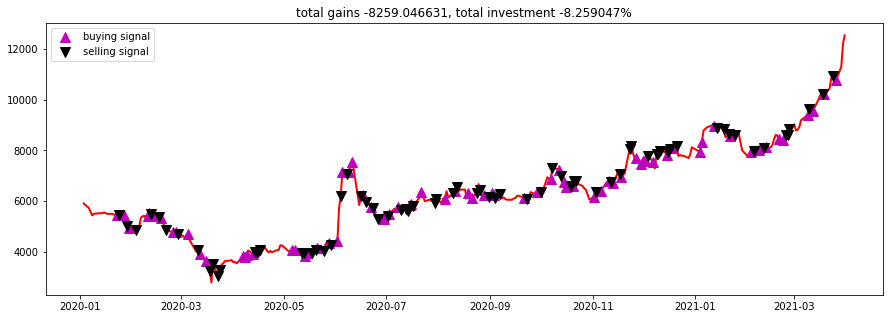

In [261]:
# Plot the results

plot_signals(values = DS_predictions)

## Approach

1. Get the historical data of the stock prices
2. Preprocess the data. Apply MinMax Scaler, re arrange the data and use the 5 days prior as independant variables and the day ahead as the dependant variable and make sure to use the correct dimensions for the data, and after applying the MinMax Scaler, prevent data leakeage by just fitting the train data
3. To foreast values, we are going to to use LSTM to see the general trend. As a note, depending on the days of data and the number of days used as independant features, we may be able to forecast prices with a longer period.
4. To calculate the next day forecast, we are using arima model (This won't work for long forecasting periods as it would capture the general trend).
5. To calculate the overal performance of both, we are using the bollinger bands and each indicator would give buy-sell signals.
6. We are calculating the weighted average between the arima model and the LSTM model.
7. We are using reinforcement learnings to check the overal buy and sell recommendations based on the forecast made with the LSTM and compare the results with the actual results. For the reinforcement learning you should input a sufficient initial investment to cover one stock price

## Other Stocks

### BRF SA

In [428]:
# Create a function that reads the data from yahoo finance
def stock_data(ticker, data_source, start, end):
    df = DataReader(ticker, data_source, start, end)['Adj Close']
    df = df.to_frame(ticker) 
    return df

In [429]:
def feature_engineering(train_array, test_array, time_steps):
    scaler = MinMaxScaler(feature_range = (0,1))
    a = train_array.reshape(-1,1)
    b = test_array.reshape(-1,1)
    scaler = scaler.fit(a)
    X = scaler.transform(a)
    y = scaler.transform(b)
    
    data = np.append(X, y).reshape(-1,1)
    
    dataX, dataY = [], []
    
    for i in range(len(data)-time_steps-1):
        c = data[i:(i+time_steps), 0]   
        dataX.append(c)
        dataY.append(data[i + time_steps, 0])
        
    # Divide one again into train and test data

    X_train = np.array(dataX[:len(train_array)- time - 1])
    y_train = np.array(dataY[:len(train_array)- time - 1])

    X_test = np.array(dataX[len(train_array)- time - 1:])
    y_test = np.array(dataY[len(train_array)- time -1:])
    
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
        
    return X_train, y_train, X_test, y_test

In [430]:
def weighted_predictions(stock, lstm_predictions, arima_predictions):
    outcome = (lstm_predictions*0.5) + (arima_predictions*0.5)
    df = pd.DataFrame()
    df['Date'] = stock['2021'].index
    df.set_index('Date', inplace = True)
    df['Price'] = outcome
    df.columns = stock.columns
    return df
    

In [431]:
#Define variables of data source, start and end date

start = datetime.date(2020,1,1)
end = datetime.date(2021,3,31)
source = 'yahoo'

In [432]:
# Get BRFS stock data

brfs_stock = stock_data('BRFS3.SA', source, start, end)

In [433]:
# Train and test data set

brfs_train = brfs_stock['2020'].values

brfs_test = brfs_stock['2021'].values

In [434]:
# Apply feature engineering

brfs_xtrain, brfs_ytrain, brfs_xtest, brfs_ytest = feature_engineering(train_array = brfs_train, 
                                                                       test_array = brfs_test, time_steps = 5)

In [435]:
# Define the neural network model

model = neural_network()

In [436]:
# Use the function to predict

brfs_pred = model_fit(Xtr = brfs_xtrain, ytr = brfs_ytrain, Xte = brfs_xtest)

Train on 241 samples
Epoch 1/100
241/241 [==============================] - 0s 642us/sample - loss: 0.1477
Epoch 2/100
241/241 [==============================] - 0s 819us/sample - loss: 0.0579
Epoch 3/100
241/241 [==============================] - 0s 670us/sample - loss: 0.0260
Epoch 4/100
241/241 [==============================] - 0s 595us/sample - loss: 0.0177
Epoch 5/100
241/241 [==============================] - 0s 533us/sample - loss: 0.0139
Epoch 6/100
241/241 [==============================] - 0s 654us/sample - loss: 0.0106
Epoch 7/100
241/241 [==============================] - 0s 572us/sample - loss: 0.0060
Epoch 8/100
241/241 [==============================] - 0s 694us/sample - loss: 0.0068
Epoch 9/100
241/241 [==============================] - 0s 558us/sample - loss: 0.0061
Epoch 10/100
241/241 [==============================] - 0s 647us/sample - loss: 0.0061
Epoch 11/100
241/241 [==============================] - 0s 689us/sample - loss: 0.0061
Epoch 12/100
241/241 [=========

241/241 [==============================] - 0s 528us/sample - loss: 0.0042
Epoch 96/100
241/241 [==============================] - 0s 498us/sample - loss: 0.0045
Epoch 97/100
241/241 [==============================] - 0s 493us/sample - loss: 0.0044
Epoch 98/100
241/241 [==============================] - 0s 479us/sample - loss: 0.0045
Epoch 99/100
241/241 [==============================] - 0s 469us/sample - loss: 0.0039
Epoch 100/100
241/241 [==============================] - 0s 492us/sample - loss: 0.0041


In [437]:
# Use the inverse transform function

brfs_pred = scaler_inverse(train_array = brfs_stock.values, predictions = brfs_pred)

brfs_pred = brfs_pred.reshape(brfs_pred.shape[0])


In [438]:
# Run the arima function

arima_selection(values = brfs_stock)

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  306
 Model:               SARIMAX(0, 1, 0)   Log Likelihood                -343.059
 Date:                Sun, 13 Jun 2021   AIC                            688.118
 Time:                        18:42:59   BIC                            691.839
 Sample:                             0   HQIC                           689.606
                                 - 306                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 sigma2         0.5553    

In [439]:
# Get the best order for the stock

brfs_pred_arima = model_fit_arima(df = brfs_stock, col = 'BRFS3.SA', order = (0,1,0))

In [440]:
# Weighted average to do the predictions

brfs_pred = weighted_predictions(stock = brfs_stock, lstm_predictions = brfs_pred, 
                                 arima_predictions = brfs_pred_arima)

In [443]:
# Append data frames

brfs_stock_pred = brfs_stock['2020'].append(brfs_pred)

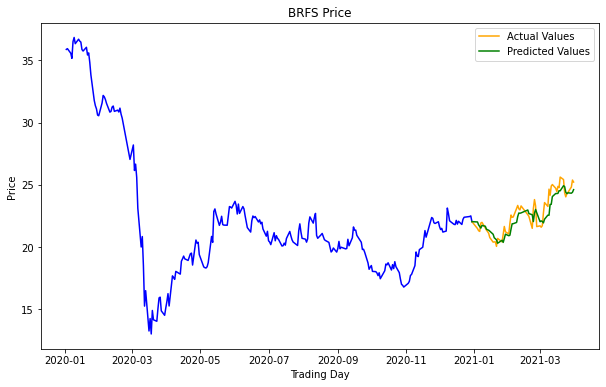

In [445]:
# Plot the graphic

plot_comparison(actual = brfs_stock, predicted = brfs_stock_pred, string = 'BRFS Price')

In [394]:
# Save the predictions and the train in the same data frame

df_brfs_pred = brfs_stock['2020'].append(brfs_pred)

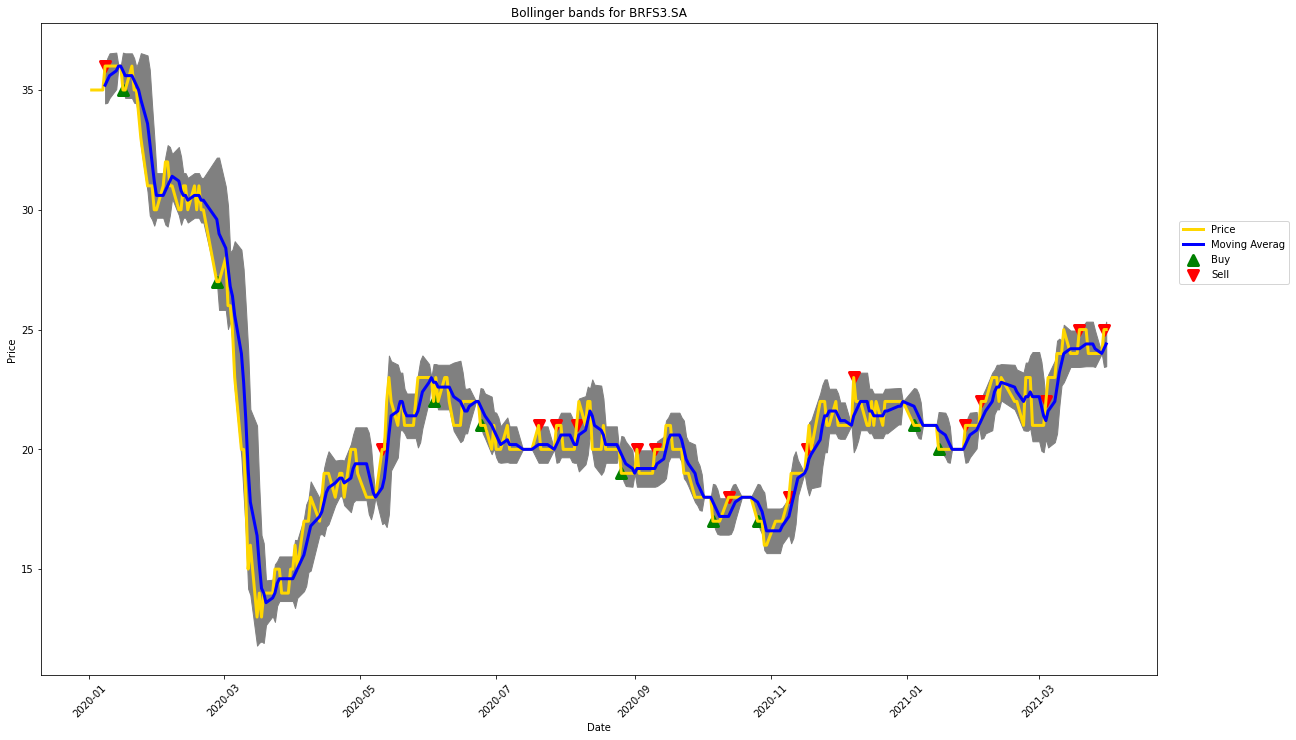

In [395]:
# Bollinger bands for the actual data daily

bollinger_bands(df = brfs_stock, col = 'BRFS3.SA' , p = 5, std = 1.7)

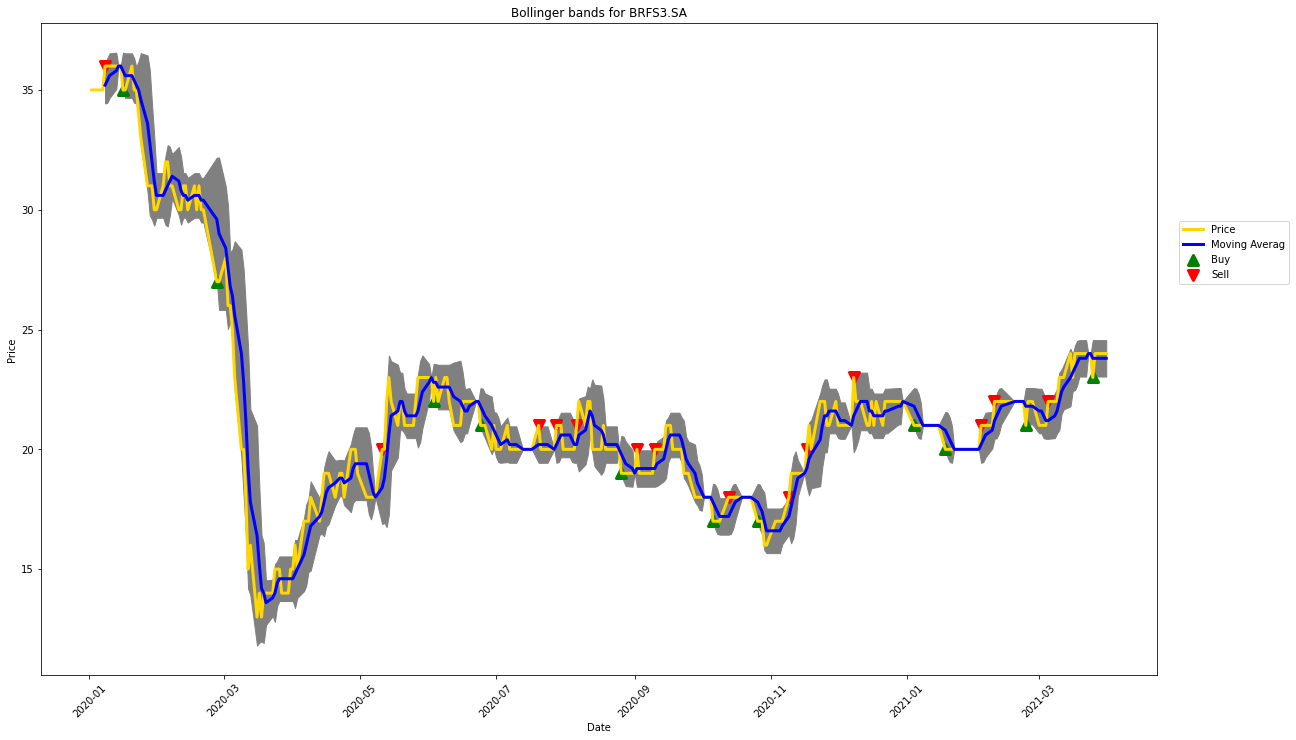

In [396]:
# Bollinger bands for the predicted data daily

bollinger_bands(df = df_brfs_pred, col = 'BRFS3.SA' , p = 5, std = 1.7)

In [397]:
# Define the values for the S Stock

initial_money = 1000

close = df_brfs_pred['BRFS3.SA'].tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)



In [398]:
# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: -147.430106.3, cost: 0.365568, total money: 63.017996
epoch: 20, total rewards: -15.468900.3, cost: 0.351128, total money: 60.811071
epoch: 30, total rewards: -19.303373.3, cost: 0.339301, total money: 52.553087
epoch: 40, total rewards: -5.524004.3, cost: 0.317647, total money: 35.844045
epoch: 50, total rewards: 7.125246.3, cost: 0.291483, total money: 60.526045
epoch: 60, total rewards: 8.058459.3, cost: 0.282496, total money: 31.504998
epoch: 70, total rewards: -5.401542.3, cost: 0.250176, total money: 79.728280
epoch: 80, total rewards: -0.341972.3, cost: 0.214260, total money: 119.424117
epoch: 90, total rewards: 17.118027.3, cost: 0.142053, total money: 261.599712
epoch: 100, total rewards: 3.298668.3, cost: 0.074125, total money: 437.230997


In [399]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 36.509998, total balance 963.490002
day 5: buy 1 unit at price 36.840000, total balance 926.650002
day 6: buy 1 unit at price 36.340000, total balance 890.310001
day 7: buy 1 unit at price 36.700001, total balance 853.610001
day 8: buy 1 unit at price 36.549999, total balance 817.060001
day 9, sell 1 unit at price 36.470001, investment -0.109551 %, total balance 853.530003,
day 10, sell 1 unit at price 35.869999, investment -2.633011 %, total balance 889.400002,
day 13, sell 1 unit at price 35.430000, investment -2.504127 %, total balance 924.830002,
day 14, sell 1 unit at price 35.599998, investment -2.997281 %, total balance 960.430000,
day 15, sell 1 unit at price 34.840000, investment -4.678520 %, total balance 995.270000,
day 19: buy 1 unit at price 31.100000, total balance 964.170000
day 20, sell 1 unit at price 30.600000, investment -1.607717 %, total balance 994.770000,
day 21: buy 1 unit at price 30.549999, total balance 964.220001
day 22: buy 1 unit

day 200, sell 1 unit at price 18.260000, investment -11.787442 %, total balance 372.270001,
day 201, sell 1 unit at price 18.820000, investment -11.435296 %, total balance 391.090001,
day 202, sell 1 unit at price 18.420000, investment -11.823836 %, total balance 409.510001,
day 203: buy 1 unit at price 17.940001, total balance 391.570001
day 204: buy 1 unit at price 17.430000, total balance 374.140000
day 205, sell 1 unit at price 17.000000, investment -17.395529 %, total balance 391.140000,
day 210, sell 1 unit at price 17.709999, investment -13.186277 %, total balance 408.849999,
day 211, sell 1 unit at price 17.799999, investment -16.431925 %, total balance 426.649999,
day 212: buy 1 unit at price 18.500000, total balance 408.149999
day 213: buy 1 unit at price 19.600000, total balance 388.549998
day 214: buy 1 unit at price 19.280001, total balance 369.269998
day 215: buy 1 unit at price 19.230000, total balance 350.039998
day 216: buy 1 unit at price 19.790001, total balance 330.

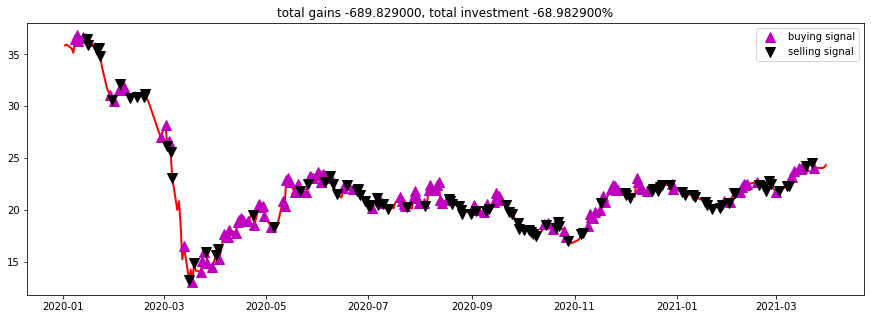

In [400]:
# Plot the results

plot_signals(values = df_brfs_pred['BRFS3.SA'])

### Anglo American Platinum Limited

In [452]:
# Get BRFS stock data

angpy_stock = stock_data('ANGPY', source, start, end)

In [453]:
# Train and test data set

angpy_train = angpy_stock['2020'].values

angpy_test = angpy_stock['2021'].values

In [454]:
# Apply feature engineering

angpy_xtrain, angpy_ytrain, angpy_xtest, angpy_ytest = feature_engineering(train_array = angpy_train, 
                                                                       test_array = angpy_test, time_steps = 5)

In [455]:
# Define the neural network model

model = neural_network()

In [456]:
# Use the function to predict

angpy_pred = model_fit(Xtr = angpy_xtrain, ytr = angpy_ytrain, Xte = angpy_xtest)

Train on 247 samples
Epoch 1/100
247/247 [==============================] - 0s 461us/sample - loss: 0.3282
Epoch 2/100
247/247 [==============================] - 0s 500us/sample - loss: 0.0875
Epoch 3/100
247/247 [==============================] - 0s 425us/sample - loss: 0.0477
Epoch 4/100
247/247 [==============================] - 0s 495us/sample - loss: 0.0213
Epoch 5/100
247/247 [==============================] - 0s 611us/sample - loss: 0.0223
Epoch 6/100
247/247 [==============================] - 0s 450us/sample - loss: 0.0189
Epoch 7/100
247/247 [==============================] - 0s 507us/sample - loss: 0.0176
Epoch 8/100
247/247 [==============================] - 0s 479us/sample - loss: 0.0154
Epoch 9/100
247/247 [==============================] - 0s 485us/sample - loss: 0.0131
Epoch 10/100
247/247 [==============================] - 0s 491us/sample - loss: 0.0137
Epoch 11/100
247/247 [==============================] - 0s 439us/sample - loss: 0.0137
Epoch 12/100
247/247 [=========

247/247 [==============================] - 0s 448us/sample - loss: 0.0095
Epoch 95/100
247/247 [==============================] - 0s 523us/sample - loss: 0.0086
Epoch 96/100
247/247 [==============================] - 0s 468us/sample - loss: 0.0084
Epoch 97/100
247/247 [==============================] - 0s 522us/sample - loss: 0.0082
Epoch 98/100
247/247 [==============================] - 0s 415us/sample - loss: 0.0079
Epoch 99/100
247/247 [==============================] - 0s 509us/sample - loss: 0.0081
Epoch 100/100
247/247 [==============================] - 0s 428us/sample - loss: 0.0078


In [457]:
# Use the inverse transform function

angpy_pred = scaler_inverse(train_array = angpy_stock.values, predictions = angpy_pred)

angpy_pred = angpy_pred.reshape(angpy_pred.shape[0])


In [458]:
# Run the arima function

arima_selection(values = angpy_stock)

(ARIMA(order=(1, 2, 1), scoring_args={}, seasonal_order=(0, 0, 0, 5),
       suppress_warnings=True, with_intercept=False),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  314
 Model:               SARIMAX(1, 2, 1)   Log Likelihood                -244.031
 Date:                Sun, 13 Jun 2021   AIC                            494.062
 Time:                        18:52:49   BIC                            505.291
 Sample:                             0   HQIC                           498.550
                                 - 314                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1         -0.0969    

In [459]:
# Get the best order for the stock

angpy_pred_arima = model_fit_arima(df = angpy_stock, col = 'ANGPY', order = (1,2,1))

In [460]:
# Weighted average to do the predictions

angpy_pred = weighted_predictions(stock = angpy_stock, lstm_predictions = angpy_pred, 
                                  arima_predictions = angpy_pred_arima)

In [461]:
# Append data frames

angpy_stock_pred = angpy_stock['2020'].append(angpy_pred)

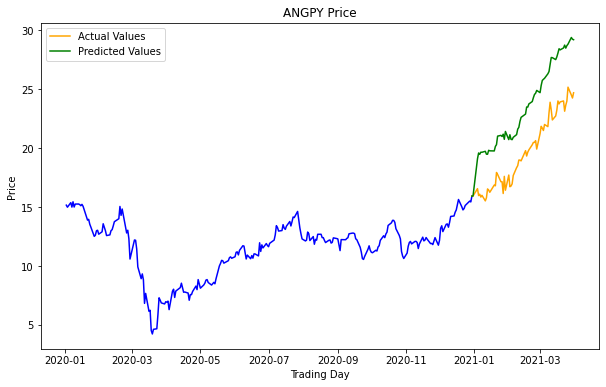

In [462]:
# Plot the graphic

plot_comparison(actual = angpy_stock, predicted = angpy_stock_pred, string = 'ANGPY Price')

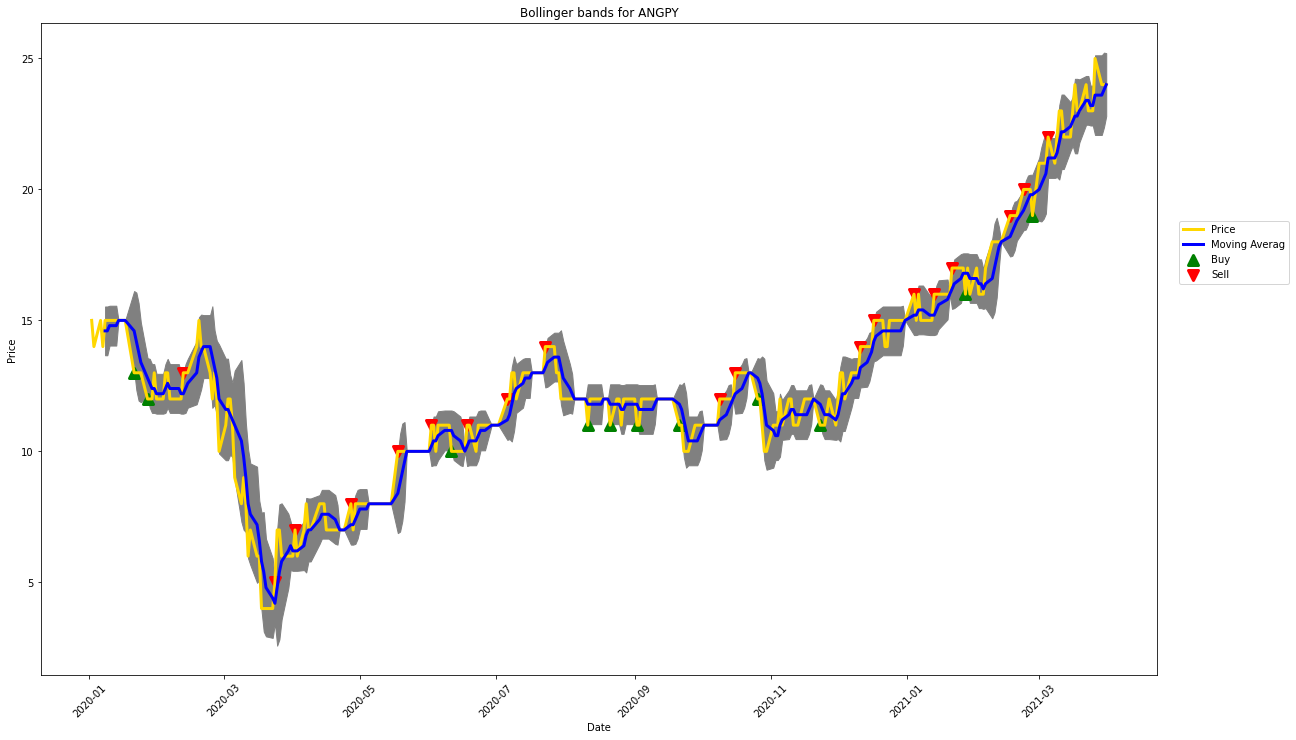

In [463]:
# Bollinger bands for the actual data daily

bollinger_bands(df = angpy_stock, col = 'ANGPY' , p = 5, std = 1.7)

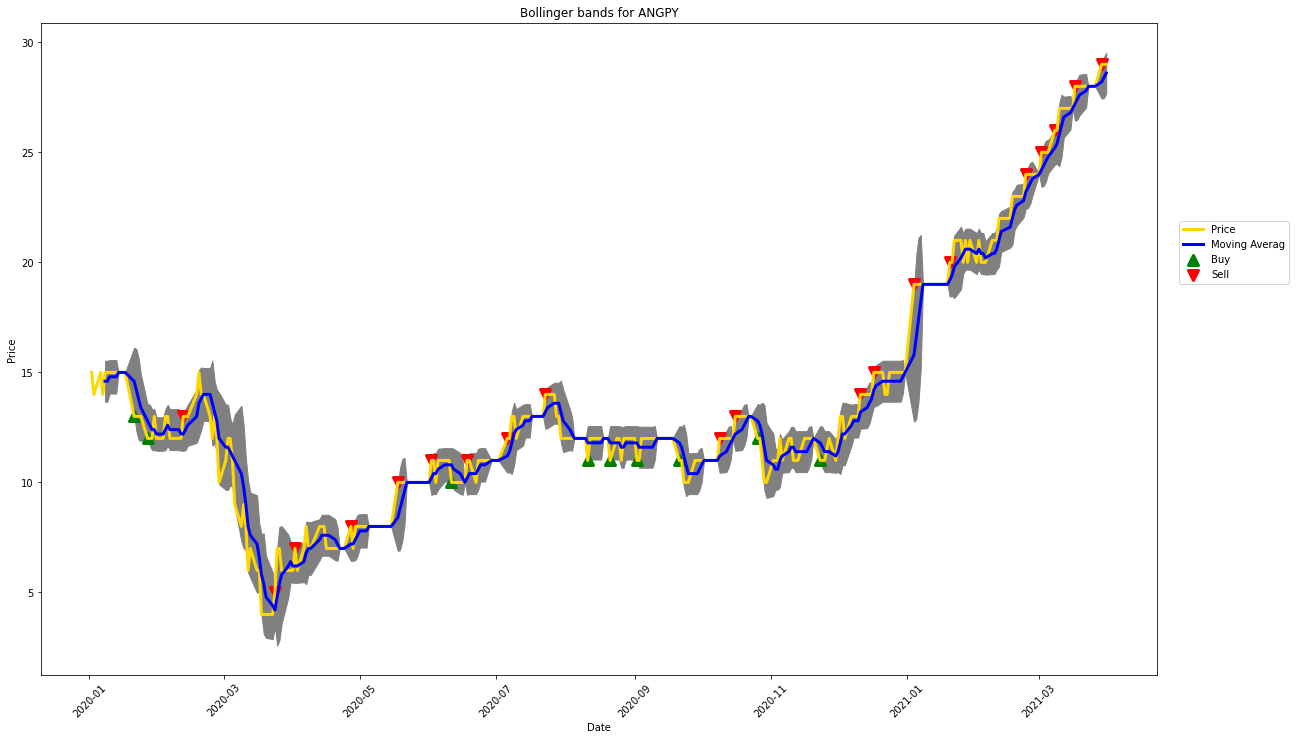

In [464]:
# Bollinger bands for the predicted data daily

bollinger_bands(df = angpy_stock_pred, col = 'ANGPY' , p = 5, std = 1.7)

In [465]:
# Define the values for the S Stock

initial_money = 1000

close = angpy_stock['ANGPY'].tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)



In [466]:
# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 202.851417.3, cost: 0.255589, total money: 184.495426
epoch: 20, total rewards: 192.085315.3, cost: 0.222344, total money: 228.511010
epoch: 30, total rewards: 185.860656.3, cost: 0.182287, total money: 302.854538
epoch: 40, total rewards: 189.234591.3, cost: 0.149302, total money: 365.434637
epoch: 50, total rewards: 181.869432.3, cost: 0.134286, total money: 392.994132
epoch: 60, total rewards: 188.007441.3, cost: 0.095335, total money: 487.513497
epoch: 70, total rewards: 193.662468.3, cost: 0.078201, total money: 532.338630
epoch: 80, total rewards: 194.863022.3, cost: 0.083266, total money: 510.289526
epoch: 90, total rewards: 199.513981.3, cost: 0.072825, total money: 537.329445
epoch: 100, total rewards: 202.145026.3, cost: 0.047641, total money: 623.212089


In [467]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 15.370804, total balance 984.629196
day 5: buy 1 unit at price 15.000250, total balance 969.628946
day 6: buy 1 unit at price 15.252419, total balance 954.376527
day 7: buy 1 unit at price 15.255307, total balance 939.121220
day 8, sell 1 unit at price 15.207183, investment -1.064492 %, total balance 954.328403,
day 10, sell 1 unit at price 15.226433, investment 1.507861 %, total balance 969.554835,
day 14: buy 1 unit at price 13.542092, total balance 956.012743
day 15: buy 1 unit at price 13.291848, total balance 942.720895
day 17: buy 1 unit at price 12.608487, total balance 930.112408
day 18: buy 1 unit at price 12.993479, total balance 917.118929
day 19, sell 1 unit at price 13.027166, investment -14.589509 %, total balance 930.146095,
day 21: buy 1 unit at price 12.897231, total balance 917.248864
day 22: buy 1 unit at price 13.580592, total balance 903.668272
day 23, sell 1 unit at price 13.291848, investment -12.870662 %, total balance 916.960120,
day 

day 270: buy 1 unit at price 17.602497, total balance 715.781144
day 271: buy 1 unit at price 16.427031, total balance 699.354113
day 272: buy 1 unit at price 17.713650, total balance 681.640463
day 273: buy 1 unit at price 16.722126, total balance 664.918337
day 274: buy 1 unit at price 16.781145, total balance 648.137192
day 275: buy 1 unit at price 16.968040, total balance 631.169152
day 276, sell 1 unit at price 17.676271, investment 58.047494 %, total balance 648.845423,
day 278, sell 1 unit at price 18.509426, investment 75.368131 %, total balance 667.354849,
day 280, sell 1 unit at price 18.984531, investment 75.614193 %, total balance 686.339381,
day 281, sell 1 unit at price 18.915676, investment 70.101720 %, total balance 705.255057,
day 282: buy 1 unit at price 19.781292, total balance 685.473765
day 285: buy 1 unit at price 19.850147, total balance 665.623618
day 286, sell 1 unit at price 20.281971, investment 79.984271 %, total balance 685.905589,
day 288, sell 1 unit at p

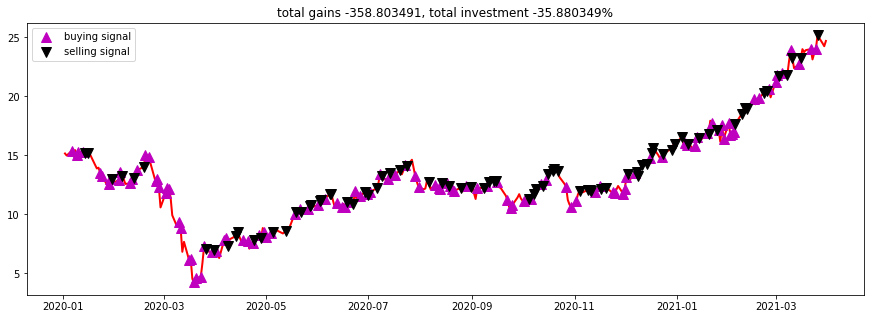

In [468]:
# Plot the results

plot_signals(values = angpy_stock['ANGPY'])

In [469]:
# Define the values for the S Stock

initial_money = 1000

close = angpy_stock_pred['ANGPY'].tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)



In [470]:
# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 1.032933.3, cost: 0.000348, total money: 1001.032933
epoch: 20, total rewards: 0.557376.3, cost: 0.000351, total money: 1000.557376
epoch: 30, total rewards: 0.557376.3, cost: 0.000354, total money: 1000.557376
epoch: 40, total rewards: 0.776731.3, cost: 0.000356, total money: 1000.776731
epoch: 50, total rewards: 1.000021.3, cost: 0.000359, total money: 1001.000021
epoch: 60, total rewards: 0.822963.3, cost: 0.000362, total money: 1000.822963
epoch: 70, total rewards: -0.770556.3, cost: 0.000988, total money: 999.229444
epoch: 80, total rewards: -0.785311.3, cost: 0.000948, total money: 999.214689
epoch: 90, total rewards: 1.725287.3, cost: 0.000432, total money: 1001.725287
epoch: 100, total rewards: -0.034277.3, cost: 0.000886, total money: 999.965723


In [471]:
# Get the buy and sell signals

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 15.159060, total balance 984.840940
day 2, sell 1 unit at price 15.370804, investment 1.396817 %, total balance 1000.211744,
day 8: buy 1 unit at price 15.207183, total balance 985.004561
day 9, sell 1 unit at price 15.110934, investment -0.632916 %, total balance 1000.115496,
day 23: buy 1 unit at price 13.291848, total balance 986.823647
day 26: buy 1 unit at price 12.637362, total balance 974.186286
day 27, sell 1 unit at price 12.993479, investment -2.244755 %, total balance 987.179765,
day 28, sell 1 unit at price 13.080102, investment 3.503425 %, total balance 1000.259867,
day 38: buy 1 unit at price 12.310119, total balance 987.949748
day 39, sell 1 unit at price 10.587279, investment -13.995311 %, total balance 998.537027,
day 41: buy 1 unit at price 12.204246, total balance 986.332782
day 42, sell 1 unit at price 12.180183, investment -0.197162 %, total balance 998.512965,
day 53: buy 1 unit at price 4.229714, total balance 994.283251
day 54, sell 1 

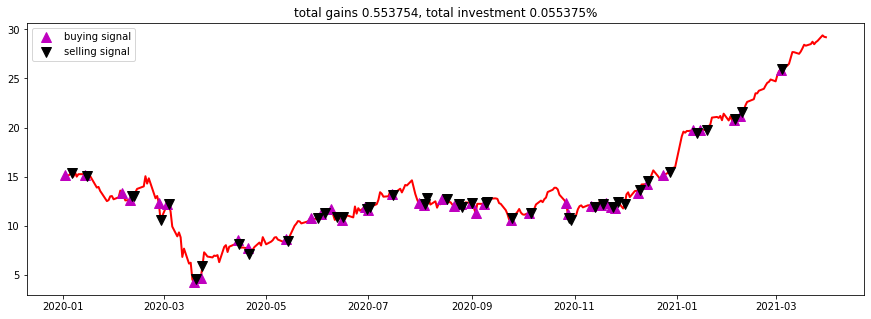

In [472]:
# Plot the results

plot_signals(values = angpy_stock_pred['ANGPY'])